# Preparations

In [1]:
#############################################
###########     LIBRARIES     ###############
#############################################

import warnings
warnings.filterwarnings("ignore")
import pandas as pd                     #data analysis 
import numpy as np                      #vectors and arrays
#import plotly.express as px             #plot graphs
import seaborn as sns                   #beauty graphs
import matplotlib.pyplot as plt         #plot graphs
import math                             
import pylab
import datetime

# 1. File and variables

In [2]:
pd.options.display.max_columns = None

In [3]:
#############################################
###########  READ FILE          #############
#############################################
df_origin = pd.read_csv('../01. Datos/2021_Segmentation_File_MALTA.csv')

In [66]:
#mainpath= '../01. Datos/2021 Segmentation File MALTA.xlsx'
#df_origin = pd.read_excel(mainpath)
#pd.options.display.max_columns = None       #visualization of variables COMPLETE.

In [67]:
#Convert dataframe from excel to csv
#df_origin.to_csv('../01. Datos/2021_Segmentation_File_MALTA.csv', encoding='utf-8', index=False)

In [4]:
###############################################
#########  VARIABLES INFORMATION    ###########
###############################################
df_origin.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 218637 entries, 0 to 218636
Data columns (total 24 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   CustomerId (Anonymized)   202171 non-null  object 
 1   PolicyId
(Anonymized)     218637 non-null  object 
 2   Sub Branch                218637 non-null  object 
 3   Branch                    218635 non-null  object 
 4   Product                   218637 non-null  object 
 5   Effective Date            218637 non-null  object 
 6   Premium                   218637 non-null  float64
 7   Intermediated Policy      218637 non-null  int64  
 8   Contracting Channel       218637 non-null  object 
 9   Personal Data Protection  177902 non-null  object 
 10  Direct Debit              218637 non-null  int64  
 11  Claim                     218334 non-null  float64
 12  N Claims                  218334 non-null  float64
 13  Claim Cost                218334 non-null  f

In [10]:
df_origin.isna().sum()

CustomerId (Anonymized)     16466
PolicyId\n(Anonymized)          0
Sub Branch                      0
Branch                          2
Product                         0
Effective Date                  0
Premium                         0
Intermediated Policy            0
Contracting Channel             0
Personal Data Protection    40735
Direct Debit                    0
Claim                         303
N Claims                      303
Claim Cost                    303
Person Type                     0
Age                         15651
Tenure                      10324
Gender                      26929
Integrality                 58496
Profitability                 303
Loss Ratio                    303
Client Vaue Group           58537
Client Segmentation             0
Client Area                 44878
dtype: int64

In [5]:
##########################################
#########  VARIABLES RENAME    ###########
##########################################

df_rename = df_origin.rename(columns = {
    "CustomerId (Anonymized)": "CustomerId",
    "Sub Branch": "SubBranch",
    "Effective Date": "EffectiveDate",
    "Intermediated Policy": "IntermediatedPolicy",
    "Contracting Channel": "ContractChannel",
    "Personal Data Protection": "PersonalDataProtection",
    "Direct Debit": "DirectDebit",
    "N Claims": "NClaims",
    "Claim Cost": "ClaimCost",
    "Person Type": "PersonType",
    "Loss Ratio": "LossRatio",
    "Client Vaue Group": "ClientValueGroup",
    "Client Segmentation": "ClientSegmentation",
    "Client Area": "ClientArea"
})
df_rename.rename(columns={ df_rename.columns[1]: "PolicyId" }, inplace = True)

In [6]:
################################
######  PARSING DATE    ########
################################
from datetime import datetime as dt
df_rename['EffectiveDate'] = pd.to_datetime(df_rename['EffectiveDate'])

In [7]:
#####################################
######  TENURE CALCULATED    ########
#####################################
df_rename['MaxDate'] = "20210630"
df_rename['MaxDate'] = pd.to_datetime(df_rename['MaxDate'], format = '%Y%m%d')
df_rename['TenureCalculated'] = ((df_rename.MaxDate - df_rename.EffectiveDate)/np.timedelta64(1, 'M'))
df_rename['TenureCalculated'] = df_rename['TenureCalculated'].astype(int)
df_rename['TenureCalculated']= df_rename['TenureCalculated'].replace([-1, -3, -2, -4, -5],[-1, -1, -1, -1, -1])

In [8]:
#Fixed LossRatio column
df_rename['LossRatio'] = df_rename['LossRatio'] * 100

In [9]:
##########################################
######   LOSS RATIO CALCULATED    ########
##########################################
df_rename['LossRatioCalculated1'] = np.where((df_rename['LossRatio'] <= 30), 1, 4)
df_rename['LossRatioCalculated2'] = np.where((df_rename['LossRatio'] > 30) & (df_rename['LossRatio'] <= 60) &\
                                             (df_rename['LossRatio'] != 1), 2, 4)
df_rename['LossRatioCalculated3'] = np.where((df_rename['LossRatio'] > 60) & (df_rename['LossRatio'] <= 100) &\
                                             (df_rename['LossRatio'] != 1) & (df_rename['LossRatio'] != 2), 3, 4)

conditions = [
    (df_rename['LossRatioCalculated1'] == 1),
    (df_rename['LossRatioCalculated2'] == 2),
    (df_rename['LossRatioCalculated3'] == 3)]
choices = [1, 2, 3]
df_rename['LossRatioCalculated'] = np.select(conditions, choices, default = 4)

df_rename.LossRatioCalculated.value_counts()

1    179279
4     24473
2      7488
3      7397
Name: LossRatioCalculated, dtype: int64

In [10]:
#Store rows with CustomerId NaN
df_id_nan = df_rename[df_rename["CustomerId"].isna()]
df_id_nan

,CustomerId,PolicyId,SubBranch,Branch,Product,EffectiveDate,Premium,IntermediatedPolicy,ContractChannel,PersonalDataProtection,DirectDebit,Claim,NClaims,ClaimCost,PersonType,Age,Tenure,Gender,Integrality,Profitability,LossRatio,ClientValueGroup,ClientSegmentation,ClientArea,MaxDate,TenureCalculated,LossRatioCalculated1,LossRatioCalculated2,LossRatioCalculated3,LossRatioCalculated
0,NaN,POL001,Group health,Health,Group health,2013-01-05,523.000000,1,Agents,NaN,0,1.0,39.0,2443.66,Individual,21.0,NaN,NaN,NaN,-570.471772,130.454589,NaN,Gold,NaN,2021-06-30,101,4,4,4,4
1,NaN,POL002,Group health,Health,Group health,2020-01-05,2289.000000,1,Agents,NaN,0,1.0,1.0,65.15,Individual,31.0,NaN,Female,NaN,924.767725,6.581355,NaN,Gold,NaN,2021-06-30,17,1,4,4,1
2,NaN,POL003,Group health,Health,Group health,2013-01-03,1784.800049,1,Agents,NaN,0,1.0,3.0,2779.00,Individual,74.0,NaN,NaN,NaN,11334.622874,19.690196,NaN,Silver,NaN,2021-06-30,101,1,4,4,1
3,NaN,POL004,Group health,Health,Group health,2013-01-03,100.000000,1,Agents,NaN,0,0.0,0.0,0.00,Individual,49.0,NaN,NaN,NaN,885.536575,0.000000,NaN,Silver,NaN,2021-06-30,101,1,4,4,1
4,NaN,POL005,Group health,Health,Group health,2013-01-03,100.000000,1,Agents,NaN,0,0.0,0.0,0.00,Individual,82.0,NaN,NaN,NaN,885.536575,0.000000,NaN,Silver,NaN,2021-06-30,101,1,4,4,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
218617,NaN,POL218596,Group health,Health,Group health,2020-07-20,0.844418,1,Agents,NaN,0,0.0,0.0,0.00,Individual,22.0,1.0,Male,NaN,114.243279,0.000000,NaN,Silver,NaN,2021-06-30,11,1,4,4,1
218632,NaN,POL218611,Group health,Health,Group health,2021-04-19,1836.005981,1,Agents,NaN,0,0.0,0.0,0.00,Individual,40.0,0.0,Female,NaN,337.020229,0.000000,NaN,Silver,NaN,2021-06-30,2,1,4,4,1
218634,NaN,POL218613,Individual health,Health,Individual health,2020-01-07,690.000000,1,Agents,NaN,0,0.0,0.0,0.00,Individual,79.0,1.0,Female,NaN,678.657535,0.000000,NaN,Silver,NaN,2021-06-30,17,1,4,4,1
218635,NaN,POL218614,Individual health,Health,Individual health,2021-04-13,130.000000,1,Agents,NaN,0,0.0,0.0,0.00,Individual,28.0,0.0,Male,NaN,26.000000,0.000000,NaN,Silver,NaN,2021-06-30,2,1,4,4,1


In [11]:
#No NaN in CustomerId column
mod_df = df_rename.dropna( how='any',subset=['CustomerId'])
mod_df.shape

(202171, 30)

In [12]:
mod_df.CustomerId.nunique()

122876

In [78]:
#Valores variables
#mod_df["Product"].unique()
#mod_df["Branch"].unique()
#mod_df["Sub_branch"].unique()
#mod_df["Interm_policy"].unique()
#mod_df["Contract_channel"].unique()
#mod_df["Dir_debit"].unique()
mod_df["PersonType"].unique()

array(['Individual', 'Company'], dtype=object)

In [13]:
################################################
######  INDIVIDUAL CUSTOMER POLICIES    ########
################################################
polpart = mod_df[mod_df["PersonType"] == "Individual"]
polpart.shape

(186533, 30)

In [14]:
polpart.CustomerId.nunique()

119581

In [15]:
###############################################
######  COMPANIES CUSTOMER POLICIES    ########
###############################################
polemp = mod_df[mod_df["PersonType"] == "Company"]
polemp.shape

(15638, 30)

In [16]:
polemp.CustomerId.nunique()

3295

# 2. Univariant analysis

In [17]:
#########################################################
#######    NUMERICAL VARIABLES AT POLICY LEVEL   ########
#########################################################
polpartnum = polpart[['EffectiveDate','Premium','ClaimCost','Claim','NClaims','TenureCalculated', 'Tenure', 'Profitability', 'LossRatio']]

In [18]:
#Pólizas repetidas
polrep=polpart.groupby(['PolicyId'],as_index=False).agg({'CustomerId': ['count']})
polrep.columns = ['{}_{}'.format(x[0], x[1]) for x in  polrep.columns]
polrep

,PolicyId_,CustomerId_count
0,POL10000,1
1,POL100000,1
2,POL100001,1
3,POL100002,1
4,POL100003,1
...,...,...
186514,POL99995,1
186515,POL99996,1
186516,POL99997,1
186517,POL99998,1


In [19]:
#Comprobación pólizas con más de un cliente
polrep[(polrep['CustomerId_count']) > 1]

,PolicyId_,CustomerId_count
3143,POL102925,2
7028,POL106500,2
23936,POL12203,2
32164,POL129603,2
33026,POL130410,2
37726,POL134924,2
37727,POL134925,2
68811,POL167957,2
78572,POL178888,2
117511,POL30573,2


In [20]:
##############################################################
#######     EFFECTIVE DATE ANALYSIS AT POLICY LEVEL   ########
##############################################################
polpartnum['EffectiveDate'].describe()

count                  186533
unique                   5393
top       2019-01-01 00:00:00
freq                     1764
first     1998-04-08 00:00:00
last      2021-12-06 00:00:00
Name: EffectiveDate, dtype: object

In [21]:
polpartnum.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 186533 entries, 7648 to 218633
Data columns (total 9 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   EffectiveDate     186533 non-null  datetime64[ns]
 1   Premium           186533 non-null  float64       
 2   ClaimCost         186422 non-null  float64       
 3   Claim             186422 non-null  float64       
 4   NClaims           186422 non-null  float64       
 5   TenureCalculated  186533 non-null  int64         
 6   Tenure            186532 non-null  float64       
 7   Profitability     186422 non-null  float64       
 8   LossRatio         186422 non-null  float64       
dtypes: datetime64[ns](1), float64(7), int64(1)
memory usage: 19.2 MB


In [22]:
###############################################################################
#######     UNIVARIANT ANALYSIS OF NUMERIC VARIABLES AT POLICY LEVEL   ########
###############################################################################
univariante= polpartnum._get_numeric_data()

def describe_new(univariante):
    df1 = univariante.describe()
    df1.loc["range"] = df1.loc['max'] - df1.loc['min']
    return df1

display(describe_new(univariante))
univariante.shape

,Premium,ClaimCost,Claim,NClaims,TenureCalculated,Tenure,Profitability,LossRatio
count,186533.000000,1.864220e+05,186422.000000,186422.000000,186533.000000,186532.000000,1.864220e+05,1.864220e+05
mean,250.950887,3.829208e+02,0.235825,0.628971,49.162036,5.355140,3.057521e+02,-4.831330e+14
std,381.609108,4.063442e+03,0.424515,2.456320,41.711940,3.844983,4.077664e+03,1.348447e+17
min,-1207.466797,-1.732966e+05,0.000000,0.000000,-1.000000,0.000000,-1.499166e+06,-5.323818e+19
25%,113.800003,0.000000e+00,0.000000,0.000000,17.000000,2.000000,6.346784e+01,0.000000e+00
50%,181.000000,0.000000e+00,0.000000,0.000000,40.000000,5.000000,2.919832e+02,0.000000e+00
75%,303.619995,0.000000e+00,0.000000,0.000000,71.000000,7.000000,6.917496e+02,0.000000e+00
max,98550.000000,1.500379e+06,1.000000,127.000000,278.000000,23.000000,1.738160e+05,4.825285e+18
range,99757.466797,1.673676e+06,1.000000,127.000000,279.000000,23.000000,1.672982e+06,5.806346e+19


(186533, 8)

In [28]:
uni_pol=describe_new(univariante)
uni_pol.to_excel('../03. Exportaciones/univariante_pol2.xlsx', engine='xlsxwriter')

In [23]:
#Convert personal data protection values to boolean values
polpart["PersonalDataProtectionBool1"] = np.where(polpart["PersonalDataProtection"] == "Send marketing mail", 1, np.nan)
polpart["PersonalDataProtectionBool2"] = np.where((polpart['PersonalDataProtectionBool1'] != 1) &\
                                                       (polpart["PersonalDataProtection"] == "Don't send marketing mail"), 0, np.nan)

conditions = [
    (polpart['PersonalDataProtectionBool1'] == 1),
    (polpart['PersonalDataProtectionBool2'] == 0)]
choices = [1, 0]
polpart['PersonalDataProtectionBool'] = np.select(conditions, choices, default = np.nan)
polpart.PersonalDataProtectionBool.value_counts()

1.0    130342
0.0     31922
Name: PersonalDataProtectionBool, dtype: int64

In [24]:
aux=polpart.groupby(['CustomerId'],as_index=False).agg({'Branch':pd.Series.nunique})
aux.columns = ['{}_{}'.format(x[0], x[1]) for x in  aux.columns]
aux=aux.reset_index()
aux.drop(["index"], axis = 1, inplace = True)
aux

,C_u,B_r
0,CLIENT002,0
1,CLIENT004,1
2,CLIENT005,1
3,CLIENT007,1
4,CLIENT008,1
...,...,...
119576,CLIENT99995,1
119577,CLIENT99996,2
119578,CLIENT99997,1
119579,CLIENT99998,1


In [25]:
#Recalculated SubBranch to create IntegralityCalculated2
polpart["SubBranch_Health"] = np.where((polpart["SubBranch"] == "Group health") |\
                                       (polpart["SubBranch"] == "Individual health"), "Health", "Home")
polpart["SubBranch_Trav_Comm_Oth"] = np.where((polpart['SubBranch_Health'] != "Health") &\
                                              ((polpart["SubBranch"] == "Travel") |\
                                              (polpart["SubBranch"] == "Other") |\
                                              (polpart["SubBranch"] == "Commercial")), "Trav_Comm_Oth", "Home")
polpart["SubBranch_Motor"] = np.where((polpart['SubBranch_Health'] != "Health") & (polpart['SubBranch_Trav_Comm_Oth'] != "Trav_Comm_Oth") &\
                                              (polpart["SubBranch"] == "Motor"), "Motor", "Home")

conditions = [
    (polpart['SubBranch_Health'] == "Health"),
    (polpart['SubBranch_Trav_Comm_Oth'] == "Trav_Comm_Oth"),
    (polpart['SubBranch_Motor'] == "Motor")]
choices = ["Health", "Trav_Comm_Oth", "Motor"]
polpart['SubBranch_new'] = np.select(conditions, choices, default = "Home")
polpart.SubBranch_new.value_counts()

Motor            116353
Home              35845
Health            24269
Trav_Comm_Oth     10066
Name: SubBranch_new, dtype: int64

In [26]:
aux2=polpart.groupby(['CustomerId'],as_index=False).agg({'SubBranch_new':pd.Series.nunique})
aux2.columns = ['{}_{}'.format(x[0], x[1]) for x in  aux2.columns]
aux2=aux2.reset_index()
aux2.drop(["index"], axis = 1, inplace = True)
aux2

,C_u,S_u
0,CLIENT002,1
1,CLIENT004,1
2,CLIENT005,1
3,CLIENT007,1
4,CLIENT008,1
...,...,...
119576,CLIENT99995,1
119577,CLIENT99996,2
119578,CLIENT99997,1
119579,CLIENT99998,1


In [27]:
##########################################################
#######     GROUP BY TO INDIVIDUAL CUSTOMER LEVEL ########
##########################################################
clientesp=polpart.groupby(['CustomerId'],as_index=False).agg({'Premium': ['sum', 'min', 'max'],
                                                              'PolicyId':['count'],
                                                              'Age':['max'],
                                                              'Tenure':['max'],
                                                              'TenureCalculated':['max'],
                                                              'Gender':['first'],
                                                              'Integrality':['first'],
                                                              'Claim':['max'],
                                                              'NClaims':['sum'],
                                                              'ClaimCost':['sum'],
                                                              'Profitability':['sum'],
                                                              'PersonalDataProtectionBool':['max'],
                                                              'DirectDebit':['max', 'min'],
                                                              'IntermediatedPolicy':['max'],
                                                              'EffectiveDate':['min'],
                                                              'LossRatio':['max'],
                                                              'LossRatioCalculated': ['max'],
                                                              'ClientSegmentation': ['first']})
clientesp.columns = ['{}_{}'.format(x[0], x[1]) for x in  clientesp.columns]
clientesp=clientesp.rename(columns={'CustomerId_':'CustomerId'})
clientesp

,CustomerId,Premium_sum,Premium_min,Premium_max,PolicyId_count,Age_max,Tenure_max,TenureCalculated_max,Gender_first,Integrality_first,Claim_max,NClaims_sum,ClaimCost_sum,Profitability_sum,PersonalDataProtectionBool_max,DirectDebit_max,DirectDebit_min,IntermediatedPolicy_max,EffectiveDate_min,LossRatio_max,LossRatioCalculated_max,ClientSegmentation_first
0,CLIENT002,280.000000,280.000000,280.000000,1,NaN,NaN,4,NaN,D,0.0,0.0,0.0,63.767120,0.0,1,1,1,2021-01-29,0.000000,1,Silver
1,CLIENT004,410.130005,410.130005,410.130005,1,75.0,8.0,97,Male,D,1.0,1.0,350.0,1806.372677,1.0,1,1,1,2013-05-20,16.230961,1,Silver
2,CLIENT005,140.000000,140.000000,140.000000,1,71.0,3.0,38,Male,D,0.0,0.0,0.0,363.552737,1.0,0,0,1,2018-04-24,0.000000,1,Silver
3,CLIENT007,406.500000,406.500000,406.500000,1,58.0,0.0,5,Female,C,0.0,0.0,0.0,33.684398,1.0,1,1,1,2021-01-04,0.000000,1,Silver
4,CLIENT008,0.000000,0.000000,0.000000,1,4.0,2.0,29,Male,NaN,0.0,0.0,0.0,40.990000,NaN,0,0,1,2019-01-01,0.000000,1,Silver
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119576,CLIENT99995,228.750000,228.750000,228.750000,1,43.0,2.0,29,Female,D,0.0,0.0,0.0,350.779726,1.0,1,1,1,2019-01-07,0.000000,1,Silver
119577,CLIENT99996,177.277794,70.000000,107.277794,2,42.0,4.0,43,Male,C,0.0,0.0,0.0,318.575265,0.0,1,1,1,2017-11-18,0.000000,1,Gold
119578,CLIENT99997,150.000000,150.000000,150.000000,1,39.0,9.0,113,Male,C,0.0,0.0,0.0,1088.352737,1.0,0,0,0,2012-01-05,0.000000,1,Platinum
119579,CLIENT99998,25.000000,25.000000,25.000000,1,60.0,2.0,29,NaN,NaN,0.0,0.0,0.0,47.903835,NaN,0,0,1,2019-01-06,0.000000,1,Gold


In [28]:
clientesp['ProfitabilityCalculated'] = clientesp['Premium_sum']-(clientesp['ClaimCost_sum'])

In [29]:
clientesp['IntegralityCalculated'] = aux["B_r"]

In [30]:
clientesp['IntegralityCalculated']= clientesp['IntegralityCalculated'].replace([0],[1])

In [31]:
clientesp['IntegralityCalculated'].value_counts()

1    101548
2     15890
3      2115
4        28
Name: IntegralityCalculated, dtype: int64

In [32]:
clientesp['IntegralityCalculated2'] = aux2["S_u"]
clientesp['IntegralityCalculated2'].value_counts()

1    101595
2     15845
3      2112
4        29
Name: IntegralityCalculated2, dtype: int64

In [33]:
######################################
#######     CHANNEL OF CLIENT ########
######################################
canal_count=polpart[['CustomerId', 'ContractChannel']].groupby(['CustomerId','ContractChannel']).size().reset_index(name='Count')

In [34]:
canal=canal_count.sort_values('Count', ascending=False).groupby(['CustomerId']).agg({'ContractChannel': ['first']})
canal.columns = ['{}_{}'.format(x[0], x[1]) for x in  canal.columns]
canal=canal.reset_index()
canal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119581 entries, 0 to 119580
Data columns (total 2 columns):
 #   Column                 Non-Null Count   Dtype 
---  ------                 --------------   ----- 
 0   CustomerId             119581 non-null  object
 1   ContractChannel_first  119581 non-null  object
dtypes: object(2)
memory usage: 1.8+ MB


In [35]:
clientespart= pd.merge(clientesp, canal, on='CustomerId', how='left')
clientespart.head()

,CustomerId,Premium_sum,Premium_min,Premium_max,PolicyId_count,Age_max,Tenure_max,TenureCalculated_max,Gender_first,Integrality_first,Claim_max,NClaims_sum,ClaimCost_sum,Profitability_sum,PersonalDataProtectionBool_max,DirectDebit_max,DirectDebit_min,IntermediatedPolicy_max,EffectiveDate_min,LossRatio_max,LossRatioCalculated_max,ClientSegmentation_first,ProfitabilityCalculated,IntegralityCalculated,IntegralityCalculated2,ContractChannel_first
0,CLIENT002,280.000000,280.000000,280.000000,1,NaN,NaN,4,NaN,D,0.0,0.0,0.0,63.767120,0.0,1,1,1,2021-01-29,0.000000,1,Silver,280.000000,1,1,Brokers
1,CLIENT004,410.130005,410.130005,410.130005,1,75.0,8.0,97,Male,D,1.0,1.0,350.0,1806.372677,1.0,1,1,1,2013-05-20,16.230961,1,Silver,60.130005,1,1,Agents
2,CLIENT005,140.000000,140.000000,140.000000,1,71.0,3.0,38,Male,D,0.0,0.0,0.0,363.552737,1.0,0,0,1,2018-04-24,0.000000,1,Silver,140.000000,1,1,Agents
3,CLIENT007,406.500000,406.500000,406.500000,1,58.0,0.0,5,Female,C,0.0,0.0,0.0,33.684398,1.0,1,1,1,2021-01-04,0.000000,1,Silver,406.500000,1,1,TIIs
4,CLIENT008,0.000000,0.000000,0.000000,1,4.0,2.0,29,Male,NaN,0.0,0.0,0.0,40.990000,NaN,0,0,1,2019-01-01,0.000000,1,Silver,0.000000,1,1,Brokers


In [36]:
######################################################################################
#######     ANALISIS UNIVARIANTE DE LAS VARIABLES NUMÉRICAS A NIVEL CLIENTE   ########
######################################################################################
clipartnum= clientespart._get_numeric_data()

def describe_new(clipartnum):
    df11 = clipartnum.describe()
    df11.loc["range"] = df11.loc['max'] - df11.loc['min']
    return df11


display(describe_new(clipartnum))
clipartnum.shape

,Premium_sum,Premium_min,Premium_max,PolicyId_count,Age_max,Tenure_max,TenureCalculated_max,Claim_max,NClaims_sum,ClaimCost_sum,Profitability_sum,PersonalDataProtectionBool_max,DirectDebit_max,DirectDebit_min,IntermediatedPolicy_max,LossRatio_max,LossRatioCalculated_max,ProfitabilityCalculated,IntegralityCalculated,IntegralityCalculated2
count,119581.000000,119581.000000,119581.000000,119581.000000,119568.000000,119580.000000,119581.000000,119521.000000,119581.000000,1.195810e+05,1.195810e+05,97143.000000,119581.000000,119581.000000,119581.000000,1.195210e+05,119581.000000,1.195810e+05,119581.000000,119581.000000
mean,391.455347,204.990181,276.590940,1.559888,43.925423,4.674109,55.831286,0.312347,0.980540,5.969582e+02,4.766552e+02,0.821253,0.602679,0.548206,0.901188,-5.267741e+14,1.603775,-2.055028e+02,1.168957,1.168555
std,1365.623954,219.343394,451.203946,2.156125,16.392210,3.677046,43.884550,0.463452,3.264923,5.326651e+03,5.209952e+03,0.383142,0.489345,0.497673,0.298410,1.599603e+17,1.130243,5.126110e+03,0.420940,0.420624
min,-1044.119766,-1207.466797,-0.008516,1.000000,0.000000,0.000000,-1.000000,0.000000,0.000000,-1.847390e+05,-1.499166e+06,0.000000,0.000000,0.000000,0.000000,-5.323818e+19,1.000000,-1.499924e+06,1.000000,1.000000
25%,136.459999,85.000000,130.000000,1.000000,32.000000,2.000000,20.000000,0.000000,0.000000,0.000000e+00,7.182466e+01,1.000000,0.000000,0.000000,1.000000,0.000000e+00,1.000000,2.835000e+01,1.000000,1.000000
50%,248.199997,150.000000,210.004196,1.000000,42.000000,4.000000,46.000000,0.000000,0.000000,0.000000e+00,3.643578e+02,1.000000,1.000000,1.000000,1.000000,0.000000e+00,1.000000,1.500000e+02,1.000000,1.000000
75%,437.809998,260.420013,330.973541,2.000000,56.000000,6.000000,77.000000,1.000000,1.000000,1.510000e+02,9.114287e+02,1.000000,1.000000,1.000000,1.000000,2.520265e+01,1.000000,3.185039e+02,1.000000,1.000000
max,354849.733521,14500.000000,98550.000000,473.000000,132.000000,23.000000,278.000000,1.000000,294.000000,1.500379e+06,1.895643e+05,1.000000,1.000000,1.000000,1.000000,4.825285e+18,4.000000,1.867671e+05,4.000000,4.000000
range,355893.853287,15707.466797,98550.008516,472.000000,132.000000,23.000000,279.000000,1.000000,294.000000,1.685118e+06,1.688731e+06,1.000000,1.000000,1.000000,1.000000,5.806346e+19,3.000000,1.686691e+06,3.000000,3.000000


(119581, 20)

In [27]:
#Exportar a csv
uni_cli=describe_new(clipartnum)
uni_cli.to_excel('../03. Exportaciones/univariante_cli_4.xlsx', engine='xlsxwriter')  

# 2. Numerical variables

## 2.1 Age

In [44]:
clientespart[clientespart.Age_max == 0].shape

(203, 26)

In [45]:
clientespart[clientespart.Age_max < 0].shape

(0, 26)

In [46]:
clientespart[clientespart.Age_max > 0].shape

(119365, 26)

In [47]:
clientespart[(clientespart.Age_max > 0) & (clientespart.Age_max < 18)].shape

(2825, 26)

In [48]:
clientespart[(clientespart.Age_max >= 18) & (clientespart.Age_max < 30)].shape

(19887, 26)

In [49]:
clientespart[(clientespart.Age_max >= 30) & (clientespart.Age_max < 40)].shape

(30347, 26)

In [50]:
clientespart[(clientespart.Age_max >= 40) & (clientespart.Age_max < 50)].shape

(25486, 26)

In [51]:
clientespart[(clientespart.Age_max >= 50) & (clientespart.Age_max < 65)].shape

(25417, 26)

In [52]:
clientespart[(clientespart.Age_max >= 65) & (clientespart.Age_max < 90)].shape

(15264, 26)

In [53]:
clientespart[clientespart.Age_max >= 90].shape

(139, 26)

In [54]:
clientespart[clientespart.Age_max > 100].shape

(11, 26)

## 2.2 Tenure_max

In [45]:
clientespart[clientespart.Tenure_max == 0].shape

(8672, 22)

In [132]:
clientespart[clientespart.Tenure_max < 0].shape

(0, 21)

In [133]:
clientespart[clientespart.Tenure_max > 0].shape

(110908, 21)

In [141]:
clientespart[(clientespart.Tenure_max > 0) & (clientespart.Tenure_max <= 1)].shape

(16983, 21)

In [142]:
clientespart[(clientespart.Tenure_max > 1) & (clientespart.Tenure_max <= 2)].shape

(14611, 21)

In [143]:
clientespart[(clientespart.Tenure_max > 2) & (clientespart.Tenure_max <= 3)].shape

(14171, 21)

In [156]:
clientespart[(clientespart.Tenure_max > 3) & (clientespart.Tenure_max <= 4)].shape

(10743, 21)

In [157]:
clientespart[(clientespart.Tenure_max > 4) & (clientespart.Tenure_max <= 5)].shape

(14058, 21)

In [158]:
clientespart[(clientespart.Tenure_max > 5) & (clientespart.Tenure_max <= 7)].shape

(19231, 21)

In [159]:
clientespart[(clientespart.Tenure_max > 7) & (clientespart.Tenure_max <= 10)].shape

(9216, 21)

In [160]:
clientespart[(clientespart.Tenure_max > 10)].shape

(11895, 21)

## 2.3 TenureCalculated_max

In [46]:
clientespart[clientespart.TenureCalculated_max == 0].shape

(905, 22)

In [47]:
clientespart[clientespart.TenureCalculated_max < 0].shape

(1177, 22)

In [61]:
a=clientespart[clientespart["TenureCalculated_max"] < 0]


In [62]:
a.head()

,CustomerId,Premium_sum,Premium_min,Premium_max,PolicyId_count,Age_max,Tenure_max,TenureCalculated_max,Gender_first,Integrality_first,Claim_max,NClaims_sum,ClaimCost_sum,Profitability_sum,PersonalDataProtectionBool_max,DirectDebit_max,DirectDebit_min,IntermediatedPolicy_max,EffectiveDate_min,LossRatio_max,ProfitabilityCalculated,IntegralityCalculated,ContractChannel_first
6,CLIENT010,748.750000,748.750000,748.750000,1,39.0,0.0,-1,Male,NaN,0.0,0.0,0.0,-114.876709,1.0,1,1,1,2021-08-06,0.0,748.750000,1,TIIs
93,CLIENT1000,90.000000,90.000000,90.000000,1,43.0,0.0,-1,Male,D,0.0,0.0,0.0,3.698631,1.0,0,0,1,2021-10-06,0.0,90.000000,1,Banks
150,CLIENT100053,222.500000,222.500000,222.500000,1,62.0,0.0,-1,Male,D,0.0,0.0,0.0,46.547405,1.0,0,0,1,2021-09-01,0.0,222.500000,1,Agents
345,CLIENT100247,145.007278,145.007278,145.007278,1,36.0,5.0,-1,Female,D,0.0,0.0,0.0,65.551238,1.0,0,0,0,2021-11-01,0.0,145.007278,1,Direct
357,CLIENT10026,280.004028,280.004028,280.004028,1,46.0,0.0,-1,Female,D,0.0,0.0,0.0,-33.671950,1.0,1,1,1,2021-08-06,0.0,280.004028,1,Agents


In [121]:
clientespart[clientespart.TenureCalculated_max > 0].shape

(117499, 21)

In [122]:
clientespart[(clientespart.TenureCalculated_max > 0) & (clientespart.TenureCalculated_max <= 12)].shape

(14749, 21)

In [123]:
clientespart[(clientespart.TenureCalculated_max > 12) & (clientespart.TenureCalculated_max <= 24)].shape

(16718, 21)

In [124]:
clientespart[(clientespart.TenureCalculated_max > 24) & (clientespart.TenureCalculated_max <= 36)].shape

(14742, 21)

In [125]:
clientespart[(clientespart.TenureCalculated_max > 36) & (clientespart.TenureCalculated_max <= 48)].shape

(12959, 21)

In [126]:
clientespart[(clientespart.TenureCalculated_max > 48) & (clientespart.TenureCalculated_max <= 60)].shape

(9940, 21)

In [127]:
clientespart[(clientespart.TenureCalculated_max > 60) & (clientespart.TenureCalculated_max <= 72)].shape

(13164, 21)

In [129]:
clientespart[(clientespart.TenureCalculated_max > 72) & (clientespart.TenureCalculated_max <= 84)].shape

(11273, 21)

In [128]:
clientespart[(clientespart.TenureCalculated_max > 84) & (clientespart.TenureCalculated_max <= 120)].shape

(11163, 21)

In [130]:
clientespart[(clientespart.TenureCalculated_max > 120)].shape

(12791, 21)

## 2.4 Profitability_sum

In [171]:
clientespart[clientespart.Profitability_sum < 0].shape

(17606, 21)

In [172]:
clientespart[clientespart.Profitability_sum == 0].shape

(63, 21)

In [173]:
clientespart[clientespart.Profitability_sum > 0].shape

(101912, 21)

In [174]:
clientespart[(clientespart.Profitability_sum > 0) & (clientespart.Profitability_sum <= 100)].shape

(16230, 21)

In [175]:
clientespart[(clientespart.Profitability_sum > 100) & (clientespart.Profitability_sum <= 200)].shape

(11662, 21)

In [176]:
clientespart[(clientespart.Profitability_sum > 200) & (clientespart.Profitability_sum <= 400)].shape

(16671, 21)

In [177]:
clientespart[(clientespart.Profitability_sum > 400) & (clientespart.Profitability_sum <= 600)].shape

(13326, 21)

In [178]:
clientespart[(clientespart.Profitability_sum > 600) & (clientespart.Profitability_sum <= 800)].shape

(9779, 21)

In [179]:
clientespart[(clientespart.Profitability_sum > 800) & (clientespart.Profitability_sum <= 1000)].shape

(7341, 21)

In [182]:
clientespart[(clientespart.Profitability_sum > 1000) & (clientespart.Profitability_sum <=1500)].shape

(11278, 21)

In [184]:
clientespart[(clientespart.Profitability_sum > 1500) & (clientespart.Profitability_sum <=2500)].shape

(9088, 21)

In [185]:
clientespart[clientespart.Profitability_sum > 2500].shape

(6537, 21)

## 2.5 ProfitabilityCalculated

In [161]:
clientespart[clientespart.ProfitabilityCalculated < 0].shape

(26883, 21)

In [162]:
clientespart[clientespart.ProfitabilityCalculated == 0].shape

(407, 21)

In [163]:
clientespart[clientespart.ProfitabilityCalculated > 0].shape

(92291, 21)

In [164]:
clientespart[(clientespart.ProfitabilityCalculated > 0) & (clientespart.ProfitabilityCalculated <= 100)].shape

(21053, 21)

In [165]:
clientespart[(clientespart.ProfitabilityCalculated > 100) & (clientespart.ProfitabilityCalculated <= 200)].shape

(23001, 21)

In [166]:
clientespart[(clientespart.ProfitabilityCalculated > 200) & (clientespart.ProfitabilityCalculated <= 400)].shape

(27003, 21)

In [167]:
clientespart[(clientespart.ProfitabilityCalculated > 400) & (clientespart.ProfitabilityCalculated <= 600)].shape

(10463, 21)

In [168]:
clientespart[(clientespart.ProfitabilityCalculated > 600) & (clientespart.ProfitabilityCalculated <= 800)].shape

(4584, 21)

In [169]:
clientespart[(clientespart.ProfitabilityCalculated > 800) & (clientespart.ProfitabilityCalculated <= 1000)].shape

(2278, 21)

In [170]:
clientespart[clientespart.ProfitabilityCalculated > 1000].shape

(3909, 21)

## 2.6 ClaimCost_sum

In [51]:
clientespart[clientespart.Claim_cost_sum < 0].shape

(311, 18)

In [52]:
clientespart[clientespart.Claim_cost_sum == 0].shape

(84945, 18)

In [53]:
clientespart[clientespart.Claim_cost_sum > 0].shape

(34325, 18)

In [58]:
clientespart[(clientespart.Claim_cost_sum > 0) & (clientespart.Claim_cost_sum <= 500)].shape

(11021, 18)

In [59]:
clientespart[(clientespart.Claim_cost_sum > 500) & (clientespart.Claim_cost_sum <= 1000)].shape

(6282, 18)

In [60]:
clientespart[(clientespart.Claim_cost_sum > 1000) & (clientespart.Claim_cost_sum <= 2000)].shape

(7627, 18)

In [62]:
clientespart[(clientespart.Claim_cost_sum > 2000) & (clientespart.Claim_cost_sum <= 3000)].shape

(3391, 18)

In [63]:
clientespart[clientespart.Claim_cost_sum > 3000].shape

(6004, 18)

## 2.7 Premium_sum

In [64]:
clientespart[clientespart.Premium_sum < 0].shape

(47, 18)

In [65]:
clientespart[clientespart.Premium_sum == 0].shape

(664, 18)

In [66]:
clientespart[clientespart.Premium_sum > 0].shape

(118870, 18)

In [68]:
clientespart[(clientespart.Premium_sum > 0) & (clientespart.Premium_sum <= 100)].shape

(22874, 18)

In [70]:
clientespart[(clientespart.Premium_sum > 100) & (clientespart.Premium_sum <= 200)].shape

(26433, 18)

In [71]:
clientespart[(clientespart.Premium_sum > 200) & (clientespart.Premium_sum <= 350)].shape

(29178, 18)

In [72]:
clientespart[(clientespart.Premium_sum > 350) & (clientespart.Premium_sum <= 500)].shape

(15736, 18)

In [73]:
clientespart[(clientespart.Premium_sum > 500) & (clientespart.Premium_sum <= 700)].shape

(10300, 18)

In [74]:
clientespart[(clientespart.Premium_sum > 700) & (clientespart.Premium_sum <= 1000)].shape

(6901, 18)

In [76]:
clientespart[(clientespart.Premium_sum > 1000) & (clientespart.Premium_sum <= 2000)].shape

(5589, 18)

In [78]:
clientespart[clientespart.Premium_sum > 2000].shape

(1859, 18)

## 2.8 RelationshipIndex

In [59]:
clientespart[clientespart.PolicyId_count == 1].shape

(84415, 24)

In [60]:
clientespart[clientespart.PolicyId_count == 2].shape

(20832, 24)

In [61]:
clientespart[clientespart.PolicyId_count == 3].shape

(7628, 24)

In [63]:
clientespart[clientespart.PolicyId_count == 4].shape

(3367, 24)

In [64]:
clientespart[(clientespart.PolicyId_count > 4) & (clientespart.PolicyId_count <= 7)].shape

(2641, 24)

In [65]:
clientespart[(clientespart.PolicyId_count > 7) & (clientespart.PolicyId_count <= 10)].shape

(453, 24)

In [66]:
clientespart[clientespart.PolicyId_count > 10].shape

(245, 24)

In [96]:
clientespart[clientespart.PolicyId_count == 5].shape

(1521, 23)

In [109]:
clientespart[clientespart.PolicyId_count == 6].shape

(725, 23)

In [110]:
clientespart[clientespart.PolicyId_count >= 7].shape

(1093, 23)

## 2.9 NClaims_sum

In [56]:
clientespart.head()

,CustomerId,Premium_sum,Premium_min,Premium_max,PolicyId_count,Age_max,Tenure_max,TenureCalculated_max,Gender_first,Integrality_first,Claim_max,NClaims_sum,ClaimCost_sum,Profitability_sum,PersonalDataProtectionBool_max,DirectDebit_max,DirectDebit_min,IntermediatedPolicy_max,EffectiveDate_min,LossRatio_max,LossRatioCalculated_max,ClientSegmentation_first,ProfitabilityCalculated,IntegralityCalculated,IntegralityCalculated2,ContractChannel_first
0,CLIENT002,280.000000,280.000000,280.000000,1,NaN,NaN,4,NaN,D,0.0,0.0,0.0,63.767120,0.0,1,1,1,2021-01-29,0.000000,1,Silver,280.000000,1,1,Brokers
1,CLIENT004,410.130005,410.130005,410.130005,1,75.0,8.0,97,Male,D,1.0,1.0,350.0,1806.372677,1.0,1,1,1,2013-05-20,16.230961,1,Silver,60.130005,1,1,Agents
2,CLIENT005,140.000000,140.000000,140.000000,1,71.0,3.0,38,Male,D,0.0,0.0,0.0,363.552737,1.0,0,0,1,2018-04-24,0.000000,1,Silver,140.000000,1,1,Agents
3,CLIENT007,406.500000,406.500000,406.500000,1,58.0,0.0,5,Female,C,0.0,0.0,0.0,33.684398,1.0,1,1,1,2021-01-04,0.000000,1,Silver,406.500000,1,1,TIIs
4,CLIENT008,0.000000,0.000000,0.000000,1,4.0,2.0,29,Male,NaN,0.0,0.0,0.0,40.990000,NaN,0,0,1,2019-01-01,0.000000,1,Silver,0.000000,1,1,Brokers


In [58]:
clientespart[clientespart.NClaims_sum == 0].shape

(82249, 26)

In [59]:
clientespart[clientespart.NClaims_sum > 0].shape

(37332, 26)

In [89]:
clientespart[clientespart.NClaims_sum == 1].shape

(18386, 18)

In [90]:
clientespart[clientespart.NClaims_sum == 2].shape

(7386, 18)

In [91]:
clientespart[clientespart.NClaims_sum == 3].shape

(3668, 18)

In [92]:
clientespart[clientespart.NClaims_sum == 4].shape

(2071, 18)

In [93]:
clientespart[clientespart.NClaims_sum == 5].shape

(1257, 18)

In [96]:
clientespart[clientespart.NClaims_sum == 6].shape

(854, 18)

In [97]:
clientespart[clientespart.NClaims_sum >= 7].shape

(3710, 18)

## 2.10 IntegralityCalculated

In [190]:
clientespart.IntegralityCalculated.value_counts()

1    101548
2     15890
3      2115
4        28
Name: IntegralityCalculated, dtype: int64

In [193]:
clientesp.Integrality_first.value_counts()

D    61388
C    27030
B     6860
Name: Integrality_first, dtype: int64

## 2.11 Loss Ratio Calculated

In [45]:
clientespart.LossRatioCalculated_max.value_counts()

1    90491
4    18965
3     5180
2     4945
Name: LossRatioCalculated_max, dtype: int64

# 3. Categorical variables

In [194]:
polpart.columns

Index(['CustomerId', 'PolicyId', 'SubBranch', 'Branch', 'Product',
       'EffectiveDate', 'Premium', 'IntermediatedPolicy', 'ContractChannel',
       'PersonalDataProtection', 'DirectDebit', 'Claim', 'NClaims',
       'ClaimCost', 'PersonType', 'Age', 'Tenure', 'Gender', 'Integrality',
       'Profitability', 'LossRatio', 'ClientValueGroup', 'ClientSegmentation',
       'ClientArea', 'MaxDate', 'TenureCalculated',
       'PersonalDataProtectionBool1', 'PersonalDataProtectionBool2',
       'PersonalDataProtectionBool'],
      dtype='object')

In [195]:
##########################################################
#######    VARIABLES CATEGÓRICAS A NIVEL PÓLIZA   ########
##########################################################
polpartcat=polpart[['Product','Branch','SubBranch','DirectDebit','ContractChannel','IntermediatedPolicy','Claim','NClaims', 'PersonalDataProtectionBool']]

In [196]:
###########################################################################
############     FRECUENCIAS DE VARIABLES CATEGÓRICAS     ##############
#########################################################################
cat2= polpartcat
start = "\033[1m"
end = "\033[0;0m"

for column in cat2:
    print('{:^24s}'.format(start+column+end))
    x = cat2[column].value_counts()
    x = x.to_frame()
    x[  ' Percentage % '] = x[column] / x[column].sum() * 100 
    x = x.rename(columns={column: "count"})
    display(x)
    print()
    
cat2.shape

   Product    


,count,Percentage %
Private Vehicle,82999,44.495612
Group health,20451,10.963744
Home Policy,17684,9.480360
BoV Home Block,15612,8.369565
Commercial Vehicle,13818,7.407805
...,...,...
Erection All Risks Project,6,0.003217
Deterioration of Stock,2,0.001072
Machinery Breakdown Loss of Profit,2,0.001072
Marine Cargo Open Cover,1,0.000536



    Branch    


,count,Percentage %
Motor,116118,62.251315
Personal Lines,36676,19.662147
Health,24269,13.010706
Commercial Lines,9468,5.075832



  SubBranch   


,count,Percentage %
Motor,116353,62.376630
Home,35845,19.216439
Group health,20451,10.963744
Other,9692,5.195863
Individual health,3818,2.046823
Commercial,248,0.132952
Travel,126,0.067548



 DirectDebit  


,count,Percentage %
1,117070,62.761013
0,69463,37.238987



ContractChannel


,count,Percentage %
Agents,65427,35.075295
TIIs,52001,27.877641
Brokers,34138,18.301319
Direct,18633,9.989117
Banks,16334,8.756628



IntermediatedPolicy


,count,Percentage %
1,167900,90.010883
0,18633,9.989117



    Claim     


,count,Percentage %
0.0,142459,76.417483
1.0,43963,23.582517



   NClaims    


,count,Percentage %
0.0,142459,76.417483
1.0,25001,13.410971
2.0,8502,4.560621
3.0,3700,1.984744
4.0,1792,0.961260
...,...,...
81.0,1,0.000536
65.0,1,0.000536
105.0,1,0.000536
127.0,1,0.000536



PersonalDataProtectionBool


,count,Percentage %
1.0,130342,80.327121
0.0,31922,19.672879


(186533, 9)

In [103]:
polpartcat.Product.value_counts().to_excel('../03. Exportaciones/polpart_product.xlsx', engine='xlsxwriter')

In [105]:
polpartcat.N_claims.value_counts().to_excel('../03. Exportaciones/polpart_N_claims.xlsx', engine='xlsxwriter')

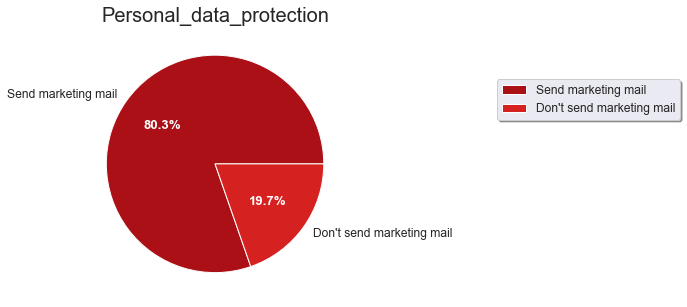

<Figure size 432x288 with 0 Axes>

In [113]:
#################################################################
############     GRÁFICOS VARIABLES CATEGÓRICAS     ##############
##################################################################
sns.set(font_scale= 1.1, palette="Reds_r")    #change font size
column = 'Personal_data_protection'#HAY QUE IR CAMBIANDO LA VARIABLE
fig = plt.figure(figsize=[10,5])      
ax = fig.add_subplot(111)
patches, text, _ = ax.pie(cat2[column].value_counts(), autopct='%.1f%%', textprops={'color':"w", 'weight':'bold'})     #autopct the number stablishes dec.
x = cat2[column].value_counts()
x = x.to_frame()
x[' Percentage % '] = x[column] / x[column].sum() * 100 
x = x.rename(columns={column: " count"})
x[' count'].plot.pie()
ax.set_title(column, fontsize= 20)                                   #adds variable's name
ax.legend(frameon=True, bbox_to_anchor=(2.3,0.9), borderaxespad=2., shadow=True)     #adds the legend
#     plt.savefig(column+"PieChart.jpg")      QUITAR LINEA DE COMENTARio sI SE DESEA GUARDAR
pylab.ylabel('')     #esta linea usa pylab library. QUITA COUNT
plt.show()
print()


plt.tight_layout()      #adjust subplot params so that subplots are nicely fit in the figure

In [197]:
clientespart.columns

Index(['CustomerId', 'Premium_sum', 'Premium_min', 'Premium_max',
       'PolicyId_count', 'Age_max', 'Tenure_max', 'TenureCalculated_max',
       'Gender_first', 'Integrality_first', 'Claim_max', 'NClaims_sum',
       'ClaimCost_sum', 'Profitability_sum', 'PersonalDataProtectionBool_max',
       'DirectDebit_max', 'DirectDebit_min', 'IntermediatedPolicy_max',
       'ProfitabilityCalculated', 'IntegralityCalculated',
       'ContractChannel_first'],
      dtype='object')

In [89]:
###########################################################
#######    CATEGORICAL VARIABLES AT CLIENT LEVEL   ########
###########################################################
clipartcat=clientespart[['Gender_first','IntermediatedPolicy_max','DirectDebit_max','ContractChannel_first','NClaims_sum', 'Integrality_first', 'IntegralityCalculated', 'ClientSegmentation_first']]                        

In [90]:
clipartcat.isna().sum()

Gender_first                 9287
IntermediatedPolicy_max         0
DirectDebit_max                 0
ContractChannel_first           0
NClaims_sum                     0
Integrality_first           24303
IntegralityCalculated           0
ClientSegmentation_first        0
dtype: int64

In [91]:
############################################################
############     CATEGORIC  a nivel cliente   ##############
############################################################
cat3= clipartcat
start = "\033[1m"
end = "\033[0;0m"

for column in cat3:
    print('{:^24s}'.format(start+column+end))     #format to align a bit to the right. OPC buscar SET_TITTLE PARA PYPLOT
    x = cat3[column].value_counts()
    x = x.to_frame()
    x[  ' Percentage % '] = x[column] / x[column].sum() * 100 
    x = x.rename(columns={column: "count"})
    display(x)
    print()
    
cat3.shape

 Gender_first 


,count,Percentage %
Male,77317,70.100821
Female,32977,29.899179



IntermediatedPolicy_max


,count,Percentage %
1,107765,90.118832
0,11816,9.881168



DirectDebit_max


,count,Percentage %
1,72069,60.267936
0,47512,39.732064



ContractChannel_first


,count,Percentage %
Agents,38255,31.990868
TIIs,31163,26.060160
Brokers,24986,20.894624
Direct,13266,11.093736
Banks,11911,9.960612



 NClaims_sum  


,count,Percentage %
0.0,82249,68.780994
1.0,18386,15.375352
2.0,7386,6.176567
3.0,3668,3.067377
4.0,2071,1.731880
...,...,...
62.0,1,0.000836
55.0,1,0.000836
80.0,1,0.000836
48.0,1,0.000836



Integrality_first


,count,Percentage %
D,61388,64.430404
C,27030,28.369613
B,6860,7.199983



IntegralityCalculated


,count,Percentage %
1,101548,84.919845
2,15890,13.288064
3,2115,1.768676
4,28,0.023415



ClientSegmentation_first


,count,Percentage %
Silver,66373,55.504637
Gold,29523,24.688705
Platinum,23685,19.806658


(119581, 8)

In [119]:
clipartcat.N_claims_sum.value_counts().to_excel('../03. Exportaciones/clipartcat_N_claims_sum.xlsx', engine='xlsxwriter')

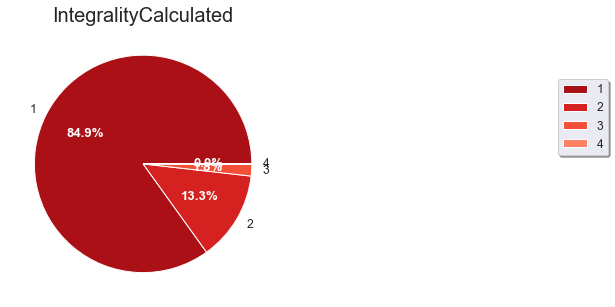

<Figure size 432x288 with 0 Axes>

In [203]:
##################################################################
############     GRÁFICOS VARIABLES CATEGÓRICAS     ##############
##################################################################
sns.set(font_scale= 1.1, palette="Reds_r")    #change font size
column = 'IntegralityCalculated'
fig = plt.figure(figsize=[10,5])      
ax = fig.add_subplot(111)
patches, text, _ = ax.pie(cat3[column].value_counts(), autopct='%.1f%%', textprops={'color':"w", 'weight':'bold'})     #autopct the number stablishes dec.
x = cat3[column].value_counts()
x = x.to_frame()
x[' Percentage % '] = x[column] / x[column].sum() * 100 
x = x.rename(columns={column: " count"})
x[' count'].plot.pie()
ax.set_title(column, fontsize= 20)                                   #adds variable's name
ax.legend(frameon=True, bbox_to_anchor=(2.3,0.9), borderaxespad=2., shadow=True)     #adds the legend
#     plt.savefig(column+"PieChart.jpg")      QUITAR LINEA DE COMENTARio sI SE DESEA GUARDAR
pylab.ylabel('')     #esta linea usa pylab library. QUITA COUNT
plt.show()
print()


plt.tight_layout()      #adjust subplot params so that subplots are nicely fit in the figure


In [34]:
#Underage customer
menores = clientespart[(clientespart['Age_max'] > 0) & (clientespart['Age_max'] < 18)]
menores_ant = pd.crosstab(menores['Age_max'],menores['TenureCalculated_max'],margins=True)

In [36]:
menores_ant.to_excel('../03. Exportaciones/menores_cross.xlsx', engine='xlsxwriter')

In [63]:
#Comprobaciones
clientespart["CheckProfitability"] = np.where(clientespart.Profitability_sum > clientespart.ProfitabilityCalculated, 1, 0)

In [64]:
clientespart["CheckProfitability"].value_counts()

1    92001
0    27580
Name: CheckProfitability, dtype: int64

In [65]:
#Profitability comparation
clientespart[(clientespart.Profitability_sum == clientespart.ProfitabilityCalculated)].shape

(91, 24)

In [66]:
#Profitability comparation
clientespart[(clientespart.Profitability_sum > clientespart.ProfitabilityCalculated)].shape

(92001, 24)

In [67]:
#Profitability comparation
clientespart[(clientespart.Profitability_sum < clientespart.ProfitabilityCalculated)].shape

(27489, 24)

In [71]:
#Claims and Claim cost comparation
clientespart[(clientespart.NClaims_sum >0) & (clientespart.ClaimCost_sum >0)].shape

(34308, 24)

In [72]:
#Claims and Claim cost comparation
clientespart[(clientespart.NClaims_sum >0) & (clientespart.ClaimCost_sum ==0)].shape

(2795, 24)

In [37]:
#Claims and Claim cost comparation
clientespart[(clientespart.NClaims_sum >0) & (clientespart.ClaimCost_sum <0)].shape

(229, 26)

In [38]:
#Claims and Claim cost comparation
clientespart[(clientespart.NClaims_sum >0) & (clientespart.ClaimCost_sum >0)& (clientespart.ClaimCost_sum <=500)].shape

(11008, 26)

In [39]:
#Claims and Claim cost comparation
clientespart[(clientespart.NClaims_sum >0) & (clientespart.ClaimCost_sum >500)& (clientespart.ClaimCost_sum <=1000)].shape

(6280, 26)

In [40]:
#Claims and Claim cost comparation
clientespart[(clientespart.NClaims_sum >0) & (clientespart.ClaimCost_sum >1000)& (clientespart.ClaimCost_sum <=2000)].shape

(7626, 26)

In [41]:
#Claims and Claim cost comparation
clientespart[(clientespart.NClaims_sum >0) & (clientespart.ClaimCost_sum >2000)& (clientespart.ClaimCost_sum <=3000)].shape

(3390, 26)

In [43]:
#Claims and Claim cost comparation
clientespart[(clientespart.NClaims_sum >0) & (clientespart.ClaimCost_sum >3000)].shape

(6004, 26)

# 4. Simulations and profiling

In [74]:
#clientespart.to_csv('../03. Exportaciones/clientespart4.csv', encoding='utf-8', index=False)

In [3]:
clientespart = pd.read_csv('../03. Exportaciones/clientespart4.csv')

In [5]:
clientespart.LossRatioCalculated_max.value_counts()

1    90491
4    18965
3     5180
2     4945
Name: LossRatioCalculated_max, dtype: int64

In [75]:
clientespart.isna().sum()

CustomerId                            0
Premium_sum                           0
Premium_min                           0
Premium_max                           0
PolicyId_count                        0
Age_max                              13
Tenure_max                            1
TenureCalculated_max                  0
Gender_first                       9287
Integrality_first                 24303
Claim_max                            60
NClaims_sum                           0
ClaimCost_sum                         0
Profitability_sum                     0
PersonalDataProtectionBool_max    22438
DirectDebit_max                       0
DirectDebit_min                       0
IntermediatedPolicy_max               0
EffectiveDate_min                     0
LossRatio_max                        60
LossRatioCalculated_max               0
ClientSegmentation_first              0
ProfitabilityCalculated               0
IntegralityCalculated                 0
IntegralityCalculated2                0


In [11]:
def describe_new(univariante):
    df1 = univariante.describe()
    df1.loc["range"] = df1.loc['max'] - df1.loc['min']
    return df1

## 4.1 Simulation and profiling 1

In [49]:
#####################################
#######   SIMULATION  A (1)  ########
#####################################
#Platinum
clientespart['SegmA1'] = np.where((clientespart['Premium_sum'] > 1000) & (clientespart['PolicyId_count'] >= 5), 'Platino', 'Plata')
clientespart[(clientespart['SegmA1'] == 'Platino')].shape

(2488, 29)

In [ ]:
clientespart['SegmA1'] = np.where((clientespart['Premium_sum'] > 1000) & (clientespart['PolicyId_count'] >= 5), 'Platino', 'Plata')
clientespart[(clientespart['SegmA1'] == 'Platino')].shape

clientespart['SegmA2'] = np.where((clientespart['SegmA1'] != 'Platino') & (clientespart['PolicyId_count'] >= 2) &\
                               (clientespart['Premium_sum'] > 600), 'Oro', 'Plata')
clientespart[(clientespart['SegmA2'] == 'Oro')].shape

conditions = [
    (clientespart['SegmA1'] == 'Platino'),
    (clientespart['SegmA2'] == 'Oro')]
choices = ['Platinum', 'Gold']
clientespart['SegmA'] = np.select(conditions, choices, default='Silver')

In [50]:
#Gold
clientespart['SegmA2'] = np.where((clientespart['SegmA1'] != 'Platino') & (clientespart['PolicyId_count'] >= 2) &\
                               (clientespart['Premium_sum'] > 600), 'Oro', 'Plata')
clientespart[(clientespart['SegmA2'] == 'Oro')].shape

(12163, 30)

In [51]:
#Creation of variable SegmA
conditions = [
    (clientespart['SegmA1'] == 'Platino'),
    (clientespart['SegmA2'] == 'Oro')]
choices = ['Platinum', 'Gold']
clientespart['SegmA'] = np.select(conditions, choices, default='Silver')

In [52]:
segmA_platinum = clientespart[(clientespart['SegmA'] == 'Platinum')].shape
segmA_gold = clientespart[(clientespart['SegmA'] == 'Gold')].shape
segmA_silver = clientespart[(clientespart['SegmA'] == 'Silver')].shape

print("Platinum shape:", segmA_platinum, "\nGold shape:", segmA_gold, "\nSilver shape:", segmA_silver)

Platinum shape: (2488, 31) 
Gold shape: (12163, 31) 
Silver shape: (104930, 31)


In [53]:
exp_segmA_platinum = clientespart[(clientespart['SegmA'] == 'Platinum')]
exp_segmA_gold = clientespart[(clientespart['SegmA'] == 'Gold')]
exp_segmA_silver = clientespart[(clientespart['SegmA'] == 'Silver')]

In [54]:
#Export Univariate analysis
export = describe_new(exp_segmA_platinum[["Age_max", "TenureCalculated_max", "Profitability_sum", "ProfitabilityCalculated",\
                                          'ClaimCost_sum', 'Premium_sum', 'PolicyId_count','IntegralityCalculated',\
                                          'DirectDebit_max', 'IntermediatedPolicy_max', 'PersonalDataProtectionBool_max','LossRatio_max']])
export.to_excel('../03. Exportaciones/exp_segmA_platinum.xlsx', engine='xlsxwriter') 

In [55]:
export = describe_new(exp_segmA_gold[["Age_max", "TenureCalculated_max", "Profitability_sum", "ProfitabilityCalculated",\
                                      'ClaimCost_sum', 'Premium_sum', 'PolicyId_count','IntegralityCalculated',\
                                      'DirectDebit_max', 'IntermediatedPolicy_max', 'PersonalDataProtectionBool_max','LossRatio_max']])
export.to_excel('../03. Exportaciones/exp_segmA_gold.xlsx', engine='xlsxwriter') 

In [56]:
export = describe_new(exp_segmA_silver[["Age_max", "TenureCalculated_max", "Profitability_sum", "ProfitabilityCalculated",\
                                        'ClaimCost_sum', 'Premium_sum', 'PolicyId_count','IntegralityCalculated',\
                                        'DirectDebit_max', 'IntermediatedPolicy_max', 'PersonalDataProtectionBool_max','LossRatio_max']])
export.to_excel('../03. Exportaciones/exp_segmA_silver.xlsx', engine='xlsxwriter') 

## 4.2 Simulation and profiling 2

In [121]:
clientespart.columns

Index(['CustomerId', 'Premium_sum', 'Premium_min', 'Premium_max',
       'PolicyId_count', 'Age_max', 'Tenure_max', 'TenureCalculated_max',
       'Gender_first', 'Integrality_first', 'Claim_max', 'NClaims_sum',
       'ClaimCost_sum', 'Profitability_sum', 'PersonalDataProtectionBool_max',
       'DirectDebit_max', 'DirectDebit_min', 'IntermediatedPolicy_max',
       'EffectiveDate_min', 'LossRatio_max', 'ProfitabilityCalculated',
       'IntegralityCalculated', 'ContractChannel_first', 'SegmA1', 'SegmA2',
       'SegmA'],
      dtype='object')

In [57]:
#####################################
#######   SIMULATION  B (2)  ########
#####################################
#Platinum
clientespart['SegmB1'] = np.where((clientespart['Premium_sum'] > 700) & (clientespart['IntegralityCalculated'] >= 3), 'Platino', 'Plata')
clientespart[(clientespart['SegmB1'] == 'Platino')].shape

(1759, 32)

In [58]:
#Gold
clientespart['SegmB2'] = np.where((clientespart['SegmB1'] != 'Platino') & (clientespart['IntegralityCalculated'] >= 2) &\
                               (clientespart['Premium_sum'] > 500), 'Oro', 'Plata')
clientespart[(clientespart['SegmB2'] == 'Oro')].shape

(9303, 33)

In [59]:
#Creation of variable SegmB
conditions = [
    (clientespart['SegmB1'] == 'Platino'),
    (clientespart['SegmB2'] == 'Oro')]
choices = ['Platinum', 'Gold']
clientespart['SegmB'] = np.select(conditions, choices, default='Silver')

In [60]:
segmB_platinum = clientespart[(clientespart['SegmB'] == 'Platinum')].shape
segmB_gold = clientespart[(clientespart['SegmB'] == 'Gold')].shape
segmB_silver = clientespart[(clientespart['SegmB'] == 'Silver')].shape

print("Platinum shape:", segmB_platinum, "\nGold shape:", segmB_gold, "\nSilver shape:", segmB_silver)

Platinum shape: (1759, 34) 
Gold shape: (9303, 34) 
Silver shape: (108519, 34)


In [61]:
exp_segmB_platinum = clientespart[(clientespart['SegmB'] == 'Platinum')]
exp_segmB_gold = clientespart[(clientespart['SegmB'] == 'Gold')]
exp_segmB_silver = clientespart[(clientespart['SegmB'] == 'Silver')]

In [62]:
#Export Univariate analysis
export = describe_new(exp_segmB_platinum[["Age_max", "TenureCalculated_max", "Profitability_sum", "ProfitabilityCalculated",\
                                          'ClaimCost_sum', 'Premium_sum', 'PolicyId_count','IntegralityCalculated',\
                                          'DirectDebit_max', 'IntermediatedPolicy_max', 'PersonalDataProtectionBool_max','LossRatio_max']])
export.to_excel('../03. Exportaciones/exp_segmB_platinum.xlsx', engine='xlsxwriter') 

In [63]:
export = describe_new(exp_segmB_gold[["Age_max", "TenureCalculated_max", "Profitability_sum", "ProfitabilityCalculated",\
                                      'ClaimCost_sum', 'Premium_sum', 'PolicyId_count','IntegralityCalculated',\
                                      'DirectDebit_max', 'IntermediatedPolicy_max', 'PersonalDataProtectionBool_max','LossRatio_max']])
export.to_excel('../03. Exportaciones/exp_segmB_gold.xlsx', engine='xlsxwriter') 

In [64]:
export = describe_new(exp_segmB_silver[["Age_max", "TenureCalculated_max", "Profitability_sum", "ProfitabilityCalculated",\
                                        'ClaimCost_sum', 'Premium_sum', 'PolicyId_count','IntegralityCalculated',\
                                        'DirectDebit_max', 'IntermediatedPolicy_max', 'PersonalDataProtectionBool_max','LossRatio_max']])
export.to_excel('../03. Exportaciones/exp_segmB_silver.xlsx', engine='xlsxwriter') 

## 4.3 Simulation and profiling 3

In [71]:
clientespart.columns

Index(['CustomerId', 'Premium_sum', 'Premium_min', 'Premium_max',
       'PolicyId_count', 'Age_max', 'Tenure_max', 'TenureCalculated_max',
       'Gender_first', 'Integrality_first', 'Claim_max', 'NClaims_sum',
       'ClaimCost_sum', 'Profitability_sum', 'PersonalDataProtectionBool_max',
       'DirectDebit_max', 'DirectDebit_min', 'IntermediatedPolicy_max',
       'ProfitabilityCalculated', 'IntegralityCalculated',
       'ContractChannel_first', 'SegmA1', 'SegmA2', 'SegmA', 'SegmB2',
       'SegmB1', 'SegmB'],
      dtype='object')

In [65]:
#####################################
#######   SIMULATION  C (3)  ########
#####################################
#Platinum
clientespart['SegmC1'] = np.where((clientespart['Premium_sum'] > 1250) & (clientespart['TenureCalculated_max'] >= 60), 'Platino', 'Plata')
clientespart[(clientespart['SegmC1'] == 'Platino')].shape

(2937, 35)

In [66]:
#Gold
clientespart['SegmC2'] = np.where((clientespart['SegmC1'] != 'Platino') & (clientespart['TenureCalculated_max'] >= 48) &\
                               (clientespart['Premium_sum'] > 600), 'Oro', 'Plata')
clientespart[(clientespart['SegmC2'] == 'Oro')].shape

(8427, 36)

In [67]:
#Creation of variable SegmB
conditions = [
    (clientespart['SegmC1'] == 'Platino'),
    (clientespart['SegmC2'] == 'Oro')]
choices = ['Platinum', 'Gold']
clientespart['SegmC'] = np.select(conditions, choices, default='Silver')

In [68]:
segmC_platinum = clientespart[(clientespart['SegmC'] == 'Platinum')].shape
segmC_gold = clientespart[(clientespart['SegmC'] == 'Gold')].shape
segmC_silver = clientespart[(clientespart['SegmC'] == 'Silver')].shape

print("Platinum shape:", segmC_platinum, "\nGold shape:", segmC_gold, "\nSilver shape:", segmC_silver)

Platinum shape: (2937, 37) 
Gold shape: (8427, 37) 
Silver shape: (108217, 37)


In [69]:
exp_segmC_platinum = clientespart[(clientespart['SegmC'] == 'Platinum')]
exp_segmC_gold = clientespart[(clientespart['SegmC'] == 'Gold')]
exp_segmC_silver = clientespart[(clientespart['SegmC'] == 'Silver')]

In [70]:
#Export Univariate analysis
export = describe_new(exp_segmC_platinum[["Age_max", "TenureCalculated_max", "Profitability_sum", "ProfitabilityCalculated",\
                                          'ClaimCost_sum', 'Premium_sum', 'PolicyId_count','IntegralityCalculated',\
                                          'DirectDebit_max', 'IntermediatedPolicy_max', 'PersonalDataProtectionBool_max','LossRatio_max']])
export.to_excel('../03. Exportaciones/exp_segmC_platinum.xlsx', engine='xlsxwriter') 

In [71]:
export = describe_new(exp_segmC_gold[["Age_max", "TenureCalculated_max", "Profitability_sum", "ProfitabilityCalculated",\
                                      'ClaimCost_sum', 'Premium_sum', 'PolicyId_count','IntegralityCalculated',\
                                      'DirectDebit_max', 'IntermediatedPolicy_max', 'PersonalDataProtectionBool_max','LossRatio_max']])
export.to_excel('../03. Exportaciones/exp_segmC_gold.xlsx', engine='xlsxwriter') 

In [72]:
export = describe_new(exp_segmC_silver[["Age_max", "TenureCalculated_max", "Profitability_sum", "ProfitabilityCalculated",\
                                        'ClaimCost_sum', 'Premium_sum', 'PolicyId_count','IntegralityCalculated',\
                                        'DirectDebit_max', 'IntermediatedPolicy_max', 'PersonalDataProtectionBool_max','LossRatio_max']])
export.to_excel('../03. Exportaciones/exp_segmC_silver.xlsx', engine='xlsxwriter') 

## 4.4 Simulation and profiling 4

In [71]:
clientespart.columns

Index(['CustomerId', 'Premium_sum', 'Premium_min', 'Premium_max',
       'PolicyId_count', 'Age_max', 'Tenure_max', 'TenureCalculated_max',
       'Gender_first', 'Integrality_first', 'Claim_max', 'NClaims_sum',
       'ClaimCost_sum', 'Profitability_sum', 'PersonalDataProtectionBool_max',
       'DirectDebit_max', 'DirectDebit_min', 'IntermediatedPolicy_max',
       'ProfitabilityCalculated', 'IntegralityCalculated',
       'ContractChannel_first', 'SegmA1', 'SegmA2', 'SegmA', 'SegmB2',
       'SegmB1', 'SegmB'],
      dtype='object')

In [73]:
#####################################
#######   SIMULATION  D (4)  ########
#####################################
#Platinum
clientespart['SegmD1'] = np.where((clientespart['Profitability_sum'] > 3500) & (clientespart['TenureCalculated_max'] >= 60), 'Platino', 'Plata')
clientespart[(clientespart['SegmD1'] == 'Platino')].shape

(3012, 38)

In [74]:
#Gold
clientespart['SegmD2'] = np.where((clientespart['SegmD1'] != 'Platino') & (clientespart['TenureCalculated_max'] >= 48) &\
                               (clientespart['Profitability_sum'] > 1700), 'Oro', 'Plata')
clientespart[(clientespart['SegmD2'] == 'Oro')].shape

(8665, 39)

In [75]:
#Creation of variable SegmD
conditions = [
    (clientespart['SegmD1'] == 'Platino'),
    (clientespart['SegmD2'] == 'Oro')]
choices = ['Platinum', 'Gold']
clientespart['SegmD'] = np.select(conditions, choices, default='Silver')

In [76]:
segmD_platinum = clientespart[(clientespart['SegmD'] == 'Platinum')].shape
segmD_gold = clientespart[(clientespart['SegmD'] == 'Gold')].shape
segmD_silver = clientespart[(clientespart['SegmD'] == 'Silver')].shape

print("Platinum shape:", segmD_platinum, "\nGold shape:", segmD_gold, "\nSilver shape:", segmD_silver)

Platinum shape: (3012, 40) 
Gold shape: (8665, 40) 
Silver shape: (107904, 40)


In [77]:
exp_segmD_platinum = clientespart[(clientespart['SegmD'] == 'Platinum')]
exp_segmD_gold = clientespart[(clientespart['SegmD'] == 'Gold')]
exp_segmD_silver = clientespart[(clientespart['SegmD'] == 'Silver')]

In [78]:
#Export Univariate analysis
export = describe_new(exp_segmD_platinum[["Age_max", "TenureCalculated_max", "Profitability_sum", "ProfitabilityCalculated",\
                                          'ClaimCost_sum', 'Premium_sum', 'PolicyId_count','IntegralityCalculated',\
                                          'DirectDebit_max', 'IntermediatedPolicy_max', 'PersonalDataProtectionBool_max','LossRatio_max']])
export.to_excel('../03. Exportaciones/exp_segmD_platinum.xlsx', engine='xlsxwriter') 

In [79]:
export = describe_new(exp_segmD_gold[["Age_max", "TenureCalculated_max", "Profitability_sum", "ProfitabilityCalculated",\
                                      'ClaimCost_sum', 'Premium_sum', 'PolicyId_count','IntegralityCalculated',\
                                      'DirectDebit_max', 'IntermediatedPolicy_max', 'PersonalDataProtectionBool_max','LossRatio_max']])
export.to_excel('../03. Exportaciones/exp_segmD_gold.xlsx', engine='xlsxwriter') 

In [80]:
export = describe_new(exp_segmD_silver[["Age_max", "TenureCalculated_max", "Profitability_sum", "ProfitabilityCalculated",\
                                        'ClaimCost_sum', 'Premium_sum', 'PolicyId_count','IntegralityCalculated',\
                                        'DirectDebit_max', 'IntermediatedPolicy_max', 'PersonalDataProtectionBool_max','LossRatio_max']])
export.to_excel('../03. Exportaciones/exp_segmD_silver.xlsx', engine='xlsxwriter') 

## 4.5 Simulation and profiling 5

In [74]:
clientespart.columns

Index(['CustomerId', 'Premium_sum', 'Premium_min', 'Premium_max',
       'PolicyId_count', 'Age_max', 'Tenure_max', 'TenureCalculated_max',
       'Gender_first', 'Integrality_first', 'Claim_max', 'NClaims_sum',
       'ClaimCost_sum', 'Profitability_sum', 'PersonalDataProtectionBool_max',
       'DirectDebit_max', 'DirectDebit_min', 'IntermediatedPolicy_max',
       'EffectiveDate_min', 'LossRatio_max', 'ProfitabilityCalculated',
       'IntegralityCalculated', 'ContractChannel_first', 'CheckProfitability'],
      dtype='object')

In [81]:
#####################################
#######   SIMULATION  E (5)  ########
#####################################
#Platinum
clientespart['SegmE1'] = np.where((clientespart['Premium_max'] > 500) & (clientespart['TenureCalculated_max'] >= 60) & (clientespart['PolicyId_count'] >= 2), 'Platino', 'Plata')
clientespart[(clientespart['SegmE1'] == 'Platino')].shape

(3806, 41)

In [82]:
#Gold
clientespart['SegmE2'] = np.where((clientespart['SegmE1'] != 'Platino') & (clientespart['Premium_max'] > 250) & (clientespart['TenureCalculated_max'] >= 24) & (clientespart['PolicyId_count'] >= 2), 'Oro', 'Plata')
clientespart[(clientespart['SegmE2'] == 'Oro')].shape

(15367, 42)

In [83]:
#Creation of variable SegmD
conditions = [
    (clientespart['SegmE1'] == 'Platino'),
    (clientespart['SegmE2'] == 'Oro')]
choices = ['Platinum', 'Gold']
clientespart['SegmE'] = np.select(conditions, choices, default='Silver')

In [84]:
segmE_platinum = clientespart[(clientespart['SegmE'] == 'Platinum')].shape
segmE_gold = clientespart[(clientespart['SegmE'] == 'Gold')].shape
segmE_silver = clientespart[(clientespart['SegmE'] == 'Silver')].shape

print("Platinum shape:", segmE_platinum, "\nGold shape:", segmE_gold, "\nSilver shape:", segmE_silver)

Platinum shape: (3806, 43) 
Gold shape: (15367, 43) 
Silver shape: (100408, 43)


In [85]:
exp_segmE_platinum = clientespart[(clientespart['SegmE'] == 'Platinum')]
exp_segmE_gold = clientespart[(clientespart['SegmE'] == 'Gold')]
exp_segmE_silver = clientespart[(clientespart['SegmE'] == 'Silver')]

In [86]:
#Export Univariate analysis
export = describe_new(exp_segmE_platinum[["Age_max", "TenureCalculated_max", "Profitability_sum", "ProfitabilityCalculated",\
                                          'ClaimCost_sum', 'Premium_sum', 'PolicyId_count','IntegralityCalculated',\
                                          'DirectDebit_max', 'IntermediatedPolicy_max', 'PersonalDataProtectionBool_max','LossRatio_max']])
export.to_excel('../03. Exportaciones/exp_segmE_platinum.xlsx', engine='xlsxwriter') 

In [87]:
export = describe_new(exp_segmE_gold[["Age_max", "TenureCalculated_max", "Profitability_sum", "ProfitabilityCalculated",\
                                      'ClaimCost_sum', 'Premium_sum', 'PolicyId_count','IntegralityCalculated',\
                                      'DirectDebit_max', 'IntermediatedPolicy_max', 'PersonalDataProtectionBool_max','LossRatio_max']])
export.to_excel('../03. Exportaciones/exp_segmE_gold.xlsx', engine='xlsxwriter') 

In [88]:
export = describe_new(exp_segmE_silver[["Age_max", "TenureCalculated_max", "Profitability_sum", "ProfitabilityCalculated",\
                                        'ClaimCost_sum', 'Premium_sum', 'PolicyId_count','IntegralityCalculated',\
                                        'DirectDebit_max', 'IntermediatedPolicy_max', 'PersonalDataProtectionBool_max','LossRatio_max']])
export.to_excel('../03. Exportaciones/exp_segmE_silver.xlsx', engine='xlsxwriter') 

## 4.6 Simulation and profiling 5a

In [74]:
clientespart.columns

Index(['CustomerId', 'Premium_sum', 'Premium_min', 'Premium_max',
       'PolicyId_count', 'Age_max', 'Tenure_max', 'TenureCalculated_max',
       'Gender_first', 'Integrality_first', 'Claim_max', 'NClaims_sum',
       'ClaimCost_sum', 'Profitability_sum', 'PersonalDataProtectionBool_max',
       'DirectDebit_max', 'DirectDebit_min', 'IntermediatedPolicy_max',
       'EffectiveDate_min', 'LossRatio_max', 'ProfitabilityCalculated',
       'IntegralityCalculated', 'ContractChannel_first', 'CheckProfitability'],
      dtype='object')

In [91]:
#####################################
#######   SIMULATION  Ea (6)  ########
#####################################
#Platinum
clientespart['SegmEa1'] = np.where((clientespart['Premium_max'] > 600) & (clientespart['TenureCalculated_max'] >= 36) & (clientespart['PolicyId_count'] >= 3), 'Platino', 'Plata')
clientespart[(clientespart['SegmEa1'] == 'Platino')].shape

(2451, 45)

In [92]:
#Gold
clientespart['SegmEa2'] = np.where((clientespart['SegmEa1'] != 'Platino') & (clientespart['Premium_max'] > 300) & (clientespart['TenureCalculated_max'] >= 24) & (clientespart['PolicyId_count'] >= 2), 'Oro', 'Plata')
clientespart[(clientespart['SegmEa2'] == 'Oro')].shape

(12337, 45)

In [93]:
#Creation of variable SegmEa
conditions = [
    (clientespart['SegmEa1'] == 'Platino'),
    (clientespart['SegmEa2'] == 'Oro')]
choices = ['Platinum', 'Gold']
clientespart['SegmEa'] = np.select(conditions, choices, default='Silver')

In [94]:
segmEa_platinum = clientespart[(clientespart['SegmEa'] == 'Platinum')].shape
segmEa_gold = clientespart[(clientespart['SegmEa'] == 'Gold')].shape
segmEa_silver = clientespart[(clientespart['SegmEa'] == 'Silver')].shape

print("Platinum shape:", segmEa_platinum, "\nGold shape:", segmEa_gold, "\nSilver shape:", segmEa_silver)

Platinum shape: (2451, 46) 
Gold shape: (12337, 46) 
Silver shape: (104793, 46)


In [95]:
exp_segmEa_platinum = clientespart[(clientespart['SegmEa'] == 'Platinum')]
exp_segmEa_gold = clientespart[(clientespart['SegmEa'] == 'Gold')]
exp_segmEa_silver = clientespart[(clientespart['SegmEa'] == 'Silver')]

In [96]:
#Export Univariate analysis
export = describe_new(exp_segmEa_platinum[["Age_max", "TenureCalculated_max", "Profitability_sum", "ProfitabilityCalculated",\
                                          'ClaimCost_sum', 'Premium_sum', 'PolicyId_count','IntegralityCalculated2',\
                                          'DirectDebit_max', 'IntermediatedPolicy_max', 'PersonalDataProtectionBool_max','LossRatio_max']])
export.to_excel('../03. Exportaciones/exp_segmEa_platinum.xlsx', engine='xlsxwriter') 

In [97]:
export = describe_new(exp_segmEa_gold[["Age_max", "TenureCalculated_max", "Profitability_sum", "ProfitabilityCalculated",\
                                      'ClaimCost_sum', 'Premium_sum', 'PolicyId_count','IntegralityCalculated2',\
                                      'DirectDebit_max', 'IntermediatedPolicy_max', 'PersonalDataProtectionBool_max','LossRatio_max']])
export.to_excel('../03. Exportaciones/exp_segmEa_gold.xlsx', engine='xlsxwriter') 

In [98]:
export = describe_new(exp_segmEa_silver[["Age_max", "TenureCalculated_max", "Profitability_sum", "ProfitabilityCalculated",\
                                        'ClaimCost_sum', 'Premium_sum', 'PolicyId_count','IntegralityCalculated2',\
                                        'DirectDebit_max', 'IntermediatedPolicy_max', 'PersonalDataProtectionBool_max','LossRatio_max']])
export.to_excel('../03. Exportaciones/exp_segmEa_silver.xlsx', engine='xlsxwriter') 

## 4.7 Simulation and profiling 5b

In [103]:
clientespart.columns

Index(['CustomerId', 'Premium_sum', 'Premium_min', 'Premium_max',
       'PolicyId_count', 'Age_max', 'Tenure_max', 'TenureCalculated_max',
       'Gender_first', 'Integrality_first', 'Claim_max', 'NClaims_sum',
       'ClaimCost_sum', 'Profitability_sum', 'PersonalDataProtectionBool_max',
       'DirectDebit_max', 'DirectDebit_min', 'IntermediatedPolicy_max',
       'EffectiveDate_min', 'LossRatio_max', 'ProfitabilityCalculated',
       'IntegralityCalculated', 'IntegralityCalculated2',
       'ContractChannel_first', 'SegmEa1', 'SegmEa2', 'SegmEa'],
      dtype='object')

In [99]:
#####################################
#######   SIMULATION  Eb (7)  ########
#####################################
#Platinum
clientespart['SegmEb1'] = np.where((clientespart['Premium_max'] > 700) & (clientespart['TenureCalculated_max'] >= 24) & (clientespart['PolicyId_count'] >= 4), 'Platino', 'Plata')
clientespart[(clientespart['SegmEb1'] == 'Platino')].shape

(1363, 47)

In [100]:
#Gold
clientespart['SegmEb2'] = np.where((clientespart['SegmEb1'] != 'Platino') & (clientespart['Premium_max'] > 350) & (clientespart['TenureCalculated_max'] >= 12) & (clientespart['PolicyId_count'] >= 2), 'Oro', 'Plata')
clientespart[(clientespart['SegmEb2'] == 'Oro')].shape

(10933, 48)

In [101]:
#Creation of variable SegmEb
conditions = [
    (clientespart['SegmEb1'] == 'Platino'),
    (clientespart['SegmEb2'] == 'Oro')]
choices = ['Platinum', 'Gold']
clientespart['SegmEb'] = np.select(conditions, choices, default='Silver')

In [102]:
segmEb_platinum = clientespart[(clientespart['SegmEb'] == 'Platinum')].shape
segmEb_gold = clientespart[(clientespart['SegmEb'] == 'Gold')].shape
segmEb_silver = clientespart[(clientespart['SegmEb'] == 'Silver')].shape

print("Platinum shape:", segmEb_platinum, "\nGold shape:", segmEb_gold, "\nSilver shape:", segmEb_silver)

Platinum shape: (1363, 49) 
Gold shape: (10933, 49) 
Silver shape: (107285, 49)


In [103]:
exp_segmEb_platinum = clientespart[(clientespart['SegmEb'] == 'Platinum')]
exp_segmEb_gold = clientespart[(clientespart['SegmEb'] == 'Gold')]
exp_segmEb_silver = clientespart[(clientespart['SegmEb'] == 'Silver')]

In [104]:
#Export Univariate analysis
export = describe_new(exp_segmEb_platinum[["Age_max", "TenureCalculated_max", "Profitability_sum", "ProfitabilityCalculated",\
                                          'ClaimCost_sum', 'Premium_sum', 'PolicyId_count','IntegralityCalculated2',\
                                          'DirectDebit_max', 'IntermediatedPolicy_max', 'PersonalDataProtectionBool_max','LossRatio_max']])
export.to_excel('../03. Exportaciones/exp_segmEb_platinum.xlsx', engine='xlsxwriter') 

In [105]:
export = describe_new(exp_segmEb_gold[["Age_max", "TenureCalculated_max", "Profitability_sum", "ProfitabilityCalculated",\
                                      'ClaimCost_sum', 'Premium_sum', 'PolicyId_count','IntegralityCalculated2',\
                                      'DirectDebit_max', 'IntermediatedPolicy_max', 'PersonalDataProtectionBool_max','LossRatio_max']])
export.to_excel('../03. Exportaciones/exp_segmEb_gold.xlsx', engine='xlsxwriter') 

In [106]:
export = describe_new(exp_segmEb_silver[["Age_max", "TenureCalculated_max", "Profitability_sum", "ProfitabilityCalculated",\
                                        'ClaimCost_sum', 'Premium_sum', 'PolicyId_count','IntegralityCalculated2',\
                                        'DirectDebit_max', 'IntermediatedPolicy_max', 'PersonalDataProtectionBool_max','LossRatio_max']])
export.to_excel('../03. Exportaciones/exp_segmEb_silver.xlsx', engine='xlsxwriter') 

# 4.8 Simulation and profiling 6

In [93]:
clientespart.columns

Index(['CustomerId', 'Premium_sum', 'Premium_min', 'Premium_max',
       'PolicyId_count', 'Age_max', 'Tenure_max', 'TenureCalculated_max',
       'Gender_first', 'Integrality_first', 'Claim_max', 'NClaims_sum',
       'ClaimCost_sum', 'Profitability_sum', 'PersonalDataProtectionBool_max',
       'DirectDebit_max', 'DirectDebit_min', 'IntermediatedPolicy_max',
       'EffectiveDate_min', 'LossRatio_max', 'ProfitabilityCalculated',
       'IntegralityCalculated', 'ContractChannel_first', 'CheckProfitability',
       'SegmE1', 'SegmE2', 'SegmE'],
      dtype='object')

In [107]:
#####################################
#######   SIMULATION  F (8)  ########
#####################################
#Platinum
clientespart['SegmF1'] = np.where((clientespart['Premium_max'] > 500) & (clientespart['TenureCalculated_max'] >= 60) & (clientespart['IntegralityCalculated'] >=2 ), 'Platino', 'Plata')
clientespart[(clientespart['SegmF1'] == 'Platino')].shape

(2852, 50)

In [108]:
#Gold
clientespart['SegmF2'] = np.where((clientespart['SegmF1'] != 'Platino') & (clientespart['Premium_max'] > 300) & (clientespart['TenureCalculated_max'] >= 24) & (clientespart['IntegralityCalculated'] >=2), 'Oro', 'Plata')
clientespart[(clientespart['SegmF2'] == 'Oro')].shape

(6527, 51)

In [109]:
#Creation of variable SegmF
conditions = [
    (clientespart['SegmF1'] == 'Platino'),
    (clientespart['SegmF2'] == 'Oro')]
choices = ['Platinum', 'Gold']
clientespart['SegmF'] = np.select(conditions, choices, default='Silver')

In [110]:
segmF_platinum = clientespart[(clientespart['SegmF'] == 'Platinum')].shape
segmF_gold = clientespart[(clientespart['SegmF'] == 'Gold')].shape
segmF_silver = clientespart[(clientespart['SegmF'] == 'Silver')].shape

print("Platinum shape:", segmF_platinum, "\nGold shape:", segmF_gold, "\nSilver shape:", segmF_silver)

Platinum shape: (2852, 52) 
Gold shape: (6527, 52) 
Silver shape: (110202, 52)


In [111]:
exp_segmF_platinum = clientespart[(clientespart['SegmF'] == 'Platinum')]
exp_segmF_gold = clientespart[(clientespart['SegmF'] == 'Gold')]
exp_segmF_silver = clientespart[(clientespart['SegmF'] == 'Silver')]

In [112]:
#Export Univariate analysis
export = describe_new(exp_segmF_platinum[["Age_max", "TenureCalculated_max", "Profitability_sum", "ProfitabilityCalculated",\
                                          'ClaimCost_sum', 'Premium_sum', 'PolicyId_count','IntegralityCalculated',\
                                          'DirectDebit_max', 'IntermediatedPolicy_max', 'PersonalDataProtectionBool_max','LossRatio_max']])
export.to_excel('../03. Exportaciones/exp_segmF_platinum.xlsx', engine='xlsxwriter') 

In [113]:
export = describe_new(exp_segmF_gold[["Age_max", "TenureCalculated_max", "Profitability_sum", "ProfitabilityCalculated",\
                                      'ClaimCost_sum', 'Premium_sum', 'PolicyId_count','IntegralityCalculated',\
                                      'DirectDebit_max', 'IntermediatedPolicy_max', 'PersonalDataProtectionBool_max','LossRatio_max']])
export.to_excel('../03. Exportaciones/exp_segmF_gold.xlsx', engine='xlsxwriter') 

In [114]:
export = describe_new(exp_segmF_silver[["Age_max", "TenureCalculated_max", "Profitability_sum", "ProfitabilityCalculated",\
                                        'ClaimCost_sum', 'Premium_sum', 'PolicyId_count','IntegralityCalculated',\
                                        'DirectDebit_max', 'IntermediatedPolicy_max', 'PersonalDataProtectionBool_max','LossRatio_max']])
export.to_excel('../03. Exportaciones/exp_segmF_silver.xlsx', engine='xlsxwriter') 

# 4.9 Simulation and profiling 6a

In [17]:
clientespart.columns

Index(['CustomerId', 'Premium_sum', 'Premium_min', 'Premium_max',
       'PolicyId_count', 'Age_max', 'Tenure_max', 'TenureCalculated_max',
       'Gender_first', 'Integrality_first', 'Claim_max', 'NClaims_sum',
       'ClaimCost_sum', 'Profitability_sum', 'PersonalDataProtectionBool_max',
       'DirectDebit_max', 'DirectDebit_min', 'IntermediatedPolicy_max',
       'EffectiveDate_min', 'LossRatio_max', 'ProfitabilityCalculated',
       'IntegralityCalculated', 'IntegralityCalculated2',
       'ContractChannel_first', 'SegmFb1', 'SegmFb2', 'SegmFb', 'SegmEa1',
       'SegmEb1', 'SegmEb2', 'SegmFa1', 'SegmFa2'],
      dtype='object')

In [115]:
######################################
#######   SIMULATION  Fa (9)  ########
######################################
#Platinum
clientespart['SegmFa1'] = np.where((clientespart['Premium_max'] > 650) & (clientespart['TenureCalculated_max'] >= 24) & (clientespart['IntegralityCalculated2'] >=2 ), 'Platino', 'Plata')
clientespart[(clientespart['SegmFa1'] == 'Platino')].shape

(2408, 53)

In [116]:
#Gold
clientespart['SegmFa2'] = np.where((clientespart['SegmFa1'] != 'Platino') & (clientespart['Premium_max'] > 325) & (clientespart['TenureCalculated_max'] >= 12) & (clientespart['PolicyId_count'] >=2), 'Oro', 'Plata')
clientespart[(clientespart['SegmFa2'] == 'Oro')].shape

(11760, 54)

In [117]:
#Creation of variable SegmFa
conditions = [
    (clientespart['SegmFa1'] == 'Platino'),
    (clientespart['SegmFa2'] == 'Oro')]
choices = ['Platinum', 'Gold']
clientespart['SegmFa'] = np.select(conditions, choices, default='Silver')

In [118]:
segmFa_platinum = clientespart[(clientespart['SegmFa'] == 'Platinum')].shape
segmFa_gold = clientespart[(clientespart['SegmFa'] == 'Gold')].shape
segmFa_silver = clientespart[(clientespart['SegmFa'] == 'Silver')].shape

print("Platinum shape:", segmFa_platinum, "\nGold shape:", segmFa_gold, "\nSilver shape:", segmFa_silver)

Platinum shape: (2408, 55) 
Gold shape: (11760, 55) 
Silver shape: (105413, 55)


In [119]:
exp_segmFa_platinum = clientespart[(clientespart['SegmFa'] == 'Platinum')]
exp_segmFa_gold = clientespart[(clientespart['SegmFa'] == 'Gold')]
exp_segmFa_silver = clientespart[(clientespart['SegmFa'] == 'Silver')]

In [120]:
#Export Univariate analysis
export = describe_new(exp_segmFa_platinum[["Age_max", "TenureCalculated_max", "Profitability_sum", "ProfitabilityCalculated",\
                                          'ClaimCost_sum', 'Premium_sum', 'PolicyId_count','IntegralityCalculated2',\
                                          'DirectDebit_max', 'IntermediatedPolicy_max', 'PersonalDataProtectionBool_max','LossRatio_max']])
export.to_excel('../03. Exportaciones/exp_segmFa_platinum.xlsx', engine='xlsxwriter') 

In [121]:
export = describe_new(exp_segmFa_gold[["Age_max", "TenureCalculated_max", "Profitability_sum", "ProfitabilityCalculated",\
                                      'ClaimCost_sum', 'Premium_sum', 'PolicyId_count','IntegralityCalculated2',\
                                      'DirectDebit_max', 'IntermediatedPolicy_max', 'PersonalDataProtectionBool_max','LossRatio_max']])
export.to_excel('../03. Exportaciones/exp_segmFa_gold.xlsx', engine='xlsxwriter') 

In [122]:
export = describe_new(exp_segmFa_silver[["Age_max", "TenureCalculated_max", "Profitability_sum", "ProfitabilityCalculated",\
                                        'ClaimCost_sum', 'Premium_sum', 'PolicyId_count','IntegralityCalculated2',\
                                        'DirectDebit_max', 'IntermediatedPolicy_max', 'PersonalDataProtectionBool_max','LossRatio_max']])
export.to_excel('../03. Exportaciones/exp_segmFa_silver.xlsx', engine='xlsxwriter') 

# 4.10 Simulation and profiling 6b

In [28]:
clientespart.columns

Index(['CustomerId', 'Premium_sum', 'Premium_min', 'Premium_max',
       'PolicyId_count', 'Age_max', 'Tenure_max', 'TenureCalculated_max',
       'Gender_first', 'Integrality_first', 'Claim_max', 'NClaims_sum',
       'ClaimCost_sum', 'Profitability_sum', 'PersonalDataProtectionBool_max',
       'DirectDebit_max', 'DirectDebit_min', 'IntermediatedPolicy_max',
       'EffectiveDate_min', 'LossRatio_max', 'ProfitabilityCalculated',
       'IntegralityCalculated', 'IntegralityCalculated2',
       'ContractChannel_first', 'SegmFa1', 'SegmFa2', 'SegmFa'],
      dtype='object')

In [123]:
######################################
#######   SIMULATION  Fb (10)  ########
######################################
#Platinum
clientespart['SegmFb1'] = np.where((clientespart['Premium_max'] > 700) & (clientespart['TenureCalculated_max'] >= 24) & (clientespart['IntegralityCalculated2'] >=2 ), 'Platino', 'Plata')
clientespart[(clientespart['SegmFb1'] == 'Platino')].shape

(2069, 56)

In [124]:
#Gold
clientespart['SegmFb2'] = np.where((clientespart['SegmFb1'] != 'Platino') & (clientespart['Premium_max'] > 350) & (clientespart['TenureCalculated_max'] >= 12) & (clientespart['PolicyId_count'] >=2), 'Oro', 'Plata')
clientespart[(clientespart['SegmFb2'] == 'Oro')].shape

(10227, 57)

In [125]:
#Creation of variable SegmFb
conditions = [
    (clientespart['SegmFb1'] == 'Platino'),
    (clientespart['SegmFb2'] == 'Oro')]
choices = ['Platinum', 'Gold']
clientespart['SegmFb'] = np.select(conditions, choices, default='Silver')

In [126]:
segmFb_platinum = clientespart[(clientespart['SegmFb'] == 'Platinum')].shape
segmFb_gold = clientespart[(clientespart['SegmFb'] == 'Gold')].shape
segmFb_silver = clientespart[(clientespart['SegmFb'] == 'Silver')].shape

print("Platinum shape:", segmFb_platinum, "\nGold shape:", segmFb_gold, "\nSilver shape:", segmFb_silver)

Platinum shape: (2069, 58) 
Gold shape: (10227, 58) 
Silver shape: (107285, 58)


In [127]:
exp_segmFb_platinum = clientespart[(clientespart['SegmFb'] == 'Platinum')]
exp_segmFb_gold = clientespart[(clientespart['SegmFb'] == 'Gold')]
exp_segmFb_silver = clientespart[(clientespart['SegmFb'] == 'Silver')]

In [128]:
#Export Univariate analysis
export = describe_new(exp_segmFb_platinum[["Age_max", "TenureCalculated_max", "Profitability_sum", "ProfitabilityCalculated",\
                                          'ClaimCost_sum', 'Premium_sum', 'PolicyId_count','IntegralityCalculated2',\
                                          'DirectDebit_max', 'IntermediatedPolicy_max', 'PersonalDataProtectionBool_max','LossRatio_max']])
export.to_excel('../03. Exportaciones/exp_segmFb_platinum.xlsx', engine='xlsxwriter') 

In [129]:
export = describe_new(exp_segmFb_gold[["Age_max", "TenureCalculated_max", "Profitability_sum", "ProfitabilityCalculated",\
                                      'ClaimCost_sum', 'Premium_sum', 'PolicyId_count','IntegralityCalculated2',\
                                      'DirectDebit_max', 'IntermediatedPolicy_max', 'PersonalDataProtectionBool_max','LossRatio_max']])
export.to_excel('../03. Exportaciones/exp_segmFb_gold.xlsx', engine='xlsxwriter') 

In [130]:
export = describe_new(exp_segmFb_silver[["Age_max", "TenureCalculated_max", "Profitability_sum", "ProfitabilityCalculated",\
                                        'ClaimCost_sum', 'Premium_sum', 'PolicyId_count','IntegralityCalculated2',\
                                        'DirectDebit_max', 'IntermediatedPolicy_max', 'PersonalDataProtectionBool_max','LossRatio_max']])
export.to_excel('../03. Exportaciones/exp_segmFb_silver.xlsx', engine='xlsxwriter') 

# 4.11 Simulation and profiling 7


In [124]:
clientespart.columns

Index(['CustomerId', 'Premium_sum', 'Premium_min', 'Premium_max',
       'PolicyId_count', 'Age_max', 'Tenure_max', 'TenureCalculated_max',
       'Gender_first', 'Integrality_first', 'Claim_max', 'NClaims_sum',
       'ClaimCost_sum', 'Profitability_sum', 'PersonalDataProtectionBool_max',
       'DirectDebit_max', 'DirectDebit_min', 'IntermediatedPolicy_max',
       'EffectiveDate_min', 'LossRatio_max', 'ProfitabilityCalculated',
       'IntegralityCalculated', 'ContractChannel_first', 'CheckProfitability',
       'SegmE1', 'SegmE2', 'SegmE', 'SegmF1', 'SegmF2', 'SegmF'],
      dtype='object')

In [131]:
#####################################
#######   SIMULATION  G (11)  ########
#####################################
#Platinum
clientespart['SegmG1'] = np.where((clientespart['ProfitabilityCalculated'] > 500) & (clientespart['TenureCalculated_max'] >= 60) & (clientespart['PolicyId_count'] >=2 ), 'Platino', 'Plata')
clientespart[(clientespart['SegmG1'] == 'Platino')].shape

(5003, 59)

In [132]:
#Gold
clientespart['SegmG2'] = np.where((clientespart['SegmG1'] != 'Platino') & (clientespart['ProfitabilityCalculated'] > 250) & (clientespart['TenureCalculated_max'] >= 24) & (clientespart['PolicyId_count'] >=2), 'Oro', 'Plata')
clientespart[(clientespart['SegmG2'] == 'Oro')].shape

(11462, 60)

In [133]:
#Creation of variable SegmG
conditions = [
    (clientespart['SegmG1'] == 'Platino'),
    (clientespart['SegmG2'] == 'Oro')]
choices = ['Platinum', 'Gold']
clientespart['SegmG'] = np.select(conditions, choices, default='Silver')

In [134]:
segmG_platinum = clientespart[(clientespart['SegmG'] == 'Platinum')].shape
segmG_gold = clientespart[(clientespart['SegmG'] == 'Gold')].shape
segmG_silver = clientespart[(clientespart['SegmG'] == 'Silver')].shape

print("Platinum shape:", segmG_platinum, "\nGold shape:", segmG_gold, "\nSilver shape:", segmG_silver)

Platinum shape: (5003, 61) 
Gold shape: (11462, 61) 
Silver shape: (103116, 61)


In [135]:
exp_segmG_platinum = clientespart[(clientespart['SegmG'] == 'Platinum')]
exp_segmG_gold = clientespart[(clientespart['SegmG'] == 'Gold')]
exp_segmG_silver = clientespart[(clientespart['SegmG'] == 'Silver')]

In [136]:
#Export Univariate analysis
export = describe_new(exp_segmG_platinum[["Age_max", "TenureCalculated_max", "Profitability_sum", "ProfitabilityCalculated",\
                                          'ClaimCost_sum', 'Premium_sum', 'PolicyId_count','IntegralityCalculated',\
                                          'DirectDebit_max', 'IntermediatedPolicy_max', 'PersonalDataProtectionBool_max','LossRatio_max']])
export.to_excel('../03. Exportaciones/exp_segmG_platinum.xlsx', engine='xlsxwriter') 

In [137]:
export = describe_new(exp_segmG_gold[["Age_max", "TenureCalculated_max", "Profitability_sum", "ProfitabilityCalculated",\
                                      'ClaimCost_sum', 'Premium_sum', 'PolicyId_count','IntegralityCalculated',\
                                      'DirectDebit_max', 'IntermediatedPolicy_max', 'PersonalDataProtectionBool_max','LossRatio_max']])
export.to_excel('../03. Exportaciones/exp_segmG_gold.xlsx', engine='xlsxwriter') 

In [138]:
export = describe_new(exp_segmG_silver[["Age_max", "TenureCalculated_max", "Profitability_sum", "ProfitabilityCalculated",\
                                        'ClaimCost_sum', 'Premium_sum', 'PolicyId_count','IntegralityCalculated',\
                                        'DirectDebit_max', 'IntermediatedPolicy_max', 'PersonalDataProtectionBool_max','LossRatio_max']])
export.to_excel('../03. Exportaciones/exp_segmG_silver.xlsx', engine='xlsxwriter') 

# 4.12 Simulation and profiling 7a


In [124]:
clientespart.columns

Index(['CustomerId', 'Premium_sum', 'Premium_min', 'Premium_max',
       'PolicyId_count', 'Age_max', 'Tenure_max', 'TenureCalculated_max',
       'Gender_first', 'Integrality_first', 'Claim_max', 'NClaims_sum',
       'ClaimCost_sum', 'Profitability_sum', 'PersonalDataProtectionBool_max',
       'DirectDebit_max', 'DirectDebit_min', 'IntermediatedPolicy_max',
       'EffectiveDate_min', 'LossRatio_max', 'ProfitabilityCalculated',
       'IntegralityCalculated', 'ContractChannel_first', 'CheckProfitability',
       'SegmE1', 'SegmE2', 'SegmE', 'SegmF1', 'SegmF2', 'SegmF'],
      dtype='object')

In [4]:
#######################################
#######   SIMULATION  Ga (12)  ########
#######################################
#Platinum
clientespart['SegmGa1'] = np.where((clientespart['ProfitabilityCalculated'] > 650) & (clientespart['TenureCalculated_max'] >= 24) & (clientespart['PolicyId_count'] >=4 ), 'Platino', 'Plata')
clientespart[(clientespart['SegmGa1'] == 'Platino')].shape

(2503, 27)

In [5]:
#Gold
clientespart['SegmGa2'] = np.where((clientespart['SegmGa1'] != 'Platino') & (clientespart['ProfitabilityCalculated'] > 400) & (clientespart['TenureCalculated_max'] >= 12) & (clientespart['PolicyId_count'] >=2), 'Oro', 'Plata')
clientespart[(clientespart['SegmGa2'] == 'Oro')].shape

(10501, 28)

In [6]:
#Creation of variable SegmGa
conditions = [
    (clientespart['SegmGa1'] == 'Platino'),
    (clientespart['SegmGa2'] == 'Oro')]
choices = ['Platinum', 'Gold']
clientespart['SegmGa'] = np.select(conditions, choices, default='Silver')

In [7]:
segmGa_platinum = clientespart[(clientespart['SegmGa'] == 'Platinum')].shape
segmGa_gold = clientespart[(clientespart['SegmGa'] == 'Gold')].shape
segmGa_silver = clientespart[(clientespart['SegmGa'] == 'Silver')].shape

print("Platinum shape:", segmGa_platinum, "\nGold shape:", segmGa_gold, "\nSilver shape:", segmGa_silver)

Platinum shape: (2503, 29) 
Gold shape: (10501, 29) 
Silver shape: (106577, 29)


In [8]:
exp_segmGa_platinum = clientespart[(clientespart['SegmGa'] == 'Platinum')]
exp_segmGa_gold = clientespart[(clientespart['SegmGa'] == 'Gold')]
exp_segmGa_silver = clientespart[(clientespart['SegmGa'] == 'Silver')]

In [144]:
#Export Univariate analysis
export = describe_new(exp_segmGa_platinum[["Age_max", "TenureCalculated_max", "Profitability_sum", "ProfitabilityCalculated",\
                                          'ClaimCost_sum', 'Premium_sum', 'PolicyId_count','IntegralityCalculated2',\
                                          'DirectDebit_max', 'IntermediatedPolicy_max', 'PersonalDataProtectionBool_max','LossRatio_max']])
export.to_excel('../03. Exportaciones/exp_segmGa_platinum.xlsx', engine='xlsxwriter') 

In [145]:
export = describe_new(exp_segmGa_gold[["Age_max", "TenureCalculated_max", "Profitability_sum", "ProfitabilityCalculated",\
                                      'ClaimCost_sum', 'Premium_sum', 'PolicyId_count','IntegralityCalculated2',\
                                      'DirectDebit_max', 'IntermediatedPolicy_max', 'PersonalDataProtectionBool_max','LossRatio_max']])
export.to_excel('../03. Exportaciones/exp_segmGa_gold.xlsx', engine='xlsxwriter') 

In [146]:
export = describe_new(exp_segmGa_silver[["Age_max", "TenureCalculated_max", "Profitability_sum", "ProfitabilityCalculated",\
                                        'ClaimCost_sum', 'Premium_sum', 'PolicyId_count','IntegralityCalculated2',\
                                        'DirectDebit_max', 'IntermediatedPolicy_max', 'PersonalDataProtectionBool_max','LossRatio_max']])
export.to_excel('../03. Exportaciones/exp_segmGa_silver.xlsx', engine='xlsxwriter') 

In [14]:
#Loss Ratio distribution
exp_segmGa_platinum.LossRatioCalculated_max.value_counts() # Platino: 1-> 2039 // // 2 -> 149 // 3 -> 96 // 4 -> 219
#exp_segmGa_gold.LossRatioCalculated_max.value_counts() # Oro: 1 -> 10024 // 2 -> 201 // 3 -> 109 // 4 -> 167
#exp_segmGa_silver.LossRatioCalculated_max.value_counts() # Plata: 1 -> 78428 // 2 -> 4595 // 3 -> 4975 // 4 -> 18579

1    2039
4     219
2     149
3      96
Name: LossRatioCalculated_max, dtype: int64

# 4.13 Simulation and profiling 8

In [142]:
clientespart.columns

Index(['CustomerId', 'Premium_sum', 'Premium_min', 'Premium_max',
       'PolicyId_count', 'Age_max', 'Tenure_max', 'TenureCalculated_max',
       'Gender_first', 'Integrality_first', 'Claim_max', 'NClaims_sum',
       'ClaimCost_sum', 'Profitability_sum', 'PersonalDataProtectionBool_max',
       'DirectDebit_max', 'DirectDebit_min', 'IntermediatedPolicy_max',
       'EffectiveDate_min', 'LossRatio_max', 'ProfitabilityCalculated',
       'IntegralityCalculated', 'ContractChannel_first', 'CheckProfitability',
       'SegmE1', 'SegmE2', 'SegmE', 'SegmF1', 'SegmF2', 'SegmF', 'SegmG1',
       'SegmG2', 'SegmG'],
      dtype='object')

In [147]:
#####################################
#######   SIMULATION  H (13)  ########
#####################################
#Platinum
clientespart['SegmH1'] = np.where((clientespart['ProfitabilityCalculated'] > 500) & (clientespart['TenureCalculated_max'] >= 60) & (clientespart['PolicyId_count'] >=2) & (clientespart['DirectDebit_max'] ==1), 'Platino', 'Plata')
clientespart[(clientespart['SegmH1'] == 'Platino')].shape

(3995, 65)

In [148]:
#Gold
clientespart['SegmH2'] = np.where((clientespart['SegmH1'] != 'Platino') & (clientespart['ProfitabilityCalculated'] > 250) & (clientespart['TenureCalculated_max'] >= 24) & (clientespart['PolicyId_count'] >=2) & (clientespart['DirectDebit_max'] ==1), 'Oro', 'Plata')
clientespart[(clientespart['SegmH2'] == 'Oro')].shape

(9276, 66)

In [149]:
#Creation of variable SegmH
conditions = [
    (clientespart['SegmH1'] == 'Platino'),
    (clientespart['SegmH2'] == 'Oro')]
choices = ['Platinum', 'Gold']
clientespart['SegmH'] = np.select(conditions, choices, default='Silver')

In [150]:
segmH_platinum = clientespart[(clientespart['SegmH'] == 'Platinum')].shape
segmH_gold = clientespart[(clientespart['SegmH'] == 'Gold')].shape
segmH_silver = clientespart[(clientespart['SegmH'] == 'Silver')].shape

print("Platinum shape:", segmH_platinum, "\nGold shape:", segmH_gold, "\nSilver shape:", segmH_silver)

Platinum shape: (3995, 67) 
Gold shape: (9276, 67) 
Silver shape: (106310, 67)


In [151]:
exp_segmH_platinum = clientespart[(clientespart['SegmH'] == 'Platinum')]
exp_segmH_gold = clientespart[(clientespart['SegmH'] == 'Gold')]
exp_segmH_silver = clientespart[(clientespart['SegmH'] == 'Silver')]

In [152]:
#Export Univariate analysis
export = describe_new(exp_segmH_platinum[["Age_max", "TenureCalculated_max", "Profitability_sum", "ProfitabilityCalculated",\
                                          'ClaimCost_sum', 'Premium_sum', 'PolicyId_count','IntegralityCalculated',\
                                          'DirectDebit_max', 'IntermediatedPolicy_max', 'PersonalDataProtectionBool_max','LossRatio_max']])
export.to_excel('../03. Exportaciones/exp_segmH_platinum.xlsx', engine='xlsxwriter') 

In [153]:
export = describe_new(exp_segmH_gold[["Age_max", "TenureCalculated_max", "Profitability_sum", "ProfitabilityCalculated",\
                                      'ClaimCost_sum', 'Premium_sum', 'PolicyId_count','IntegralityCalculated',\
                                      'DirectDebit_max', 'IntermediatedPolicy_max', 'PersonalDataProtectionBool_max','LossRatio_max']])
export.to_excel('../03. Exportaciones/exp_segmH_gold.xlsx', engine='xlsxwriter') 

In [154]:
export = describe_new(exp_segmH_silver[["Age_max", "TenureCalculated_max", "Profitability_sum", "ProfitabilityCalculated",\
                                        'ClaimCost_sum', 'Premium_sum', 'PolicyId_count','IntegralityCalculated',\
                                        'DirectDebit_max', 'IntermediatedPolicy_max', 'PersonalDataProtectionBool_max','LossRatio_max']])
export.to_excel('../03. Exportaciones/exp_segmH_silver.xlsx', engine='xlsxwriter') 

# 4.14 Simulation and profiling 8a

In [142]:
clientespart.columns

Index(['CustomerId', 'Premium_sum', 'Premium_min', 'Premium_max',
       'PolicyId_count', 'Age_max', 'Tenure_max', 'TenureCalculated_max',
       'Gender_first', 'Integrality_first', 'Claim_max', 'NClaims_sum',
       'ClaimCost_sum', 'Profitability_sum', 'PersonalDataProtectionBool_max',
       'DirectDebit_max', 'DirectDebit_min', 'IntermediatedPolicy_max',
       'EffectiveDate_min', 'LossRatio_max', 'ProfitabilityCalculated',
       'IntegralityCalculated', 'ContractChannel_first', 'CheckProfitability',
       'SegmE1', 'SegmE2', 'SegmE', 'SegmF1', 'SegmF2', 'SegmF', 'SegmG1',
       'SegmG2', 'SegmG'],
      dtype='object')

In [155]:
#####################################
#######   SIMULATION  Ha (14)  ########
#####################################
#Platinum
clientespart['SegmHa1'] = np.where((clientespart['ProfitabilityCalculated'] > 700) & (clientespart['TenureCalculated_max'] >=24) & (clientespart['PolicyId_count'] >=3) & (clientespart['DirectDebit_max'] ==1), 'Platino', 'Plata')
clientespart[(clientespart['SegmHa1'] == 'Platino')].shape

(3018, 68)

In [156]:
#Gold
clientespart['SegmHa2'] = np.where((clientespart['SegmHa1'] != 'Platino') & (clientespart['ProfitabilityCalculated'] > 300) & (clientespart['TenureCalculated_max'] >= 12) & (clientespart['PolicyId_count'] >=2) & (clientespart['DirectDebit_max'] ==1), 'Oro', 'Plata')
clientespart[(clientespart['SegmHa2'] == 'Oro')].shape

(10372, 69)

In [157]:
#Creation of variable SegmHa
conditions = [
    (clientespart['SegmHa1'] == 'Platino'),
    (clientespart['SegmHa2'] == 'Oro')]
choices = ['Platinum', 'Gold']
clientespart['SegmHa'] = np.select(conditions, choices, default='Silver')

In [158]:
segmHa_platinum = clientespart[(clientespart['SegmHa'] == 'Platinum')].shape
segmHa_gold = clientespart[(clientespart['SegmHa'] == 'Gold')].shape
segmHa_silver = clientespart[(clientespart['SegmHa'] == 'Silver')].shape

print("Platinum shape:", segmHa_platinum, "\nGold shape:", segmHa_gold, "\nSilver shape:", segmHa_silver)

Platinum shape: (3018, 70) 
Gold shape: (10372, 70) 
Silver shape: (106191, 70)


In [159]:
exp_segmHa_platinum = clientespart[(clientespart['SegmHa'] == 'Platinum')]
exp_segmHa_gold = clientespart[(clientespart['SegmHa'] == 'Gold')]
exp_segmHa_silver = clientespart[(clientespart['SegmHa'] == 'Silver')]

In [160]:
#Export Univariate analysis
export = describe_new(exp_segmHa_platinum[["Age_max", "TenureCalculated_max", "Profitability_sum", "ProfitabilityCalculated",\
                                          'ClaimCost_sum', 'Premium_sum', 'PolicyId_count','IntegralityCalculated2',\
                                          'DirectDebit_max', 'IntermediatedPolicy_max', 'PersonalDataProtectionBool_max','LossRatio_max']])
export.to_excel('../03. Exportaciones/exp_segmHa_platinum.xlsx', engine='xlsxwriter') 

In [161]:
export = describe_new(exp_segmHa_gold[["Age_max", "TenureCalculated_max", "Profitability_sum", "ProfitabilityCalculated",\
                                      'ClaimCost_sum', 'Premium_sum', 'PolicyId_count','IntegralityCalculated2',\
                                      'DirectDebit_max', 'IntermediatedPolicy_max', 'PersonalDataProtectionBool_max','LossRatio_max']])
export.to_excel('../03. Exportaciones/exp_segmHa_gold.xlsx', engine='xlsxwriter') 

In [162]:
export = describe_new(exp_segmHa_silver[["Age_max", "TenureCalculated_max", "Profitability_sum", "ProfitabilityCalculated",\
                                        'ClaimCost_sum', 'Premium_sum', 'PolicyId_count','IntegralityCalculated2',\
                                        'DirectDebit_max', 'IntermediatedPolicy_max', 'PersonalDataProtectionBool_max','LossRatio_max']])
export.to_excel('../03. Exportaciones/exp_segmHa_silver.xlsx', engine='xlsxwriter') 

# 4.15 Extra Simulation 1

In [142]:
clientespart.columns

Index(['CustomerId', 'Premium_sum', 'Premium_min', 'Premium_max',
       'PolicyId_count', 'Age_max', 'Tenure_max', 'TenureCalculated_max',
       'Gender_first', 'Integrality_first', 'Claim_max', 'NClaims_sum',
       'ClaimCost_sum', 'Profitability_sum', 'PersonalDataProtectionBool_max',
       'DirectDebit_max', 'DirectDebit_min', 'IntermediatedPolicy_max',
       'EffectiveDate_min', 'LossRatio_max', 'ProfitabilityCalculated',
       'IntegralityCalculated', 'ContractChannel_first', 'CheckProfitability',
       'SegmE1', 'SegmE2', 'SegmE', 'SegmF1', 'SegmF2', 'SegmF', 'SegmG1',
       'SegmG2', 'SegmG'],
      dtype='object')

In [77]:
#####################################
#######   SIMULATION  XtrA (15)  ########
#####################################
#Platinum
clientespart['SegmXtrA1'] = np.where((clientespart['Premium_sum'] > 800) & (clientespart['NClaims_sum'] == 0) &\
                                     (clientespart['PolicyId_count'] >=3), 'Platino', 'Plata')
clientespart[(clientespart['SegmXtrA1'] == 'Platino')].shape

(2389, 27)

In [78]:
#Gold
clientespart['SegmXtrA2'] = np.where((clientespart['SegmXtrA1'] != 'Platino') & (clientespart['Premium_sum'] > 500) &\
                                     (clientespart['NClaims_sum'] <= 1) & (clientespart['PolicyId_count'] >=2),\
                                     'Oro', 'Plata')
clientespart[(clientespart['SegmXtrA2'] == 'Oro')].shape

(10232, 28)

In [79]:
#Creation of variable SegmXtrA
conditions = [
    (clientespart['SegmXtrA1'] == 'Platino'),
    (clientespart['SegmXtrA2'] == 'Oro')]
choices = ['Platinum', 'Gold']
clientespart['SegmXtrA'] = np.select(conditions, choices, default='Silver')

In [80]:
segmXtrA_platinum = clientespart[(clientespart['SegmXtrA'] == 'Platinum')].shape
segmXtrA_gold = clientespart[(clientespart['SegmXtrA'] == 'Gold')].shape
segmXtrA_silver = clientespart[(clientespart['SegmXtrA'] == 'Silver')].shape

print("Platinum shape:", segmXtrA_platinum, "\nGold shape:", segmXtrA_gold, "\nSilver shape:", segmXtrA_silver)

Platinum shape: (2389, 29) 
Gold shape: (10232, 29) 
Silver shape: (106960, 29)


In [81]:
exp_segmXtrA_platinum = clientespart[(clientespart['SegmXtrA'] == 'Platinum')]
exp_segmXtrA_gold = clientespart[(clientespart['SegmXtrA'] == 'Gold')]
exp_segmXtrA_silver = clientespart[(clientespart['SegmXtrA'] == 'Silver')]

In [168]:
#Export Univariate analysis
export = describe_new(exp_segmXtrA_platinum[["Age_max", "TenureCalculated_max", "Profitability_sum", "ProfitabilityCalculated",\
                                          'ClaimCost_sum', 'Premium_sum', 'PolicyId_count','IntegralityCalculated2',\
                                          'DirectDebit_max', 'IntermediatedPolicy_max', 'PersonalDataProtectionBool_max','LossRatio_max']])
export.to_excel('../03. Exportaciones/exp_segmXtrA_platinum.xlsx', engine='xlsxwriter') 

In [169]:
export = describe_new(exp_segmXtrA_gold[["Age_max", "TenureCalculated_max", "Profitability_sum", "ProfitabilityCalculated",\
                                      'ClaimCost_sum', 'Premium_sum', 'PolicyId_count','IntegralityCalculated2',\
                                      'DirectDebit_max', 'IntermediatedPolicy_max', 'PersonalDataProtectionBool_max','LossRatio_max']])
export.to_excel('../03. Exportaciones/exp_segmXtrA_gold.xlsx', engine='xlsxwriter') 

In [170]:
export = describe_new(exp_segmXtrA_silver[["Age_max", "TenureCalculated_max", "Profitability_sum", "ProfitabilityCalculated",\
                                        'ClaimCost_sum', 'Premium_sum', 'PolicyId_count','IntegralityCalculated2',\
                                        'DirectDebit_max', 'IntermediatedPolicy_max', 'PersonalDataProtectionBool_max','LossRatio_max']])
export.to_excel('../03. Exportaciones/exp_segmXtrA_silver.xlsx', engine='xlsxwriter') 

# 4.16 Extra Simulation 2

In [56]:
clientespart.columns

Index(['CustomerId', 'Premium_sum', 'Premium_min', 'Premium_max',
       'PolicyId_count', 'Age_max', 'Tenure_max', 'TenureCalculated_max',
       'Gender_first', 'Integrality_first', 'Claim_max', 'NClaims_sum',
       'ClaimCost_sum', 'Profitability_sum', 'PersonalDataProtectionBool_max',
       'DirectDebit_max', 'DirectDebit_min', 'IntermediatedPolicy_max',
       'EffectiveDate_min', 'LossRatio_max', 'ProfitabilityCalculated',
       'IntegralityCalculated', 'IntegralityCalculated2',
       'ContractChannel_first', 'SegmGa1', 'SegmGa2', 'SegmGa', 'SegmHa1',
       'SegmHa2', 'SegmXtrA1', 'SegmXtrA2', 'SegmXtrA', 'SegmHa'],
      dtype='object')

In [15]:
#####################################
#######   SIMULATION  XtrB (16)  ########
#####################################
#Platinum
clientespart['SegmXtrB1'] = np.where((clientespart['Premium_sum'] > 700) & (clientespart['NClaims_sum'] == 0) &\
                                     (clientespart['IntegralityCalculated2'] >=2), 'Platino', 'Plata')
clientespart[(clientespart['SegmXtrB1'] == 'Platino')].shape

(2526, 30)

In [13]:
#Gold
clientespart['SegmXtrB2'] = np.where((clientespart['SegmXtrB1'] != 'Platino') & (clientespart['Premium_sum'] > 400) &\
                                     (clientespart['NClaims_sum'] <= 1) & (clientespart['PolicyId_count'] >=2),\
                                     'Oro', 'Plata')
clientespart[(clientespart['SegmXtrB2'] == 'Oro')].shape

(14210, 28)

In [14]:
#Creation of variable SegmXtrB
conditions = [
    (clientespart['SegmXtrB1'] == 'Platino'),
    (clientespart['SegmXtrB2'] == 'Oro')]
choices = ['Platinum', 'Gold']
clientespart['SegmXtrB'] = np.select(conditions, choices, default='Silver')

In [15]:
segmXtrB_platinum = clientespart[(clientespart['SegmXtrB'] == 'Platinum')].shape
segmXtrB_gold = clientespart[(clientespart['SegmXtrB'] == 'Gold')].shape
segmXtrB_silver = clientespart[(clientespart['SegmXtrB'] == 'Silver')].shape

print("Platinum shape:", segmXtrB_platinum, "\nGold shape:", segmXtrB_gold, "\nSilver shape:", segmXtrB_silver)

Platinum shape: (2526, 29) 
Gold shape: (14210, 29) 
Silver shape: (102845, 29)


In [16]:
exp_segmXtrB_platinum = clientespart[(clientespart['SegmXtrB'] == 'Platinum')]
exp_segmXtrB_gold = clientespart[(clientespart['SegmXtrB'] == 'Gold')]
exp_segmXtrB_silver = clientespart[(clientespart['SegmXtrB'] == 'Silver')]

In [176]:
#Export Univariate analysis
export = describe_new(exp_segmXtrB_platinum[["Age_max", "TenureCalculated_max", "Profitability_sum", "ProfitabilityCalculated",\
                                          'ClaimCost_sum', 'Premium_sum', 'PolicyId_count','IntegralityCalculated2',\
                                          'DirectDebit_max', 'IntermediatedPolicy_max', 'PersonalDataProtectionBool_max','LossRatio_max']])
export.to_excel('../03. Exportaciones/exp_segmXtrB_platinum.xlsx', engine='xlsxwriter') 

In [177]:
export = describe_new(exp_segmXtrB_gold[["Age_max", "TenureCalculated_max", "Profitability_sum", "ProfitabilityCalculated",\
                                      'ClaimCost_sum', 'Premium_sum', 'PolicyId_count','IntegralityCalculated2',\
                                      'DirectDebit_max', 'IntermediatedPolicy_max', 'PersonalDataProtectionBool_max','LossRatio_max']])
export.to_excel('../03. Exportaciones/exp_segmXtrB_gold.xlsx', engine='xlsxwriter') 

In [178]:
export = describe_new(exp_segmXtrB_silver[["Age_max", "TenureCalculated_max", "Profitability_sum", "ProfitabilityCalculated",\
                                        'ClaimCost_sum', 'Premium_sum', 'PolicyId_count','IntegralityCalculated2',\
                                        'DirectDebit_max', 'IntermediatedPolicy_max', 'PersonalDataProtectionBool_max','LossRatio_max']])
export.to_excel('../03. Exportaciones/exp_segmXtrB_silver.xlsx', engine='xlsxwriter') 

In [10]:
#Loss Ratio distribution
#exp_segmXtrB_platinum.LossRatioCalculated_max.value_counts() # Platino: 1-> 2526
#exp_segmXtrB_gold.LossRatioCalculated_max.value_counts() # Oro: 1 -> 10392 // 2 -> 703 // 3 -> 712 // 4 -> 2403
exp_segmXtrB_silver.LossRatioCalculated_max.value_counts() # Plata: 1 -> 77573 // 2 -> 4242 // 3 -> 4468 // 4 -> 16562

1    77573
4    16562
3     4468
2     4242
Name: LossRatioCalculated_max, dtype: int64

# 4.17 Extra Simulation 3

In [56]:
clientespart.columns

Index(['CustomerId', 'Premium_sum', 'Premium_min', 'Premium_max',
       'PolicyId_count', 'Age_max', 'Tenure_max', 'TenureCalculated_max',
       'Gender_first', 'Integrality_first', 'Claim_max', 'NClaims_sum',
       'ClaimCost_sum', 'Profitability_sum', 'PersonalDataProtectionBool_max',
       'DirectDebit_max', 'DirectDebit_min', 'IntermediatedPolicy_max',
       'EffectiveDate_min', 'LossRatio_max', 'ProfitabilityCalculated',
       'IntegralityCalculated', 'IntegralityCalculated2',
       'ContractChannel_first', 'SegmGa1', 'SegmGa2', 'SegmGa', 'SegmHa1',
       'SegmHa2', 'SegmXtrA1', 'SegmXtrA2', 'SegmXtrA', 'SegmHa'],
      dtype='object')

In [9]:
#####################################
#######   SIMULATION  XtrC (2)  ########
#####################################
#Platinum
clientespart['SegmXtrC1'] = np.where((clientespart['LossRatio_max'] < 0.1) & (clientespart['TenureCalculated_max'] > 24) &\
                                     (clientespart['PolicyId_count'] >= 4), 'Platino', 'Plata')
clientespart[(clientespart['SegmXtrC1'] == 'Platino')].shape

(2432, 30)

In [180]:
#Gold
clientespart['SegmXtrC2'] = np.where((clientespart['SegmXtrC1'] != 'Platino') & (clientespart['LossRatio_max'] < 700) &\
                                     (clientespart['TenureCalculated_max'] > 12) & (clientespart['PolicyId_count'] >= 3),\
                                     'Oro', 'Plata')
clientespart[(clientespart['SegmXtrC2'] == 'Oro')].shape

(10766, 76)

In [181]:
#Creation of variable SegmXtrC
conditions = [
    (clientespart['SegmXtrC1'] == 'Platino'),
    (clientespart['SegmXtrC2'] == 'Oro')]
choices = ['Platinum', 'Gold']
clientespart['SegmXtrC'] = np.select(conditions, choices, default='Silver')

In [182]:
segmXtrC_platinum = clientespart[(clientespart['SegmXtrC'] == 'Platinum')].shape
segmXtrC_gold = clientespart[(clientespart['SegmXtrC'] == 'Gold')].shape
segmXtrC_silver = clientespart[(clientespart['SegmXtrC'] == 'Silver')].shape

print("Platinum shape:", segmXtrC_platinum, "\nGold shape:", segmXtrC_gold, "\nSilver shape:", segmXtrC_silver)

Platinum shape: (2432, 76) 
Gold shape: (10766, 76) 
Silver shape: (106383, 76)


In [183]:
exp_segmXtrC_platinum = clientespart[(clientespart['SegmXtrC'] == 'Platinum')]
exp_segmXtrC_gold = clientespart[(clientespart['SegmXtrC'] == 'Gold')]
exp_segmXtrC_silver = clientespart[(clientespart['SegmXtrC'] == 'Silver')]

In [184]:
#Export Univariate analysis
export = describe_new(exp_segmXtrC_platinum[["Age_max", "TenureCalculated_max", "Profitability_sum", "ProfitabilityCalculated",\
                                          'ClaimCost_sum', 'Premium_sum', 'PolicyId_count','IntegralityCalculated2',\
                                          'DirectDebit_max', 'IntermediatedPolicy_max', 'PersonalDataProtectionBool_max','LossRatio_max']])
export.to_excel('../03. Exportaciones/exp_segmXtrC_platinum.xlsx', engine='xlsxwriter') 

In [185]:
export = describe_new(exp_segmXtrC_gold[["Age_max", "TenureCalculated_max", "Profitability_sum", "ProfitabilityCalculated",\
                                      'ClaimCost_sum', 'Premium_sum', 'PolicyId_count','IntegralityCalculated2',\
                                      'DirectDebit_max', 'IntermediatedPolicy_max', 'PersonalDataProtectionBool_max','LossRatio_max']])
export.to_excel('../03. Exportaciones/exp_segmXtrC_gold.xlsx', engine='xlsxwriter') 

In [186]:
export = describe_new(exp_segmXtrC_silver[["Age_max", "TenureCalculated_max", "Profitability_sum", "ProfitabilityCalculated",\
                                        'ClaimCost_sum', 'Premium_sum', 'PolicyId_count','IntegralityCalculated2',\
                                        'DirectDebit_max', 'IntermediatedPolicy_max', 'PersonalDataProtectionBool_max','LossRatio_max']])
export.to_excel('../03. Exportaciones/exp_segmXtrC_silver.xlsx', engine='xlsxwriter') 

# 4.18 Simulation and profiling 9

In [154]:
clientespart.columns

Index(['CustomerId', 'Premium_sum', 'Premium_min', 'Premium_max',
       'PolicyId_count', 'Age_max', 'Tenure_max', 'TenureCalculated_max',
       'Gender_first', 'Integrality_first', 'Claim_max', 'NClaims_sum',
       'ClaimCost_sum', 'Profitability_sum', 'PersonalDataProtectionBool_max',
       'DirectDebit_max', 'DirectDebit_min', 'IntermediatedPolicy_max',
       'EffectiveDate_min', 'LossRatio_max', 'ProfitabilityCalculated',
       'IntegralityCalculated', 'ContractChannel_first', 'CheckProfitability',
       'SegmE1', 'SegmE2', 'SegmE', 'SegmF1', 'SegmF2', 'SegmF', 'SegmG1',
       'SegmG2', 'SegmG', 'SegmH1', 'SegmH2', 'SegmH'],
      dtype='object')

In [187]:
#####################################
#######   SIMULATION  I (18)  ########
#####################################
#Platinum
clientespart['SegmI1'] = np.where(((clientespart['Premium_sum'] >= 1000) & (clientespart['TenureCalculated_max'] >= 60)) | ((clientespart['Premium_sum'] >=1000) & (clientespart['PolicyId_count'] >3)), 'Platino', 'Plata')
clientespart[(clientespart['SegmI1'] == 'Platino')].shape

(5448, 77)

In [188]:
#Gold
clientespart['SegmI2'] = np.where((clientespart['SegmI1'] != 'Platino') &(((clientespart['Premium_sum'] >= 500) & (clientespart['TenureCalculated_max'] >= 24)) | ((clientespart['Premium_sum'] >=500) & (clientespart['PolicyId_count'] >=2))), 'Oro', 'Plata')
clientespart[(clientespart['SegmI2'] == 'Oro')].shape

(16262, 78)

In [189]:
#Creation of variable SegmI
conditions = [
    (clientespart['SegmI1'] == 'Platino'),
    (clientespart['SegmI2'] == 'Oro')]
choices = ['Platinum', 'Gold']
clientespart['SegmI'] = np.select(conditions, choices, default='Silver')

In [190]:
segmI_platinum = clientespart[(clientespart['SegmI'] == 'Platinum')].shape
segmI_gold = clientespart[(clientespart['SegmI'] == 'Gold')].shape
segmI_silver = clientespart[(clientespart['SegmI'] == 'Silver')].shape

print("Platinum shape:", segmI_platinum, "\nGold shape:", segmI_gold, "\nSilver shape:", segmI_silver)

Platinum shape: (5448, 79) 
Gold shape: (16262, 79) 
Silver shape: (97871, 79)


In [191]:
exp_segmI_platinum = clientespart[(clientespart['SegmI'] == 'Platinum')]
exp_segmI_gold = clientespart[(clientespart['SegmI'] == 'Gold')]
exp_segmI_silver = clientespart[(clientespart['SegmI'] == 'Silver')]

In [192]:
#Export Univariate analysis
export = describe_new(exp_segmI_platinum[["Age_max", "TenureCalculated_max", "Profitability_sum", "ProfitabilityCalculated",\
                                          'ClaimCost_sum', 'Premium_sum', 'PolicyId_count','IntegralityCalculated',\
                                          'DirectDebit_max', 'IntermediatedPolicy_max', 'PersonalDataProtectionBool_max','LossRatio_max']])
export.to_excel('../03. Exportaciones/exp_segmI_platinum.xlsx', engine='xlsxwriter') 

In [193]:
export = describe_new(exp_segmI_gold[["Age_max", "TenureCalculated_max", "Profitability_sum", "ProfitabilityCalculated",\
                                      'ClaimCost_sum', 'Premium_sum', 'PolicyId_count','IntegralityCalculated',\
                                      'DirectDebit_max', 'IntermediatedPolicy_max', 'PersonalDataProtectionBool_max','LossRatio_max']])
export.to_excel('../03. Exportaciones/exp_segmI_gold.xlsx', engine='xlsxwriter') 

In [194]:
export = describe_new(exp_segmI_silver[["Age_max", "TenureCalculated_max", "Profitability_sum", "ProfitabilityCalculated",\
                                        'ClaimCost_sum', 'Premium_sum', 'PolicyId_count','IntegralityCalculated',\
                                        'DirectDebit_max', 'IntermediatedPolicy_max', 'PersonalDataProtectionBool_max','LossRatio_max']])
export.to_excel('../03. Exportaciones/exp_segmI_silver.xlsx', engine='xlsxwriter') 

# 4.19 Simulation and profiling 9a

In [73]:
clientespart.columns

Index(['CustomerId', 'Premium_sum', 'Premium_min', 'Premium_max',
       'PolicyId_count', 'Age_max', 'Tenure_max', 'TenureCalculated_max',
       'Gender_first', 'Integrality_first', 'Claim_max', 'NClaims_sum',
       'ClaimCost_sum', 'Profitability_sum', 'PersonalDataProtectionBool_max',
       'DirectDebit_max', 'DirectDebit_min', 'IntermediatedPolicy_max',
       'EffectiveDate_min', 'LossRatio_max', 'ProfitabilityCalculated',
       'IntegralityCalculated', 'IntegralityCalculated2',
       'ContractChannel_first', 'SegmFb1', 'SegmFb2', 'SegmFb', 'SegmEa1',
       'SegmEb1', 'SegmEb2', 'SegmFa1', 'SegmFa2', 'SegmHa1', 'SegmXtrB1',
       'SegmXtrB2', 'SegmJa1', 'SegmJa2', 'SegmXtrD1', 'SegmXtrD2', 'SegmKa1',
       'SegmKa2', 'SegmFa', 'SegmHa2', 'SegmHa', 'SegmXtrB'],
      dtype='object')

In [195]:
#####################################
#######   SIMULATION  Ia (19)  ########
#####################################
#Platinum
clientespart['SegmIa1'] = np.where(((clientespart['Premium_sum'] >= 1500) & (clientespart['TenureCalculated_max'] >= 60)) |\
                                   ((clientespart['Premium_sum'] >=1500) & (clientespart['PolicyId_count'] >= 5)),\
                                   'Platino', 'Plata')
clientespart[(clientespart['SegmIa1'] == 'Platino')].shape

(2505, 80)

In [196]:
#Gold
clientespart['SegmIa2'] = np.where((clientespart['SegmIa1'] != 'Platino') &\
                                   (((clientespart['Premium_sum'] >= 650) & (clientespart['TenureCalculated_max'] >= 24)) |\
                                    ((clientespart['Premium_sum'] >=650) & (clientespart['PolicyId_count'] >= 3))),\
                                   'Oro', 'Plata')
clientespart[(clientespart['SegmIa2'] == 'Oro')].shape

(11503, 81)

In [197]:
#Creation of variable SegmIa
conditions = [
    (clientespart['SegmIa1'] == 'Platino'),
    (clientespart['SegmIa2'] == 'Oro')]
choices = ['Platinum', 'Gold']
clientespart['SegmIa'] = np.select(conditions, choices, default='Silver')

In [198]:
segmIa_platinum = clientespart[(clientespart['SegmIa'] == 'Platinum')].shape
segmIa_gold = clientespart[(clientespart['SegmIa'] == 'Gold')].shape
segmIa_silver = clientespart[(clientespart['SegmIa'] == 'Silver')].shape

print("Platinum shape:", segmIa_platinum, "\nGold shape:", segmIa_gold, "\nSilver shape:", segmIa_silver)

Platinum shape: (2505, 82) 
Gold shape: (11503, 82) 
Silver shape: (105573, 82)


In [199]:
exp_segmIa_platinum = clientespart[(clientespart['SegmIa'] == 'Platinum')]
exp_segmIa_gold = clientespart[(clientespart['SegmIa'] == 'Gold')]
exp_segmIa_silver = clientespart[(clientespart['SegmIa'] == 'Silver')]

In [200]:
#Export Univariate analysis
export = describe_new(exp_segmIa_platinum[["Age_max", "TenureCalculated_max", "Profitability_sum", "ProfitabilityCalculated",\
                                          'ClaimCost_sum', 'Premium_sum', 'PolicyId_count','IntegralityCalculated2',\
                                          'DirectDebit_max', 'IntermediatedPolicy_max', 'PersonalDataProtectionBool_max','LossRatio_max']])
export.to_excel('../03. Exportaciones/exp_segmIa_platinum.xlsx', engine='xlsxwriter') 

In [201]:
export = describe_new(exp_segmIa_gold[["Age_max", "TenureCalculated_max", "Profitability_sum", "ProfitabilityCalculated",\
                                      'ClaimCost_sum', 'Premium_sum', 'PolicyId_count','IntegralityCalculated2',\
                                      'DirectDebit_max', 'IntermediatedPolicy_max', 'PersonalDataProtectionBool_max','LossRatio_max']])
export.to_excel('../03. Exportaciones/exp_segmIa_gold.xlsx', engine='xlsxwriter') 

In [202]:
export = describe_new(exp_segmIa_silver[["Age_max", "TenureCalculated_max", "Profitability_sum", "ProfitabilityCalculated",\
                                        'ClaimCost_sum', 'Premium_sum', 'PolicyId_count','IntegralityCalculated2',\
                                        'DirectDebit_max', 'IntermediatedPolicy_max', 'PersonalDataProtectionBool_max','LossRatio_max']])
export.to_excel('../03. Exportaciones/exp_segmIa_silver.xlsx', engine='xlsxwriter') 

# 4.20 Simulation and profiling 10

In [189]:
clientespart.columns

Index(['CustomerId', 'Premium_sum', 'Premium_min', 'Premium_max',
       'PolicyId_count', 'Age_max', 'Tenure_max', 'TenureCalculated_max',
       'Gender_first', 'Integrality_first', 'Claim_max', 'NClaims_sum',
       'ClaimCost_sum', 'Profitability_sum', 'PersonalDataProtectionBool_max',
       'DirectDebit_max', 'DirectDebit_min', 'IntermediatedPolicy_max',
       'EffectiveDate_min', 'LossRatio_max', 'ProfitabilityCalculated',
       'IntegralityCalculated', 'ContractChannel_first', 'CheckProfitability',
       'SegmE1', 'SegmE2', 'SegmE', 'SegmF1', 'SegmF2', 'SegmF', 'SegmG1',
       'SegmG2', 'SegmG', 'SegmH1', 'SegmH2', 'SegmH', 'SegmI1', 'SegmI2',
       'SegmI'],
      dtype='object')

In [203]:
#####################################
#######   SIMULATION  J (10)  ########
#####################################
#Platinum
clientespart['SegmJ1'] = np.where(((clientespart['Profitability_sum'] >= 2500) & (clientespart['TenureCalculated_max'] >= 60)) | ((clientespart['Profitability_sum'] >=2500) & (clientespart['PolicyId_count'] >4)), 'Platino', 'Plata')
clientespart[(clientespart['SegmJ1'] == 'Platino')].shape

(5796, 83)

In [204]:
#Gold
clientespart['SegmJ2'] = np.where((clientespart['SegmJ1'] != 'Platino') &(((clientespart['Profitability_sum'] >= 1200) & (clientespart['TenureCalculated_max'] >= 36)) | ((clientespart['Premium_sum'] >=1200) & (clientespart['PolicyId_count'] >=2))), 'Oro', 'Plata')
clientespart[(clientespart['SegmJ2'] == 'Oro')].shape

(16178, 84)

In [205]:
#Creation of variable SegmJ
conditions = [
    (clientespart['SegmJ1'] == 'Platino'),
    (clientespart['SegmJ2'] == 'Oro')]
choices = ['Platinum', 'Gold']
clientespart['SegmJ'] = np.select(conditions, choices, default='Silver')

In [206]:
segmJ_platinum = clientespart[(clientespart['SegmJ'] == 'Platinum')].shape
segmJ_gold = clientespart[(clientespart['SegmJ'] == 'Gold')].shape
segmJ_silver = clientespart[(clientespart['SegmJ'] == 'Silver')].shape

print("Platinum shape:", segmJ_platinum, "\nGold shape:", segmJ_gold, "\nSilver shape:", segmJ_silver)

Platinum shape: (5796, 85) 
Gold shape: (16178, 85) 
Silver shape: (97607, 85)


In [207]:
exp_segmJ_platinum = clientespart[(clientespart['SegmJ'] == 'Platinum')]
exp_segmJ_gold = clientespart[(clientespart['SegmJ'] == 'Gold')]
exp_segmJ_silver = clientespart[(clientespart['SegmJ'] == 'Silver')]

In [208]:
#Export Univariate analysis
export = describe_new(exp_segmJ_platinum[["Age_max", "TenureCalculated_max", "Profitability_sum", "ProfitabilityCalculated",\
                                          'ClaimCost_sum', 'Premium_sum', 'PolicyId_count','IntegralityCalculated',\
                                          'DirectDebit_max', 'IntermediatedPolicy_max', 'PersonalDataProtectionBool_max','LossRatio_max']])
export.to_excel('../03. Exportaciones/exp_segmJ_platinum.xlsx', engine='xlsxwriter') 

In [209]:
export = describe_new(exp_segmJ_gold[["Age_max", "TenureCalculated_max", "Profitability_sum", "ProfitabilityCalculated",\
                                      'ClaimCost_sum', 'Premium_sum', 'PolicyId_count','IntegralityCalculated',\
                                      'DirectDebit_max', 'IntermediatedPolicy_max', 'PersonalDataProtectionBool_max','LossRatio_max']])
export.to_excel('../03. Exportaciones/exp_segmJ_gold.xlsx', engine='xlsxwriter') 

In [210]:
export = describe_new(exp_segmJ_silver[["Age_max", "TenureCalculated_max", "Profitability_sum", "ProfitabilityCalculated",\
                                        'ClaimCost_sum', 'Premium_sum', 'PolicyId_count','IntegralityCalculated',\
                                        'DirectDebit_max', 'IntermediatedPolicy_max', 'PersonalDataProtectionBool_max','LossRatio_max']])
export.to_excel('../03. Exportaciones/exp_segmJ_silver.xlsx', engine='xlsxwriter') 

# 4.21 Simulation and profiling 10a

In [198]:
clientespart.columns

Index(['CustomerId', 'Premium_sum', 'Premium_min', 'Premium_max',
       'PolicyId_count', 'Age_max', 'Tenure_max', 'TenureCalculated_max',
       'Gender_first', 'Integrality_first', 'Claim_max', 'NClaims_sum',
       'ClaimCost_sum', 'Profitability_sum', 'PersonalDataProtectionBool_max',
       'DirectDebit_max', 'DirectDebit_min', 'IntermediatedPolicy_max',
       'EffectiveDate_min', 'LossRatio_max', 'ProfitabilityCalculated',
       'IntegralityCalculated', 'IntegralityCalculated2',
       'ContractChannel_first', 'SegmGa1', 'SegmGa2', 'SegmGa', 'SegmHa1',
       'SegmHa2', 'SegmXtrA1', 'SegmXtrA2', 'SegmXtrA', 'SegmHa', 'SegmXtrB1',
       'SegmXtrB2', 'SegmXtrC1', 'SegmXtrC2', 'SegmXtrC', 'SegmXtrB',
       'SegmIa1', 'SegmIa2', 'SegmIa', 'SegmJa1', 'SegmJa2'],
      dtype='object')

In [211]:
#####################################
#######   SIMULATION  Ja (21)  ########
#####################################
#Platinum
clientespart['SegmJa1'] = np.where(((clientespart['Profitability_sum'] >= 2500) & (clientespart['TenureCalculated_max'] >= 60)) |\
                                   ((clientespart['Profitability_sum'] >=2500) & (clientespart['PolicyId_count'] >4)),\
                                   'Platino', 'Plata')
clientespart[(clientespart['SegmJa1'] == 'Platino')].shape

(5796, 86)

In [212]:
#Gold
clientespart['SegmJa2'] = np.where((clientespart['SegmJa1'] != 'Platino') &\
                                   (((clientespart['Profitability_sum'] >= 1400) & (clientespart['TenureCalculated_max'] >= 36)) |\
                                    ((clientespart['Premium_sum'] >=1400) & (clientespart['PolicyId_count'] >=2))),\
                                   'Oro', 'Plata')
clientespart[(clientespart['SegmJa2'] == 'Oro')].shape

(11934, 87)

In [213]:
#Creation of variable SegmJa
conditions = [
    (clientespart['SegmJa1'] == 'Platino'),
    (clientespart['SegmJa2'] == 'Oro')]
choices = ['Platinum', 'Gold']
clientespart['SegmJa'] = np.select(conditions, choices, default='Silver')

In [214]:
segmJa_platinum = clientespart[(clientespart['SegmJa'] == 'Platinum')].shape
segmJa_gold = clientespart[(clientespart['SegmJa'] == 'Gold')].shape
segmJa_silver = clientespart[(clientespart['SegmJa'] == 'Silver')].shape

print("Platinum shape:", segmJa_platinum, "\nGold shape:", segmJa_gold, "\nSilver shape:", segmJa_silver)

Platinum shape: (5796, 88) 
Gold shape: (11934, 88) 
Silver shape: (101851, 88)


In [215]:
exp_segmJa_platinum = clientespart[(clientespart['SegmJa'] == 'Platinum')]
exp_segmJa_gold = clientespart[(clientespart['SegmJa'] == 'Gold')]
exp_segmJa_silver = clientespart[(clientespart['SegmJa'] == 'Silver')]

In [216]:
#Export Univariate analysis
export = describe_new(exp_segmJa_platinum[["Age_max", "TenureCalculated_max", "Profitability_sum", "ProfitabilityCalculated",\
                                          'ClaimCost_sum', 'Premium_sum', 'PolicyId_count','IntegralityCalculated2',\
                                          'DirectDebit_max', 'IntermediatedPolicy_max', 'PersonalDataProtectionBool_max','LossRatio_max']])
export.to_excel('../03. Exportaciones/exp_segmJa_platinum.xlsx', engine='xlsxwriter') 

In [217]:
export = describe_new(exp_segmJa_gold[["Age_max", "TenureCalculated_max", "Profitability_sum", "ProfitabilityCalculated",\
                                      'ClaimCost_sum', 'Premium_sum', 'PolicyId_count','IntegralityCalculated2',\
                                      'DirectDebit_max', 'IntermediatedPolicy_max', 'PersonalDataProtectionBool_max','LossRatio_max']])
export.to_excel('../03. Exportaciones/exp_segmJa_gold.xlsx', engine='xlsxwriter') 

In [218]:
export = describe_new(exp_segmJa_silver[["Age_max", "TenureCalculated_max", "Profitability_sum", "ProfitabilityCalculated",\
                                        'ClaimCost_sum', 'Premium_sum', 'PolicyId_count','IntegralityCalculated2',\
                                        'DirectDebit_max', 'IntermediatedPolicy_max', 'PersonalDataProtectionBool_max','LossRatio_max']])
export.to_excel('../03. Exportaciones/exp_segmJa_silver.xlsx', engine='xlsxwriter') 

# 4.22 Extra Simulation and profiling 4

In [198]:
clientespart.columns

Index(['CustomerId', 'Premium_sum', 'Premium_min', 'Premium_max',
       'PolicyId_count', 'Age_max', 'Tenure_max', 'TenureCalculated_max',
       'Gender_first', 'Integrality_first', 'Claim_max', 'NClaims_sum',
       'ClaimCost_sum', 'Profitability_sum', 'PersonalDataProtectionBool_max',
       'DirectDebit_max', 'DirectDebit_min', 'IntermediatedPolicy_max',
       'EffectiveDate_min', 'LossRatio_max', 'ProfitabilityCalculated',
       'IntegralityCalculated', 'IntegralityCalculated2',
       'ContractChannel_first', 'SegmGa1', 'SegmGa2', 'SegmGa', 'SegmHa1',
       'SegmHa2', 'SegmXtrA1', 'SegmXtrA2', 'SegmXtrA', 'SegmHa', 'SegmXtrB1',
       'SegmXtrB2', 'SegmXtrC1', 'SegmXtrC2', 'SegmXtrC', 'SegmXtrB',
       'SegmIa1', 'SegmIa2', 'SegmIa', 'SegmJa1', 'SegmJa2'],
      dtype='object')

In [219]:
#####################################
#######   SIMULATION  XtrD (22)  ########
#####################################
#Platinum
clientespart['SegmXtrD1'] = np.where(((clientespart['Profitability_sum'] >= 2500) & (clientespart['TenureCalculated_max'] >= 60)) |\
                                   ((clientespart['Profitability_sum'] >=2500) & (clientespart['IntegralityCalculated2'] >= 3)),\
                                   'Platino', 'Plata')
clientespart[(clientespart['SegmXtrD1'] == 'Platino')].shape

(5699, 89)

In [220]:
#Gold
clientespart['SegmXtrD2'] = np.where((clientespart['SegmXtrD1'] != 'Platino') &\
                                   (((clientespart['Profitability_sum'] >= 1400) & (clientespart['TenureCalculated_max'] >= 24)) |\
                                    ((clientespart['Premium_sum'] >=1400) & (clientespart['IntegralityCalculated2'] >= 2))),\
                                   'Oro', 'Plata')
clientespart[(clientespart['SegmXtrD2'] == 'Oro')].shape

(12154, 90)

In [221]:
#Creation of variable SegmXtrD
conditions = [
    (clientespart['SegmXtrD1'] == 'Platino'),
    (clientespart['SegmXtrD2'] == 'Oro')]
choices = ['Platinum', 'Gold']
clientespart['SegmXtrD'] = np.select(conditions, choices, default='Silver')

In [222]:
segmXtrD_platinum = clientespart[(clientespart['SegmXtrD'] == 'Platinum')].shape
segmXtrD_gold = clientespart[(clientespart['SegmXtrD'] == 'Gold')].shape
segmXtrD_silver = clientespart[(clientespart['SegmXtrD'] == 'Silver')].shape

print("Platinum shape:", segmXtrD_platinum, "\nGold shape:", segmXtrD_gold, "\nSilver shape:", segmXtrD_silver)

Platinum shape: (5699, 91) 
Gold shape: (12154, 91) 
Silver shape: (101728, 91)


In [223]:
exp_segmXtrD_platinum = clientespart[(clientespart['SegmXtrD'] == 'Platinum')]
exp_segmXtrD_gold = clientespart[(clientespart['SegmXtrD'] == 'Gold')]
exp_segmXtrD_silver = clientespart[(clientespart['SegmXtrD'] == 'Silver')]

In [224]:
#Export Univariate analysis
export = describe_new(exp_segmXtrD_platinum[["Age_max", "TenureCalculated_max", "Profitability_sum", "ProfitabilityCalculated",\
                                          'ClaimCost_sum', 'Premium_sum', 'PolicyId_count','IntegralityCalculated2',\
                                          'DirectDebit_max', 'IntermediatedPolicy_max', 'PersonalDataProtectionBool_max','LossRatio_max']])
export.to_excel('../03. Exportaciones/exp_segmXtrD_platinum.xlsx', engine='xlsxwriter') 

In [225]:
export = describe_new(exp_segmXtrD_gold[["Age_max", "TenureCalculated_max", "Profitability_sum", "ProfitabilityCalculated",\
                                      'ClaimCost_sum', 'Premium_sum', 'PolicyId_count','IntegralityCalculated2',\
                                      'DirectDebit_max', 'IntermediatedPolicy_max', 'PersonalDataProtectionBool_max','LossRatio_max']])
export.to_excel('../03. Exportaciones/exp_segmXtrD_gold.xlsx', engine='xlsxwriter') 

In [226]:
export = describe_new(exp_segmXtrD_silver[["Age_max", "TenureCalculated_max", "Profitability_sum", "ProfitabilityCalculated",\
                                        'ClaimCost_sum', 'Premium_sum', 'PolicyId_count','IntegralityCalculated2',\
                                        'DirectDebit_max', 'IntermediatedPolicy_max', 'PersonalDataProtectionBool_max','LossRatio_max']])
export.to_excel('../03. Exportaciones/exp_segmXtrD_silver.xlsx', engine='xlsxwriter') 

# 4.23 Simulation and profiling 11

In [205]:
clientespart.columns

Index(['CustomerId', 'Premium_sum', 'Premium_min', 'Premium_max',
       'PolicyId_count', 'Age_max', 'Tenure_max', 'TenureCalculated_max',
       'Gender_first', 'Integrality_first', 'Claim_max', 'NClaims_sum',
       'ClaimCost_sum', 'Profitability_sum', 'PersonalDataProtectionBool_max',
       'DirectDebit_max', 'DirectDebit_min', 'IntermediatedPolicy_max',
       'EffectiveDate_min', 'LossRatio_max', 'ProfitabilityCalculated',
       'IntegralityCalculated', 'ContractChannel_first', 'CheckProfitability',
       'SegmE1', 'SegmE2', 'SegmE', 'SegmF1', 'SegmF2', 'SegmF', 'SegmG1',
       'SegmG2', 'SegmG', 'SegmH1', 'SegmH2', 'SegmH', 'SegmI1', 'SegmI2',
       'SegmI', 'SegmJ1', 'SegmJ2', 'SegmJ'],
      dtype='object')

In [227]:
#####################################
#######   SIMULATION  K (23)  ########
#####################################
#Platinum
clientespart['SegmK1'] = np.where(((clientespart['Premium_sum'] >= 900) & (clientespart['TenureCalculated_max'] >= 36) & (clientespart['NClaims_sum'] <= 1)) | ((clientespart['Premium_sum'] >=900) & (clientespart['PolicyId_count'] >3) & (clientespart['NClaims_sum'] <= 1)), 'Platino', 'Plata')
clientespart[(clientespart['SegmK1'] == 'Platino')].shape

(3939, 92)

In [228]:
#Gold
clientespart['SegmK2'] = np.where((clientespart['SegmK1'] != 'Platino') &(((clientespart['Premium_sum'] >= 500) & (clientespart['TenureCalculated_max'] >= 24) & (clientespart['NClaims_sum'] <= 1)) | ((clientespart['Premium_sum'] >=500) & (clientespart['PolicyId_count'] >=2) & (clientespart['NClaims_sum'] <= 1))), 'Oro', 'Plata')
clientespart[(clientespart['SegmK2'] == 'Oro')].shape

(10620, 93)

In [229]:
#Creation of variable SegmK
conditions = [
    (clientespart['SegmK1'] == 'Platino'),
    (clientespart['SegmK2'] == 'Oro')]
choices = ['Platinum', 'Gold']
clientespart['SegmK'] = np.select(conditions, choices, default='Silver')

In [230]:
segmK_platinum = clientespart[(clientespart['SegmK'] == 'Platinum')].shape
segmK_gold = clientespart[(clientespart['SegmK'] == 'Gold')].shape
segmK_silver = clientespart[(clientespart['SegmK'] == 'Silver')].shape

print("Platinum shape:", segmK_platinum, "\nGold shape:", segmK_gold, "\nSilver shape:", segmK_silver)

Platinum shape: (3939, 94) 
Gold shape: (10620, 94) 
Silver shape: (105022, 94)


In [231]:
exp_segmK_platinum = clientespart[(clientespart['SegmK'] == 'Platinum')]
exp_segmK_gold = clientespart[(clientespart['SegmK'] == 'Gold')]
exp_segmK_silver = clientespart[(clientespart['SegmK'] == 'Silver')]

In [232]:
#Export Univariate analysis
export = describe_new(exp_segmK_platinum[["Age_max", "TenureCalculated_max", "Profitability_sum", "ProfitabilityCalculated",\
                                          'ClaimCost_sum', 'Premium_sum', 'PolicyId_count','IntegralityCalculated',\
                                          'DirectDebit_max', 'IntermediatedPolicy_max', 'PersonalDataProtectionBool_max','LossRatio_max']])
export.to_excel('../03. Exportaciones/exp_segmK_platinum.xlsx', engine='xlsxwriter') 

In [233]:
export = describe_new(exp_segmK_gold[["Age_max", "TenureCalculated_max", "Profitability_sum", "ProfitabilityCalculated",\
                                      'ClaimCost_sum', 'Premium_sum', 'PolicyId_count','IntegralityCalculated',\
                                      'DirectDebit_max', 'IntermediatedPolicy_max', 'PersonalDataProtectionBool_max','LossRatio_max']])
export.to_excel('../03. Exportaciones/exp_segmK_gold.xlsx', engine='xlsxwriter') 

In [234]:
export = describe_new(exp_segmK_silver[["Age_max", "TenureCalculated_max", "Profitability_sum", "ProfitabilityCalculated",\
                                        'ClaimCost_sum', 'Premium_sum', 'PolicyId_count','IntegralityCalculated',\
                                        'DirectDebit_max', 'IntermediatedPolicy_max', 'PersonalDataProtectionBool_max','LossRatio_max']])
export.to_excel('../03. Exportaciones/exp_segmK_silver.xlsx', engine='xlsxwriter') 

# 4.24 Simulation and profiling 11a

In [205]:
clientespart.columns

Index(['CustomerId', 'Premium_sum', 'Premium_min', 'Premium_max',
       'PolicyId_count', 'Age_max', 'Tenure_max', 'TenureCalculated_max',
       'Gender_first', 'Integrality_first', 'Claim_max', 'NClaims_sum',
       'ClaimCost_sum', 'Profitability_sum', 'PersonalDataProtectionBool_max',
       'DirectDebit_max', 'DirectDebit_min', 'IntermediatedPolicy_max',
       'EffectiveDate_min', 'LossRatio_max', 'ProfitabilityCalculated',
       'IntegralityCalculated', 'ContractChannel_first', 'CheckProfitability',
       'SegmE1', 'SegmE2', 'SegmE', 'SegmF1', 'SegmF2', 'SegmF', 'SegmG1',
       'SegmG2', 'SegmG', 'SegmH1', 'SegmH2', 'SegmH', 'SegmI1', 'SegmI2',
       'SegmI', 'SegmJ1', 'SegmJ2', 'SegmJ'],
      dtype='object')

In [17]:
#####################################
#######   SIMULATION  Ka (24)  ########
#####################################
#Platinum
clientespart['SegmKa1'] = np.where(((clientespart['Premium_sum'] >= 900) & (clientespart['TenureCalculated_max'] >= 36) &\
                                    (clientespart['NClaims_sum'] == 0)) |\
                                   ((clientespart['Premium_sum'] >=900) & (clientespart['PolicyId_count'] > 3) &\
                                    (clientespart['NClaims_sum'] == 0)), 'Platino', 'Plata')
clientespart[(clientespart['SegmKa1'] == 'Platino')].shape

(2354, 30)

In [18]:
#Gold
clientespart['SegmKa2'] = np.where((clientespart['SegmKa1'] != 'Platino') &\
                                   (((clientespart['Premium_sum'] >= 450) & (clientespart['TenureCalculated_max'] >= 24) &\
                                     (clientespart['NClaims_sum'] <= 1)) |\
                                    ((clientespart['Premium_sum'] >=450) & (clientespart['PolicyId_count'] >= 3) &\
                                     (clientespart['NClaims_sum'] <= 1))), 'Oro', 'Plata')
clientespart[(clientespart['SegmKa2'] == 'Oro')].shape

(13294, 31)

In [19]:
#Creation of variable SegmKa
conditions = [
    (clientespart['SegmKa1'] == 'Platino'),
    (clientespart['SegmKa2'] == 'Oro')]
choices = ['Platinum', 'Gold']
clientespart['SegmKa'] = np.select(conditions, choices, default='Silver')

In [20]:
segmKa_platinum = clientespart[(clientespart['SegmKa'] == 'Platinum')].shape
segmKa_gold = clientespart[(clientespart['SegmKa'] == 'Gold')].shape
segmKa_silver = clientespart[(clientespart['SegmKa'] == 'Silver')].shape

print("Platinum shape:", segmKa_platinum, "\nGold shape:", segmKa_gold, "\nSilver shape:", segmKa_silver)

Platinum shape: (2354, 32) 
Gold shape: (13294, 32) 
Silver shape: (103933, 32)


In [21]:
exp_segmKa_platinum = clientespart[(clientespart['SegmKa'] == 'Platinum')]
exp_segmKa_gold = clientespart[(clientespart['SegmKa'] == 'Gold')]
exp_segmKa_silver = clientespart[(clientespart['SegmKa'] == 'Silver')]

In [240]:
#Export Univariate analysis
export = describe_new(exp_segmKa_platinum[["Age_max", "TenureCalculated_max", "Profitability_sum", "ProfitabilityCalculated",\
                                          'ClaimCost_sum', 'Premium_sum', 'PolicyId_count','IntegralityCalculated2',\
                                          'DirectDebit_max', 'IntermediatedPolicy_max', 'PersonalDataProtectionBool_max','LossRatio_max']])
export.to_excel('../03. Exportaciones/exp_segmKa_platinum.xlsx', engine='xlsxwriter') 

In [241]:
export = describe_new(exp_segmKa_gold[["Age_max", "TenureCalculated_max", "Profitability_sum", "ProfitabilityCalculated",\
                                      'ClaimCost_sum', 'Premium_sum', 'PolicyId_count','IntegralityCalculated2',\
                                      'DirectDebit_max', 'IntermediatedPolicy_max', 'PersonalDataProtectionBool_max','LossRatio_max']])
export.to_excel('../03. Exportaciones/exp_segmKa_gold.xlsx', engine='xlsxwriter') 

In [242]:
export = describe_new(exp_segmKa_silver[["Age_max", "TenureCalculated_max", "Profitability_sum", "ProfitabilityCalculated",\
                                        'ClaimCost_sum', 'Premium_sum', 'PolicyId_count','IntegralityCalculated2',\
                                        'DirectDebit_max', 'IntermediatedPolicy_max', 'PersonalDataProtectionBool_max','LossRatio_max']])
export.to_excel('../03. Exportaciones/exp_segmKa_silver.xlsx', engine='xlsxwriter') 

In [16]:
#Loss Ratio distribution
#exp_segmKa_platinum.LossRatioCalculated_max.value_counts() # Platino: 1-> 2354
#exp_segmKa_gold.LossRatioCalculated_max.value_counts() # Oro: 1 -> 9648 // 2 -> 737 // 3 -> 713 // 4 -> 2196
exp_segmKa_silver.LossRatioCalculated_max.value_counts() # Plata: 1 -> 78489 // 2 -> 4208 // 3 -> 4467 // 4 -> 16769

1    78489
4    16769
3     4467
2     4208
Name: LossRatioCalculated_max, dtype: int64

# 4.25 Simulation and profiling 12

In [219]:
clientespart.columns

Index(['CustomerId', 'Premium_sum', 'Premium_min', 'Premium_max',
       'PolicyId_count', 'Age_max', 'Tenure_max', 'TenureCalculated_max',
       'Gender_first', 'Integrality_first', 'Claim_max', 'NClaims_sum',
       'ClaimCost_sum', 'Profitability_sum', 'PersonalDataProtectionBool_max',
       'DirectDebit_max', 'DirectDebit_min', 'IntermediatedPolicy_max',
       'EffectiveDate_min', 'LossRatio_max', 'ProfitabilityCalculated',
       'IntegralityCalculated', 'ContractChannel_first', 'CheckProfitability',
       'SegmE1', 'SegmE2', 'SegmE', 'SegmF1', 'SegmF2', 'SegmF', 'SegmG1',
       'SegmG2', 'SegmG', 'SegmH1', 'SegmH2', 'SegmH', 'SegmI1', 'SegmI2',
       'SegmI', 'SegmJ1', 'SegmJ2', 'SegmJ', 'SegmK1', 'SegmK2', 'SegmK'],
      dtype='object')

In [243]:
#####################################
#######   SIMULATION  L (25)  ########
#####################################
#Platinum
clientespart['SegmL1'] = np.where(((clientespart['Profitability_sum'] >= 2000) & (clientespart['TenureCalculated_max'] >= 60) & (clientespart['NClaims_sum'] <= 1) & (clientespart['DirectDebit_max'] == 1)) | ((clientespart['Profitability_sum'] >=2000) & (clientespart['IntegralityCalculated'] >3) & (clientespart['NClaims_sum'] <= 1)& (clientespart['DirectDebit_max'] == 1)), 'Platino', 'Plata')
clientespart[(clientespart['SegmL1'] == 'Platino')].shape

(4001, 98)

In [244]:
#Gold
clientespart['SegmL2'] = np.where((clientespart['SegmL1'] != 'Platino') & (((clientespart['Profitability_sum'] >= 1300) & (clientespart['TenureCalculated_max'] >= 36) & (clientespart['NClaims_sum'] <= 2)) | ((clientespart['Profitability_sum'] >=1300) & (clientespart['IntegralityCalculated'] >=2) & (clientespart['NClaims_sum'] <= 2))), 'Oro', 'Plata')
clientespart[(clientespart['SegmL2'] == 'Oro')].shape

(12214, 99)

In [245]:
#Creation of variable SegmL
conditions = [
    (clientespart['SegmL1'] == 'Platino'),
    (clientespart['SegmL2'] == 'Oro')]
choices = ['Platinum', 'Gold']
clientespart['SegmL'] = np.select(conditions, choices, default='Silver')

In [246]:
segmL_platinum = clientespart[(clientespart['SegmL'] == 'Platinum')].shape
segmL_gold = clientespart[(clientespart['SegmL'] == 'Gold')].shape
segmL_silver = clientespart[(clientespart['SegmL'] == 'Silver')].shape

print("Platinum shape:", segmL_platinum, "\nGold shape:", segmL_gold, "\nSilver shape:", segmL_silver)

Platinum shape: (4001, 100) 
Gold shape: (12214, 100) 
Silver shape: (103366, 100)


In [247]:
exp_segmL_platinum = clientespart[(clientespart['SegmL'] == 'Platinum')]
exp_segmL_gold = clientespart[(clientespart['SegmL'] == 'Gold')]
exp_segmL_silver = clientespart[(clientespart['SegmL'] == 'Silver')]

In [248]:
#Export Univariate analysis
export = describe_new(exp_segmL_platinum[["Age_max", "TenureCalculated_max", "Profitability_sum", "ProfitabilityCalculated",\
                                          'ClaimCost_sum', 'Premium_sum', 'PolicyId_count','IntegralityCalculated',\
                                          'DirectDebit_max', 'IntermediatedPolicy_max', 'PersonalDataProtectionBool_max','LossRatio_max']])
export.to_excel('../03. Exportaciones/exp_segmL_platinum.xlsx', engine='xlsxwriter') 

In [249]:
export = describe_new(exp_segmL_gold[["Age_max", "TenureCalculated_max", "Profitability_sum", "ProfitabilityCalculated",\
                                      'ClaimCost_sum', 'Premium_sum', 'PolicyId_count','IntegralityCalculated',\
                                      'DirectDebit_max', 'IntermediatedPolicy_max', 'PersonalDataProtectionBool_max','LossRatio_max']])
export.to_excel('../03. Exportaciones/exp_segmL_gold.xlsx', engine='xlsxwriter') 

In [250]:
export = describe_new(exp_segmL_silver[["Age_max", "TenureCalculated_max", "Profitability_sum", "ProfitabilityCalculated",\
                                        'ClaimCost_sum', 'Premium_sum', 'PolicyId_count','IntegralityCalculated',\
                                        'DirectDebit_max', 'IntermediatedPolicy_max', 'PersonalDataProtectionBool_max','LossRatio_max']])
export.to_excel('../03. Exportaciones/exp_segmL_silver.xlsx', engine='xlsxwriter') 

# 4.26 Extra Simulation and profiling E

In [251]:
#####################################
#######   SIMULATION  XtrE (26)  ########
#####################################
#Platinum
clientespart['SegmXtrE1'] = np.where(((clientespart['Premium_sum'] >= 1300) & (clientespart['IntegralityCalculated2'] >= 3)) |\
                                   ((clientespart['Premium_sum'] >=1300) & (clientespart['PolicyId_count'] >= 4)),\
                                   'Platino', 'Plata')
clientespart[(clientespart['SegmXtrE1'] == 'Platino')].shape

(2720, 101)

In [252]:
#Gold
clientespart['SegmXtrE2'] = np.where((clientespart['SegmXtrE1'] != 'Platino') &\
                                   (((clientespart['Premium_sum'] >= 600) & (clientespart['IntegralityCalculated2'] >= 2)) |\
                                    ((clientespart['Premium_sum'] >=600) & (clientespart['PolicyId_count'] >= 2))),\
                                   'Oro', 'Plata')
clientespart[(clientespart['SegmXtrE2'] == 'Oro')].shape

(11935, 102)

In [253]:
#Creation of variable SegmXtrE
conditions = [
    (clientespart['SegmXtrE1'] == 'Platino'),
    (clientespart['SegmXtrE2'] == 'Oro')]
choices = ['Platinum', 'Gold']
clientespart['SegmXtrE'] = np.select(conditions, choices, default='Silver')

In [254]:
segmXtrE_platinum = clientespart[(clientespart['SegmXtrE'] == 'Platinum')].shape
segmXtrE_gold = clientespart[(clientespart['SegmXtrE'] == 'Gold')].shape
segmXtrE_silver = clientespart[(clientespart['SegmXtrE'] == 'Silver')].shape

print("Platinum shape:", segmXtrE_platinum, "\nGold shape:", segmXtrE_gold, "\nSilver shape:", segmXtrE_silver)

Platinum shape: (2720, 103) 
Gold shape: (11935, 103) 
Silver shape: (104926, 103)


In [255]:
exp_segmXtrE_platinum = clientespart[(clientespart['SegmXtrE'] == 'Platinum')]
exp_segmXtrE_gold = clientespart[(clientespart['SegmXtrE'] == 'Gold')]
exp_segmXtrE_silver = clientespart[(clientespart['SegmXtrE'] == 'Silver')]

In [256]:
#Export Univariate analysis
export = describe_new(exp_segmXtrE_platinum[["Age_max", "TenureCalculated_max", "Profitability_sum", "ProfitabilityCalculated",\
                                          'ClaimCost_sum', 'Premium_sum', 'PolicyId_count','IntegralityCalculated2',\
                                          'DirectDebit_max', 'IntermediatedPolicy_max', 'PersonalDataProtectionBool_max','LossRatio_max']])
export.to_excel('../03. Exportaciones/exp_segmXtrE_platinum.xlsx', engine='xlsxwriter') 

In [257]:
export = describe_new(exp_segmXtrE_gold[["Age_max", "TenureCalculated_max", "Profitability_sum", "ProfitabilityCalculated",\
                                      'ClaimCost_sum', 'Premium_sum', 'PolicyId_count','IntegralityCalculated2',\
                                      'DirectDebit_max', 'IntermediatedPolicy_max', 'PersonalDataProtectionBool_max','LossRatio_max']])
export.to_excel('../03. Exportaciones/exp_segmXtrE_gold.xlsx', engine='xlsxwriter') 

In [258]:
export = describe_new(exp_segmXtrE_silver[["Age_max", "TenureCalculated_max", "Profitability_sum", "ProfitabilityCalculated",\
                                        'ClaimCost_sum', 'Premium_sum', 'PolicyId_count','IntegralityCalculated2',\
                                        'DirectDebit_max', 'IntermediatedPolicy_max', 'PersonalDataProtectionBool_max','LossRatio_max']])
export.to_excel('../03. Exportaciones/exp_segmXtrE_silver.xlsx', engine='xlsxwriter') 

## 27. Simulation and profiling 13

In [17]:
clientespart.columns

Index(['CustomerId', 'Premium_sum', 'Premium_min', 'Premium_max',
       'PolicyId_count', 'Age_max', 'Tenure_max', 'TenureCalculated_max',
       'Gender_first', 'Integrality_first', 'Claim_max', 'NClaims_sum',
       'ClaimCost_sum', 'Profitability_sum', 'PersonalDataProtectionBool_max',
       'DirectDebit_max', 'DirectDebit_min', 'IntermediatedPolicy_max',
       'EffectiveDate_min', 'LossRatio_max', 'LossRatioCalculated_max',
       'ClientSegmentation_first', 'ProfitabilityCalculated',
       'IntegralityCalculated', 'IntegralityCalculated2',
       'ContractChannel_first', 'SegmXtrB1', 'SegmXtrB2', 'SegmXtrB',
       'SegmKa1', 'SegmKa2', 'SegmKa'],
      dtype='object')

In [22]:
#######################################
#######   SIMULATION  M (12)  ########
#######################################
#Platinum
clientespart['SegmM1'] = np.where((clientespart['LossRatioCalculated_max'] == 1) &\
                                  (clientespart['TenureCalculated_max'] >= 24) &\
                                  (clientespart['PolicyId_count'] >= 4 ), 'Platino', 'Plata')
clientespart[(clientespart['SegmM1'] == 'Platino')].shape

(2746, 34)

In [28]:
#Gold
clientespart['SegmM2'] = np.where((clientespart['SegmM1'] != 'Platino') &\
                                   (clientespart['LossRatioCalculated_max'] == 1) & (clientespart['TenureCalculated_max'] >= 24) & (clientespart['PolicyId_count'] >= 2), 'Oro', 'Plata')
clientespart[(clientespart['SegmM2'] == 'Oro')].shape

(15675, 34)

In [29]:
#Creation of variable SegmM
conditions = [
    (clientespart['SegmM1'] == 'Platino'),
    (clientespart['SegmM2'] == 'Oro')]
choices = ['Platinum', 'Gold']
clientespart['SegmM'] = np.select(conditions, choices, default='Silver')

In [30]:
segmM_platinum = clientespart[(clientespart['SegmM'] == 'Platinum')].shape
segmM_gold = clientespart[(clientespart['SegmM'] == 'Gold')].shape
segmM_silver = clientespart[(clientespart['SegmM'] == 'Silver')].shape

print("Platinum shape:", segmM_platinum, "\nGold shape:", segmM_gold, "\nSilver shape:", segmM_silver)

Platinum shape: (2746, 35) 
Gold shape: (15675, 35) 
Silver shape: (101160, 35)


In [31]:
exp_segmM_platinum = clientespart[(clientespart['SegmM'] == 'Platinum')]
exp_segmM_gold = clientespart[(clientespart['SegmM'] == 'Gold')]
exp_segmM_silver = clientespart[(clientespart['SegmM'] == 'Silver')]

In [32]:
#Export Univariate analysis
export = describe_new(exp_segmM_platinum[["Age_max", "TenureCalculated_max", "Profitability_sum", "ProfitabilityCalculated",\
                                          'ClaimCost_sum', 'Premium_sum', 'PolicyId_count','IntegralityCalculated2',\
                                          'DirectDebit_max', 'IntermediatedPolicy_max', 'PersonalDataProtectionBool_max','LossRatio_max']])
export.to_excel('../03. Exportaciones/exp_segmM_platinum.xlsx', engine='xlsxwriter') 

In [33]:
export = describe_new(exp_segmM_gold[["Age_max", "TenureCalculated_max", "Profitability_sum", "ProfitabilityCalculated",\
                                      'ClaimCost_sum', 'Premium_sum', 'PolicyId_count','IntegralityCalculated2',\
                                      'DirectDebit_max', 'IntermediatedPolicy_max', 'PersonalDataProtectionBool_max','LossRatio_max']])
export.to_excel('../03. Exportaciones/exp_segmM_gold.xlsx', engine='xlsxwriter') 

In [34]:
export = describe_new(exp_segmM_silver[["Age_max", "TenureCalculated_max", "Profitability_sum", "ProfitabilityCalculated",\
                                        'ClaimCost_sum', 'Premium_sum', 'PolicyId_count','IntegralityCalculated2',\
                                        'DirectDebit_max', 'IntermediatedPolicy_max', 'PersonalDataProtectionBool_max','LossRatio_max']])
export.to_excel('../03. Exportaciones/exp_segmM_silver.xlsx', engine='xlsxwriter') 

# 5. Segmentation Selection

In [22]:
#clientespart.to_csv('../03. Exportaciones/final_segm_df.csv', encoding='utf-8', index=False)

In [ ]:
clientespart = pd.read_csv('../03. Exportaciones/final_segm_df.csv')

## 5.1 NClaims

In [266]:
conditions = [
    (clientespart['NClaims_sum'] == 0),
    (clientespart['NClaims_sum'] == 1),
    (clientespart['NClaims_sum'] == 2),
    (clientespart['NClaims_sum'] == 3),
    (clientespart['NClaims_sum'] == 4),
   (clientespart['NClaims_sum'] > 4)]
choices = ['0', '1', '2', '3', '4', 'More']
clientespart['NClaimsT'] = np.select(conditions, choices, default='Others')

NClaimsT_1 = (pd.crosstab(clientespart['NClaimsT'],clientespart['SegmXtrB'],margins=True))
NClaimsT_1 = NClaimsT_1[['Platinum', 'Gold', 'Silver', 'All']]
NClaimsT_1.to_excel('../03. Exportaciones/NClaimsT_1.xlsx', engine = 'xlsxwriter')

NClaimsT_2 = (pd.crosstab(clientespart['NClaimsT'],clientespart['SegmKa'],margins=True))
NClaimsT_2 = NClaimsT_2[['Platinum', 'Gold', 'Silver', 'All']]
NClaimsT_2.to_excel('../03. Exportaciones/NClaimsT_2.xlsx', engine = 'xlsxwriter')

## 5.2 IntegralityCalculated2

In [269]:
conditions = [
    (clientespart['IntegralityCalculated2'] == 1),
    (clientespart['IntegralityCalculated2'] == 2),
    (clientespart['IntegralityCalculated2'] == 3),
   (clientespart['IntegralityCalculated2'] > 4)]
choices = ['1', '2', '3', 'More']
clientespart['IntegralityCalculated2T'] = np.select(conditions, choices, default='Others')

IntegralityCalculated2T_1 = (pd.crosstab(clientespart['IntegralityCalculated2T'],clientespart['SegmXtrB'],margins=True))
IntegralityCalculated2T_1 = IntegralityCalculated2T_1[['Platinum', 'Gold', 'Silver', 'All']]
IntegralityCalculated2T_1.to_excel('../03. Exportaciones/IntegralityCalculated2T_1.xlsx', engine = 'xlsxwriter')

IntegralityCalculated2T_2 = (pd.crosstab(clientespart['IntegralityCalculated2T'],clientespart['SegmKa'],margins=True))
IntegralityCalculated2T_2 = IntegralityCalculated2T_2[['Platinum', 'Gold', 'Silver', 'All']]
IntegralityCalculated2T_2.to_excel('../03. Exportaciones/IntegralityCalculated2T_2.xlsx', engine = 'xlsxwriter')

## 5.3 RelationshipIndex

In [270]:
conditions = [
    (clientespart['PolicyId_count'] == 1),
    (clientespart['PolicyId_count'] == 2),
    (clientespart['PolicyId_count'] == 3),
    (clientespart['PolicyId_count'] == 4),
   (clientespart['PolicyId_count'] > 4)]
choices = ['1', '2', '3', '4', 'More']
clientespart['RelationshipIndexT'] = np.select(conditions, choices, default='Others')

RelationshipIndexT_1 = (pd.crosstab(clientespart['RelationshipIndexT'],clientespart['SegmXtrB'],margins=True))
RelationshipIndexT_1 = RelationshipIndexT_1[['Platinum', 'Gold', 'Silver', 'All']]
RelationshipIndexT_1.to_excel('../03. Exportaciones/RelationshipIndexT_1.xlsx', engine = 'xlsxwriter')

RelationshipIndexT_2 = (pd.crosstab(clientespart['RelationshipIndexT'],clientespart['SegmKa'],margins=True))
RelationshipIndexT_2 = RelationshipIndexT_2[['Platinum', 'Gold', 'Silver', 'All']]
RelationshipIndexT_2.to_excel('../03. Exportaciones/RelationshipIndexT_2.xlsx', engine = 'xlsxwriter')

## 5.5 Premium

In [272]:
conditions = [
    (clientespart['Premium_sum'] <= 0) ,
    (clientespart['Premium_sum'] > 0) & (clientespart['Premium_sum'] <= 150),
    (clientespart['Premium_sum'] > 150) & (clientespart['Premium_sum'] <= 300),
    (clientespart['Premium_sum'] > 300) & (clientespart['Premium_sum'] <= 500),
    (clientespart['Premium_sum'] > 500) & (clientespart['Premium_sum'] <= 800),
    (clientespart['Premium_sum'] > 800) & (clientespart['Premium_sum'] <= 1000),
    (clientespart['Premium_sum'] > 1000) & (clientespart['Premium_sum'] <= 2000),
    (clientespart['Premium_sum'] > 2000)]
choices = ['0 and less', 'From 0 to 150', 'From 150 to 300', 'From 300 to 500', 'From 500 to 800','From 800 to 1000', 'From 1000 to 2000', 'More than 2000']
clientespart['PremiumT'] = np.select(conditions, choices, default = 'Others')

PremiumT_1 = (pd.crosstab(clientespart['PremiumT'],clientespart['SegmXtrB'],margins = True))
PremiumT_1 = PremiumT_1[['Platinum', 'Gold', 'Silver', 'All']]
PremiumT_1.to_excel('../03. Exportaciones/PremiumT_1.xlsx', engine = 'xlsxwriter')

PremiumT_2 = (pd.crosstab(clientespart['PremiumT'],clientespart['SegmKa'],margins = True))
PremiumT_2 = PremiumT_2[['Platinum', 'Gold', 'Silver', 'All']]
PremiumT_2.to_excel('../03. Exportaciones/PremiumT_2.xlsx', engine = 'xlsxwriter')

## 5.6 Profitability Lifetime

In [26]:
conditions = [
    (clientespart['Profitability_sum'] <= 0) ,
    (clientespart['Profitability_sum'] > 0) & (clientespart['Profitability_sum'] <= 150),
    (clientespart['Profitability_sum'] > 150) & (clientespart['Profitability_sum'] <= 300),
    (clientespart['Profitability_sum'] > 300) & (clientespart['Profitability_sum'] <= 500),
    (clientespart['Profitability_sum'] > 500) & (clientespart['Profitability_sum'] <= 800),
    (clientespart['Profitability_sum'] > 800) & (clientespart['Profitability_sum'] <= 1250),
    (clientespart['Profitability_sum'] > 1250)]
choices = ['0 and less', 'From 0 to 150', 'From 150 to 300', 'From 300 to 500', 'From 500 to 800','From 800 to 1250', 'More than 1250']
clientespart['Profitability_sumT'] = np.select(conditions, choices, default = 'Others')

Profitability_sumT_1 = (pd.crosstab(clientespart['Profitability_sumT'],clientespart['SegmXtrB'],margins = True))
Profitability_sumT_1 = Profitability_sumT_1[['Platinum', 'Gold', 'Silver', 'All']]
Profitability_sumT_1.to_excel('../03. Exportaciones/Profitability_sumT_1.xlsx', engine = 'xlsxwriter')

Profitability_sumT_2 = (pd.crosstab(clientespart['Profitability_sumT'],clientespart['SegmKa'],margins = True))
Profitability_sumT_2 = Profitability_sumT_2[['Platinum', 'Gold', 'Silver', 'All']]
Profitability_sumT_2.to_excel('../03. Exportaciones/Profitability_sumT_2.xlsx', engine = 'xlsxwriter')

## 5.6 ProfitabilityCalculated

In [273]:
conditions = [
    (clientespart['ProfitabilityCalculated'] <= 0) ,
    (clientespart['ProfitabilityCalculated'] > 0) & (clientespart['ProfitabilityCalculated'] <= 150),
    (clientespart['ProfitabilityCalculated'] > 150) & (clientespart['ProfitabilityCalculated'] <= 300),
    (clientespart['ProfitabilityCalculated'] > 300) & (clientespart['ProfitabilityCalculated'] <= 500),
    (clientespart['ProfitabilityCalculated'] > 500) & (clientespart['ProfitabilityCalculated'] <= 800),
    (clientespart['ProfitabilityCalculated'] > 800) & (clientespart['ProfitabilityCalculated'] <= 1250),
    (clientespart['ProfitabilityCalculated'] > 1250)]
choices = ['0 and less', 'From 0 to 150', 'From 150 to 300', 'From 300 to 500', 'From 500 to 800','From 800 to 1250', 'More than 1250']
clientespart['ProfitabilityCalculatedT'] = np.select(conditions, choices, default = 'Others')

ProfitabilityCalculatedT_1 = (pd.crosstab(clientespart['ProfitabilityCalculatedT'],clientespart['SegmXtrB'],margins = True))
ProfitabilityCalculatedT_1 = ProfitabilityCalculatedT_1[['Platinum', 'Gold', 'Silver', 'All']]
ProfitabilityCalculatedT_1.to_excel('../03. Exportaciones/ProfitabilityCalculatedT_1.xlsx', engine = 'xlsxwriter')

ProfitabilityCalculatedT_2 = (pd.crosstab(clientespart['ProfitabilityCalculatedT'],clientespart['SegmKa'],margins = True))
ProfitabilityCalculatedT_2 = ProfitabilityCalculatedT_2[['Platinum', 'Gold', 'Silver', 'All']]
ProfitabilityCalculatedT_2.to_excel('../03. Exportaciones/ProfitabilityCalculatedT_2.xlsx', engine = 'xlsxwriter')

## 5.7 Age

In [274]:
conditions = [
    (clientespart['Age_max'] <= 0) ,
    (clientespart['Age_max'] > 0) & (clientespart['Age_max'] <= 18),
    (clientespart['Age_max'] > 18) & (clientespart['Age_max'] <= 30),
    (clientespart['Age_max'] > 30) & (clientespart['Age_max'] <= 40),
    (clientespart['Age_max'] > 40) & (clientespart['Age_max'] <= 50),
    (clientespart['Age_max'] > 50) & (clientespart['Age_max'] <= 65),
    (clientespart['Age_max'] > 65) & (clientespart['Age_max'] <= 90),
    (clientespart['Age_max'] > 90)]
choices = ['0 and less', 'From 0 to 18', 'From 18 to 30', 'From 30 to 40', 'From 40 to 50','From 50 to 65',  'From 65 to 90','More than 90']
clientespart['AgeT'] = np.select(conditions, choices, default = 'Others')

AgeT_1 = (pd.crosstab(clientespart['AgeT'],clientespart['SegmXtrB'],margins = True))
AgeT_1 = AgeT_1[['Platinum', 'Gold', 'Silver', 'All']]
AgeT_1.to_excel('../03. Exportaciones/AgeT_1.xlsx', engine = 'xlsxwriter')

AgeT_2 = (pd.crosstab(clientespart['AgeT'],clientespart['SegmKa'],margins = True))
AgeT_2 = AgeT_2[['Platinum', 'Gold', 'Silver', 'All']]
AgeT_2.to_excel('../03. Exportaciones/AgeT_2.xlsx', engine = 'xlsxwriter')

## 5.8 Tenure

In [278]:
conditions = [
    (clientespart['TenureCalculated_max'] <= 0) ,
    (clientespart['TenureCalculated_max'] > 0) & (clientespart['TenureCalculated_max'] <= 12),
    (clientespart['TenureCalculated_max'] > 12) & (clientespart['TenureCalculated_max'] <= 24),
    (clientespart['TenureCalculated_max'] > 24) & (clientespart['TenureCalculated_max'] <= 36),
    (clientespart['TenureCalculated_max'] > 36) & (clientespart['TenureCalculated_max'] <= 60),
    (clientespart['TenureCalculated_max'] > 60) & (clientespart['TenureCalculated_max'] <= 120),
    (clientespart['TenureCalculated_max'] > 120)]
choices = ['0 and less', 'From 0 to 12', 'From 12 to 24', 'From 24 to 36', 'From 36 to 60','From 60 to 120', 'More than 120']
clientespart['TenureCalculatedT'] = np.select(conditions, choices, default = 'Others')

TenureCalculatedT_1 = (pd.crosstab(clientespart['TenureCalculatedT'],clientespart['SegmXtrB'],margins = True))
TenureCalculatedT_1 = TenureCalculatedT_1[['Platinum', 'Gold', 'Silver', 'All']]
TenureCalculatedT_1.to_excel('../03. Exportaciones/TenureCalculatedT_1.xlsx', engine = 'xlsxwriter')

TenureCalculatedT_2 = (pd.crosstab(clientespart['TenureCalculatedT'],clientespart['SegmKa'],margins = True))
TenureCalculatedT_2 = TenureCalculatedT_2[['Platinum', 'Gold', 'Silver', 'All']]
TenureCalculatedT_2.to_excel('../03. Exportaciones/TenureCalculatedT_2.xlsx', engine = 'xlsxwriter')

## 5.9 IntermediatedPolicy

In [279]:
conditions = [
    (clientespart['IntermediatedPolicy_max'] == 0) ,
    (clientespart['IntermediatedPolicy_max'] == 1)]
choices = ['No Intermediated', 'Intermediated']
clientespart['Intermediated_T'] = np.select(conditions, choices, default='Others')

Intermediated_T_1 = (pd.crosstab(clientespart['Intermediated_T'],clientespart['SegmXtrB'],margins = True))
Intermediated_T_1 = Intermediated_T_1[['Platinum', 'Gold', 'Silver', 'All']]
Intermediated_T_1.to_excel('../03. Exportaciones/Intermediated_T_1.xlsx', engine = 'xlsxwriter')

Intermediated_T_2 = (pd.crosstab(clientespart['Intermediated_T'],clientespart['SegmKa'],margins = True))
Intermediated_T_2 = Intermediated_T_2[['Platinum', 'Gold', 'Silver', 'All']]
Intermediated_T_2.to_excel('../03. Exportaciones/Intermediated_T_2.xlsx', engine = 'xlsxwriter')

## 5.10 ClaimCost

In [280]:
conditions = [
    (clientespart['ClaimCost_sum'] <= 0) ,
    (clientespart['ClaimCost_sum'] > 0) & (clientespart['ClaimCost_sum'] <= 500),
    (clientespart['ClaimCost_sum'] > 500) & (clientespart['ClaimCost_sum'] <= 2000),
    (clientespart['ClaimCost_sum'] > 2000) & (clientespart['ClaimCost_sum'] <= 5000),
    (clientespart['ClaimCost_sum'] > 5000)]
choices = ['0 and less', 'From 0 to 500', 'From 500 to 2000', 'From 2000 to 5000', 'More than 5000']
clientespart['ClaimCostT'] = np.select(conditions, choices, default = 'Others')

ClaimCostT_1 = (pd.crosstab(clientespart['ClaimCostT'],clientespart['SegmXtrB'],margins = True))
ClaimCostT_1 = ClaimCostT_1[['Platinum', 'Gold', 'Silver', 'All']]
ClaimCostT_1.to_excel('../03. Exportaciones/ClaimCostT_1.xlsx', engine = 'xlsxwriter')

ClaimCostT_2 = (pd.crosstab(clientespart['ClaimCostT'],clientespart['SegmKa'],margins = True))
ClaimCostT_2 = ClaimCostT_2[['Platinum', 'Gold', 'Silver', 'All']]
ClaimCostT_2.to_excel('../03. Exportaciones/ClaimCostT_2.xlsx', engine = 'xlsxwriter')

## 5.11 Personal Data Protection

In [281]:
conditions = [
    (clientespart['PersonalDataProtectionBool_max'] == 0) ,
    (clientespart['PersonalDataProtectionBool_max'] == 1)]
choices = ['Without Personal Data Protection', 'With Personal Data Protection']
clientespart['PersonalDataProtection_T'] = np.select(conditions, choices, default='Others')

PersonalDataProtection_T_1 = (pd.crosstab(clientespart['PersonalDataProtection_T'],clientespart['SegmXtrB'],margins = True))
PersonalDataProtection_T_1 = PersonalDataProtection_T_1[['Platinum', 'Gold', 'Silver', 'All']]
PersonalDataProtection_T_1.to_excel('../03. Exportaciones/PersonalDataProtection_T_1.xlsx', engine = 'xlsxwriter')

PersonalDataProtection_T_2 = (pd.crosstab(clientespart['PersonalDataProtection_T'],clientespart['SegmKa'],margins = True))
PersonalDataProtection_T_2 = PersonalDataProtection_T_2[['Platinum', 'Gold', 'Silver', 'All']]
PersonalDataProtection_T_2.to_excel('../03. Exportaciones/PersonalDataProtection_T_2.xlsx', engine = 'xlsxwriter')

## 5.12 Contract Channel

In [16]:
conditions = [
    (clientespart['ContractChannel_first'] == 'Brokers'),
    (clientespart['ContractChannel_first'] == 'Agents'),
    (clientespart['ContractChannel_first'] == 'TIIs'),
   (clientespart['ContractChannel_first'] == 'Direct'),
   (clientespart['ContractChannel_first'] == 'Banks')]
choices = ['Brokers', 'Agents','TIIs','Direct','Banks']
clientespart['ContractChannel_T'] = np.select(conditions, choices, default='Others')

ContractChannel_T_1 = (pd.crosstab(clientespart['ContractChannel_T'],clientespart['SegmXtrB'],margins = True))
ContractChannel_T_1 = ContractChannel_T_1[['Platinum', 'Gold', 'Silver', 'All']]
ContractChannel_T_1.to_excel('../03. Exportaciones/ContractChannel_T_1.xlsx', engine = 'xlsxwriter')

ContractChannel_T_2 = (pd.crosstab(clientespart['ContractChannel_T'],clientespart['SegmKa'],margins = True))
ContractChannel_T_2 = ContractChannel_T_2[['Platinum', 'Gold', 'Silver', 'All']]
ContractChannel_T_2.to_excel('../03. Exportaciones/ContractChannel_T_2.xlsx', engine = 'xlsxwriter')

## 5.13 Client Segmentation

In [18]:
conditions = [
    (clientespart['ClientSegmentation_first'] == 'Platinum'),
    (clientespart['ClientSegmentation_first'] == 'Gold'),
    (clientespart['ClientSegmentation_first'] == 'Silver')]
choices = ['Platinum', 'Gold','Silver']
clientespart['ClientSegmentation_T'] = np.select(conditions, choices, default='Others')

ClientSegmentation_T_1 = (pd.crosstab(clientespart['ClientSegmentation_T'],clientespart['SegmXtrB'],margins = True))
ClientSegmentation_T_1 = ClientSegmentation_T_1[['Platinum', 'Gold', 'Silver', 'All']]
ClientSegmentation_T_1.to_excel('../03. Exportaciones/ClientSegmentation_T_1.xlsx', engine = 'xlsxwriter')

ClientSegmentation_T_2 = (pd.crosstab(clientespart['ClientSegmentation_T'],clientespart['SegmKa'],margins = True))
ClientSegmentation_T_2 = ClientSegmentation_T_2[['Platinum', 'Gold', 'Silver', 'All']]
ClientSegmentation_T_2.to_excel('../03. Exportaciones/ClientSegmentation_T_2.xlsx', engine = 'xlsxwriter')

# Other comprobations

In [23]:
#Profitability Calculated negative
ex_prof_neg = clientespart[clientespart.ProfitabilityCalculated < 0][["CustomerId", "ProfitabilityCalculated", "Profitability_sum", "Premium_sum", "ClaimCost_sum"]].head(10)
ex_prof_neg.to_excel('../03. Exportaciones/ex_prof_neg.xlsx', engine='xlsxwriter')

In [62]:
#raquel comprobación de la mediana del coste siniestral para los clientes que tienen al menos 1 siniestro
clisiniestros=clientespart[clientespart.NClaims_sum > 0]

In [63]:
#raquel
clisiniestros.shape

(37332, 26)

In [64]:
#raquel
clisiniestros.ClaimCost_sum.median()

850.0

In [67]:
#raquel
clisiniestros.ClaimCost_sum.mean()

1914.4691546930283

In [65]:
#raquel
prueba= clisiniestros._get_numeric_data()

def describe_new(prueba):
    df99 = prueba.describe()
    df99.loc["range"] = df99.loc['max'] - df99.loc['min']
    return df99


display(describe_new(prueba))
prueba.shape

,Premium_sum,Premium_min,Premium_max,PolicyId_count,Age_max,Tenure_max,TenureCalculated_max,Claim_max,NClaims_sum,ClaimCost_sum,Profitability_sum,PersonalDataProtectionBool_max,DirectDebit_max,DirectDebit_min,IntermediatedPolicy_max,LossRatio_max,LossRatioCalculated_max,ProfitabilityCalculated,IntegralityCalculated,IntegralityCalculated2
count,37332.000000,37332.000000,37332.000000,37332.000000,37332.000000,37332.000000,37332.000000,37332.0,37332.000000,3.733200e+04,3.733200e+04,28493.000000,37332.000000,37332.000000,37332.000000,3.733200e+04,37332.000000,3.733200e+04,37332.000000,37332.000000
mean,585.304852,223.988647,349.267024,1.980044,45.403702,6.090914,73.525849,1.0,3.140844,1.914469e+03,2.501865e+01,0.834486,0.554189,0.467615,0.876862,-1.686504e+15,2.926872,-1.329164e+03,1.299877,1.299957
std,2341.161049,231.609793,633.190429,3.599808,17.000750,3.565591,42.408301,0.0,5.230702,9.399181e+03,9.190654e+03,0.371651,0.497061,0.498957,0.328600,2.862150e+17,1.235154,9.048719e+03,0.542182,0.542804
min,-1044.119766,-1207.466797,-0.007123,1.000000,0.000000,0.000000,-1.000000,1.0,1.000000,-1.847390e+05,-1.499166e+06,0.000000,0.000000,0.000000,0.000000,-5.323818e+19,1.000000,-1.499924e+06,1.000000,1.000000
25%,185.960007,100.000000,156.000000,1.000000,34.000000,3.000000,41.000000,1.0,1.000000,2.389300e+02,-5.463434e+02,1.000000,0.000000,0.000000,1.000000,3.560544e+01,2.000000,-1.459869e+03,1.000000,1.000000
50%,341.750000,161.584999,278.429993,1.000000,44.000000,5.000000,65.000000,1.0,2.000000,8.500000e+02,1.808181e+02,1.000000,1.000000,0.000000,1.000000,1.018375e+02,4.000000,-4.193269e+02,1.000000,1.000000
75%,627.522496,284.402496,393.018250,2.000000,58.000000,8.000000,91.000000,1.0,3.000000,2.015963e+03,1.064684e+03,1.000000,1.000000,1.000000,1.000000,2.396706e+02,4.000000,4.246250e+01,2.000000,2.000000
max,354849.733521,9400.000000,98550.000000,473.000000,121.000000,23.000000,278.000000,1.0,294.000000,1.500379e+06,1.895643e+05,1.000000,1.000000,1.000000,1.000000,4.825285e+18,4.000000,1.867671e+05,4.000000,4.000000
range,355893.853287,10607.466797,98550.007123,472.000000,121.000000,23.000000,279.000000,0.0,293.000000,1.685118e+06,1.688731e+06,1.000000,1.000000,1.000000,1.000000,5.806346e+19,3.000000,1.686691e+06,3.000000,3.000000


(37332, 20)

In [68]:
comp = clientespart[clientespart.ClaimCost_sum > 0]

In [69]:
comp.shape

(34325, 26)

In [70]:
comp.ClaimCost_sum.mean()

2094.2577038018994

In [7]:
comp.ClaimCost_sum.median()

992.87

In [44]:
clientespart.ClientSegmentation_first.value_counts()

Silver      66373
Gold        29523
Platinum    23685
Name: ClientSegmentation_first, dtype: int64

In [45]:
segm_Malta_platinum = clientespart[clientespart.ClientSegmentation_first == "Platinum"]
segm_Malta_gold = clientespart[clientespart.ClientSegmentation_first == "Gold"]
segm_Malta_silver = clientespart[clientespart.ClientSegmentation_first == "Silver"]

In [46]:
#Export Univariate analysis malta segm
export = describe_new(segm_Malta_platinum[["Age_max", "TenureCalculated_max", "Profitability_sum", "ProfitabilityCalculated",\
                                          'ClaimCost_sum', 'Premium_sum', 'PolicyId_count','IntegralityCalculated',\
                                          'DirectDebit_max', 'IntermediatedPolicy_max', 'PersonalDataProtectionBool_max','LossRatio_max']])
export.to_excel('../03. Exportaciones/segm_Malta_platinum.xlsx', engine='xlsxwriter') 

In [47]:
#Export Univariate analysis malta segm
export = describe_new(segm_Malta_gold[["Age_max", "TenureCalculated_max", "Profitability_sum", "ProfitabilityCalculated",\
                                          'ClaimCost_sum', 'Premium_sum', 'PolicyId_count','IntegralityCalculated',\
                                          'DirectDebit_max', 'IntermediatedPolicy_max', 'PersonalDataProtectionBool_max','LossRatio_max']])
export.to_excel('../03. Exportaciones/segm_Malta_gold.xlsx', engine='xlsxwriter') 

In [48]:
#Export Univariate analysis malta segm
export = describe_new(segm_Malta_silver[["Age_max", "TenureCalculated_max", "Profitability_sum", "ProfitabilityCalculated",\
                                          'ClaimCost_sum', 'Premium_sum', 'PolicyId_count','IntegralityCalculated',\
                                          'DirectDebit_max', 'IntermediatedPolicy_max', 'PersonalDataProtectionBool_max','LossRatio_max']])
export.to_excel('../03. Exportaciones/segm_Malta_silver.xlsx', engine='xlsxwriter') 